In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import sys
from ipywidgets import interactive, FloatSlider, interact, fixed
from divtel import *
from adjustText import adjust_text

import copy
import astropy.units as u
from astropy.coordinates import SkyCoord

from astroplan.plots import plot_sky
from astroplan import FixedTarget
#from . import utils
#from .const import COLORS
#from . import pointing

from matplotlib.transforms import Affine2D
from astropy.visualization.wcsaxes import SphericalCircle

import healpy as hp
import tqdm

#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## LOAD CTA CONFIG

In [2]:
cta = CTA_Info('south')

Observer         :  CTA South
Location         :  Paranal , (1946.635798, -5467.63394562, -2642.49852123) km
Observation time :  2025-02-26T19:20:04.490


In [3]:
array_MST = LoadConfig("/Users/macbook/divtel/Paranal_Only_MST.txt", frame=cta)

In [4]:

array_SST = LoadConfig("/Users/macbook/divtel/Paranal_Only_SST.txt", frame=cta)

In [5]:
array_MST.table.units = "deg"
array_MST.table
array_SST.table.units ="deg"

In [6]:
def compute_center_of_gravity(group):
    x, y, z = group['x'], group['y'], group['z']
    cog_x = round(np.mean(x),2)
    cog_y = round(np.mean(y),2)
    cog_z = round(np.mean(z),2)
    return cog_x, cog_y, cog_z

# Function to create new telescope list with center of gravity
def create_new_group_list(tel_group):
    new_telescopes = []
    for group in tel_group.groups:
        print(tel_group.groups)
        print (group['focal'][0],round(group['radius'][0],2))
        #id_ = group["id"][0]
        cog = compute_center_of_gravity(group)
        focal, fov = group['focal'][0], round(group['radius'][0],2)  # Assuming same within a group
        new_telescopes.append([*cog, focal, fov])
    return new_telescopes


In [7]:
array_MST.table

<Table length=14>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0     0.0    24.0   0.000 ...   1.000  -0.000   0.000   22.65
    2     0.0   151.0    25.0   0.000 ...   1.000  -0.000   0.000  152.67
    3     0.0  -151.0    31.0   0.000 ...   1.000  -0.000   0.000  152.68
    4   150.0    75.0    21.0   0.000 ...   1.000  -0.000   0.000  188.09
    5   150.0   -75.0    26.0   0.000 ...   1.000  -0.000   0.000  187.98
    6   150.0   240.0    24.0   0.000 ...   1.000  -0.000   0.000  295.50
    7   150.0  -240.0    30.0   0.000 ...   1.000  -0.000   0.000  295.49
    8   313.0     0.0    19.0   0.000 ...   1.000  -0.000   0.000  335.47
    9  -150.0   -75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   10  -150.0    75.0    28.0   0.000 ...   1.000  -0.000   0.000  148.05
   11  -150.0  -240.0    38.5   0.000 ...   1.000  -0.000   0.000  272.05
   12  -150.0   240.0    27.0   0.000 ...   1.000  -0.000   0.000  271.83
   13  -313.0  -162.0    35.0   0.000 ...   1.000  -0.000   0.000  332.82
   14  -313.0   162.0    30.5   0.000 ...   1.000  -0.000   0.000  332.75

In [8]:
array_SST.table

<Table length=46>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   199.0     0.0   16.25   0.000 ...   1.000  -0.000   0.000  200.19
    2  -230.0     0.0   22.75   0.000 ...   1.000  -0.000   0.000  229.36
    3  -249.0  -325.0   40.75   0.000 ...   1.000  -0.000   0.000  409.12
    4  -249.0   325.0   17.25   0.000 ...   1.000  -0.000   0.000  409.16
    5  -249.0  -577.0   54.25   0.000 ...   1.000  -0.000   0.000  628.62
    6  -249.0   577.0    8.25   0.000 ...   1.000  -0.000   0.000  628.51
    7  -220.0  -797.0   68.25   0.000 ...   1.000  -0.000   0.000  827.51
    8  -220.0   797.0   10.25   0.000 ...   1.000  -0.000   0.000  826.84
    9     0.0  -499.0   39.75   0.000 ...   1.000  -0.000   0.000  499.10
  ...     ...     ...     ...     ... ...     ...     ...     ...     ...
   38   748.0   367.0    6.25   0.000 ...   1.000  -0.000   0.000  834.17
   39   816.0  -648.0   41.25   0.000 ...   1.000  -0.000   0.000 1042.64
   40   816.0   648.0   18.75   0.000 ...   1.000  -0.000   0.000 1042.63
   41     0.0  -950.0   75.25   0.000 ...   1.000  -0.000   0.000  951.09
   42     0.0   950.0   28.25   0.000 ...   1.000  -0.000   0.000  950.00
   43  -955.0  -199.0   39.25   0.000 ...   1.000  -0.000   0.000  974.84
   44  -955.0   199.0   22.75   0.000 ...   1.000  -0.000   0.000  974.81
   45   955.0  -199.0    7.75   0.000 ...   1.000  -0.000   0.000  976.48
   46   955.0   199.0    5.25   0.000 ...   1.000  -0.000   0.000  976.54

## Choosing the different configurations

In [9]:
sub_groups_MST={'1':[3,4,7], 
            '2': [1,9,12,14],
            '3': [10,11,13], 
             '4': [2,6,8,5]}
sub_groups_SST = {'1':[24,12,30,42,8,18], 
             '2':[44,32,34],
              '3':[43,33,35],
              '4':[23,41,29,11,7,17],
              '5':[37,39,45],
              '6':[38,40,46],
              '7':[1,2,9,10],
              '8':[16,26,28],
              '9':[15,25,27],
              '10':[13,14,36],
              '11':[5,19,21],
              '12':[6,20,22],
              '13':[3,4,31]}



In [10]:
tel_group, labels, number_of_telescopes_subarray_1 =array_MST.group_by(sub_groups_MST)

In [11]:
tel_group_SST, labels_SST, number_of_telescopes_config_SST =array_SST.group_by(sub_groups_SST)

In [12]:
new_telescopes = create_new_group_list(tel_group)

<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85
<TableGroups indices=[ 0  3  7 10 14]>
16.0 3.85


In [13]:
new_telescopes_SST = create_new_group_list(tel_group_SST)

<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45
<TableGroups indices=[ 0  6  9 12 18 21 24 28 31 34 37 40 43 46]>
5.6 4.45


In [14]:
for telescope in new_telescopes:
    print(telescope)

[100.0, -105.33, 27.33, 16.0, 3.85]
[-153.25, 81.75, 27.38, 16.0, 3.85]
[-204.33, -109.0, 33.83, 16.0, 3.85]
[153.25, 79.0, 23.5, 16.0, 3.85]


In [15]:
for telescope in new_telescopes_SST:
    print(telescope)

[0.0, 816.83, 21.83, 5.6, 4.45]
[-840.0, 404.67, 16.75, 5.6, 4.45]
[-840.0, -404.67, 55.92, 5.6, 4.45]
[0.0, -816.83, 65.42, 5.6, 4.45]
[839.67, -404.67, 17.75, 5.6, 4.45]
[839.67, 404.67, 10.08, 5.6, 4.45]
[-7.75, 0.0, 22.5, 5.6, 4.45]
[415.67, 402.0, 12.42, 5.6, 4.45]
[415.67, -402.0, 27.92, 5.6, 4.45]
[429.33, 0.0, 16.08, 5.6, 4.45]
[-415.67, -402.0, 48.25, 5.6, 4.45]
[-415.67, 402.0, 15.58, 5.6, 4.45]
[-429.67, 0.0, 29.42, 5.6, 4.45]


In [16]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_MST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_MST.txt


In [17]:
# Define the file path where you want to save the output
output_file_path = './best_configuration_SST.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
    for i, telescope in enumerate(new_telescopes_SST):
        # Assuming telescope is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        # Write the data to the file
        #print(values)
        file.write(f"{values}\n")

print(f"New telescope data has been written to {output_file_path}")


New telescope data has been written to ./best_configuration_SST.txt


In [18]:
config_MST = LoadConfig("/Users/macbook/divtel/best_configuration_MST.txt", frame=cta)
config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)
full_array_config_SST = LoadConfig("/Users/macbook/divtel/best_configuration_SST.txt", frame=cta)

In [19]:
config_MST.table.units= "deg"

In [20]:
config_MST.table

<Table length=4>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   100.0 -105.33   27.33   0.000 ...   1.000  -0.000   0.000  156.04
    2 -153.25   81.75   27.38   0.000 ...   1.000  -0.000   0.000  158.82
    3 -204.33  -109.0   33.83   0.000 ...   1.000  -0.000   0.000  202.35
    4  153.25    79.0    23.5   0.000 ...   1.000  -0.000   0.000  201.79

In [21]:
config_SST.table.units = "deg"

In [22]:
config_SST.table

<Table length=13>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0  816.83   21.83   0.000 ...   1.000  -0.000   0.000  816.85
    2  -840.0  404.67   16.75   0.000 ...   1.000  -0.000   0.000  931.85
    3  -840.0 -404.67   55.92   0.000 ...   1.000  -0.000   0.000  932.21
    4     0.0 -816.83   65.42   0.000 ...   1.000  -0.000   0.000  817.70
    5  839.67 -404.67   17.75   0.000 ...   1.000  -0.000   0.000  932.76
    6  839.67  404.67   10.08   0.000 ...   1.000  -0.000   0.000  932.87
    7   -7.75     0.0    22.5   0.000 ...   1.000  -0.000   0.000    8.77
    8  415.67   402.0   12.42   0.000 ...   1.000  -0.000   0.000  578.95
    9  415.67  -402.0   27.92   0.000 ...   1.000  -0.000   0.000  578.74
   10  429.33     0.0   16.08   0.000 ...   1.000  -0.000   0.000  430.16
   11 -415.67  -402.0   48.25   0.000 ...   1.000  -0.000   0.000  578.14
   12 -415.67   402.0   15.58   0.000 ...   1.000  -0.000   0.000  577.90
   13 -429.67     0.0   29.42   0.000 ...   1.000  -0.000   0.000  429.00

In [23]:
div_stop=[]

div_stop=np.linspace(0,0.03, 10)


In [24]:
FoV_array_MST=[]#This will be the one without saturation
multiplicity_array_MST=[] #This will be the one without saturation

for div in div_stop:
    config_MST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[0]
    multiplicity_array_MST=config_MST.hFoV(subarray_mult=number_of_telescopes_subarray_1)[1]



4it [00:00,  4.97it/s]
4it [00:00,  6.70it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]
4it [00:00,  6.47it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]
4it [00:00,  6.73it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]
4it [00:00,  6.73it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]
4it [00:00,  6.79it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]
4it [00:00,  6.76it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.86it/s]
4it [00:00,  6.62it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]
4it [00:00,  6.85it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]
4it [00:00,  6.70it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]
4it [00:00,  6.80it/s]


In [25]:
FoV_array_SST=[]#This will be the one without saturation
multiplicity_array_SST=[] #This will be the one without saturation

for div in div_stop:
    config_SST.divergent_pointing(div, az=0,alt=70)    
    FoV_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[0]
    multiplicity_array_SST=config_SST.hFoV(subarray_mult=number_of_telescopes_config_SST)[1]


13it [00:01,  6.73it/s]
13it [00:01,  6.86it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.72it/s]
13it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.75it/s]
13it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:02,  6.02it/s]
13it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.67it/s]
13it [00:01,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.77it/s]
13it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.70it/s]
13it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.64it/s]
13it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.75it/s]
13it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


13it [00:01,  6.83it/s]
13it [00:01,  6.82it/s]


4it [00:00,  6.69it/s]
4it [00:00,  6.13it/s]


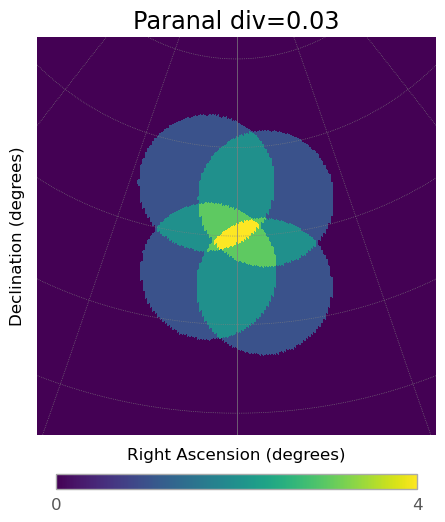

In [26]:
config_MST.multiplicity_plot()

In [27]:
table_SST_conv = []
table_SST= config_SST.table
number_of_telescopes_config_SST_first_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_conv.append(table_SST['x'])
table_SST_conv.append(table_SST['y'])
table_SST_conv.append(table_SST['z'])
table_SST_conv.append(table_SST['focal'])
table_SST_conv.append(table_SST['radius'])
table_SST_conv.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config = []
telescopes = [1, 2,3,4,5,6]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Putting it tel-1 because the first column we had the index
    sub_config.append([col[tel - 1] for col in table_SST_conv])
    number_of_telescopes_config_SST_first_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config)
print(number_of_telescopes_config_SST_first_half)

[[0.0, 816.83, 21.83, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, 404.67, 16.75, 5.6, 4.450000000000001, 62.46242685852285], [-840.0, -404.67, 55.92, 5.6, 4.450000000000001, 62.46242685852285], [0.0, -816.83, 65.42, 5.6, 4.450000000000001, 62.46242685852285], [839.67, -404.67, 17.75, 5.6, 4.450000000000001, 62.46242685852285], [839.67, 404.67, 10.08, 5.6, 4.450000000000001, 62.46242685852285]]
[6, 3, 3, 6, 3, 3]


In [28]:
table_SST_div = []
table_SST= config_SST.table
number_of_telescopes_config_SST_second_half=[]
# Append the columns for LST so I know what to get or expect
table_SST_div.append(table_SST['x'])
table_SST_div.append(table_SST['y'])
table_SST_div.append(table_SST['z'])
table_SST_div.append(table_SST['focal'])
table_SST_div.append(table_SST['radius'])
table_SST_div.append(table_SST['fov'])

# Initialize sub_config and other variables
sub_config_div= []
telescopes = [7,8,9,10,11,12,13]  # Telescope indices
# Loop through the telescopes so I can write them in a file
for tel in telescopes:
    # Adjust for 1-based indexing in telescopes to 0-based indexing in Python
    sub_config_div.append([col[tel - 1] for col in table_SST_div])
    number_of_telescopes_config_SST_second_half.append(number_of_telescopes_config_SST[tel-1])


# Print the result for verification
print(sub_config_div)
print(number_of_telescopes_config_SST_second_half)

[[-7.75, 0.0, 22.5, 5.6, 4.450000000000001, 62.46242685852285], [415.67, 402.0, 12.42, 5.6, 4.450000000000001, 62.46242685852285], [415.67, -402.0, 27.92, 5.6, 4.450000000000001, 62.46242685852285], [429.33, 0.0, 16.08, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, -402.0, 48.25, 5.6, 4.450000000000001, 62.46242685852285], [-415.67, 402.0, 15.58, 5.6, 4.450000000000001, 62.46242685852285], [-429.67, 0.0, 29.42, 5.6, 4.450000000000001, 62.46242685852285]]
[4, 3, 3, 3, 3, 3, 3]


In [29]:
# Define the file path where you want to save the output
output_file_path_3 = './best_SST_conv.txt'

# Open the file in write mode
with open(output_file_path_3, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_3}")
# Define the file path where you want to save the output
output_file_path_4 = './best_SST_div.txt'

# Open the file in write mode
with open(output_file_path_4, 'w') as file:
    
    # Write a header
    #file.write("Group ID, X_Center, Y_Center, Z_Center, Focal Length, FOV\n")
    
    # Loop through all new telescopes (grouped telescopes)
   for telescope in sub_config_div:
        # Assuming each telescope in sub_config is a list like [x_center, y_center, z_center, focal_length, fov]
        values = ' '.join(map(str, telescope))  # Convert all elements to string
        file.write(f"{values}\n")  # Write each row of telescope data

print(f"New telescope data has been written to {output_file_path_4}")

New telescope data has been written to ./best_SST_conv.txt
New telescope data has been written to ./best_SST_div.txt


In [30]:
SST_config_conv= LoadConfig('./best_SST_conv.txt', complete_array=full_array_config_SST,frame=cta, pointing2src=True)
SST_config_div=LoadConfig('./best_SST_div.txt',complete_array=full_array_config_SST, frame=cta, pointing2src=True)

In [31]:
SST_config_conv.table.units= "deg"
SST_config_div.table.units= "deg"

In [32]:
SST_config_conv.table

<Table length=6>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1     0.0  816.83   21.83   0.000 ...   1.000  -0.000   0.000  816.85
    2  -840.0  404.67   16.75   0.000 ...   1.000  -0.000   0.000  931.85
    3  -840.0 -404.67   55.92   0.000 ...   1.000  -0.000   0.000  932.21
    4     0.0 -816.83   65.42   0.000 ...   1.000  -0.000   0.000  817.70
    5  839.67 -404.67   17.75   0.000 ...   1.000  -0.000   0.000  932.76
    6  839.67  404.67   10.08   0.000 ...   1.000  -0.000   0.000  932.87

In [33]:
SST_config_div.table

<Table length=7>
  id     x       y       z       az   ...   p_x     p_y     p_z    d_tel 
         m       m       m      deg   ...                            m   
int64 float64 float64 float64 float64 ... float64 float64 float64 float64
----- ------- ------- ------- ------- ... ------- ------- ------- -------
    1   -7.75     0.0    22.5   0.000 ...   1.000  -0.000   0.000    8.77
    2  415.67   402.0   12.42   0.000 ...   1.000  -0.000   0.000  578.95
    3  415.67  -402.0   27.92   0.000 ...   1.000  -0.000   0.000  578.74
    4  429.33     0.0   16.08   0.000 ...   1.000  -0.000   0.000  430.16
    5 -415.67  -402.0   48.25   0.000 ...   1.000  -0.000   0.000  578.14
    6 -415.67   402.0   15.58   0.000 ...   1.000  -0.000   0.000  577.90
    7 -429.67     0.0   29.42   0.000 ...   1.000  -0.000   0.000  429.00

The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.222262454487758 rad
-0.0 rad
1.176887104010464 rad
-0.11263463708240247 rad
1.1775244935921183 rad
0.11263463708240247 rad
1.1779300110483386 rad
-0.0 rad
1.2624600356632756 rad
0.1465929285903732 rad
1.2613630142663803 rad
-0.1465929285903732 rad
1.266415848438501 rad
-0.0 rad


6it [00:00,  6.32it/s]
7it [00:01,  6.63it/s]
6it [00:00,  6.19it/s]


12.639706828454463


7it [00:01,  6.54it/s]


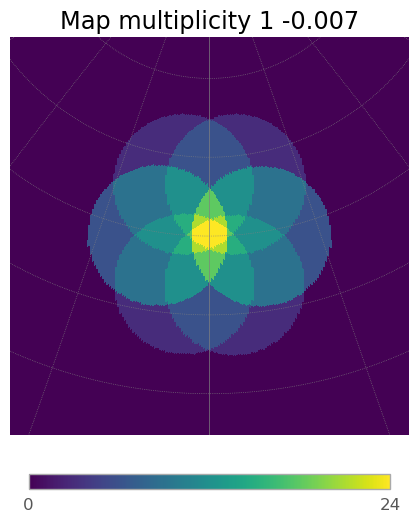

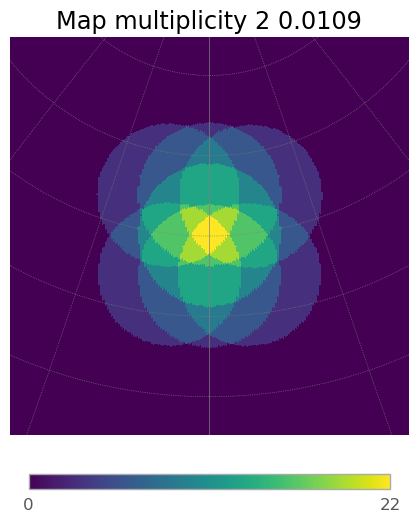

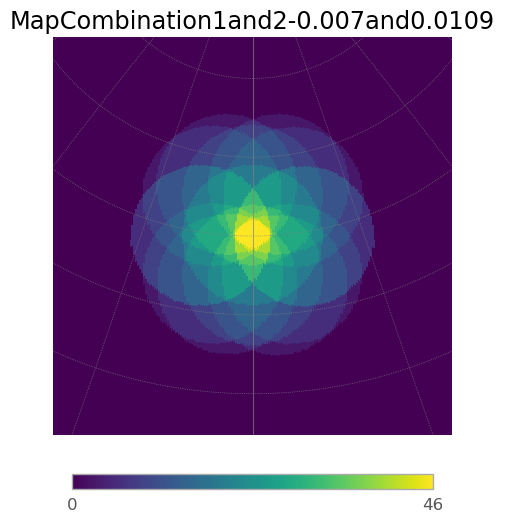

In [34]:
SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=-0.007, div2=0.0109, az=0, alt=70)
SST_config_conv.multiplicity_plot_2_div(SST_config_div, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)


In [35]:
SST_config_conv.hFoV_for_2_arrays(array_2=SST_config_div, subarray_mult=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half)

6it [00:00,  6.43it/s]
7it [00:01,  6.58it/s]


(189.95575704505862, 15.055298584742838)

6it [00:00,  6.25it/s]
7it [00:01,  6.74it/s]
4it [00:00,  6.65it/s]
6it [00:00,  6.47it/s]


12.639706828454463


7it [00:01,  6.71it/s]
4it [00:00,  6.79it/s]


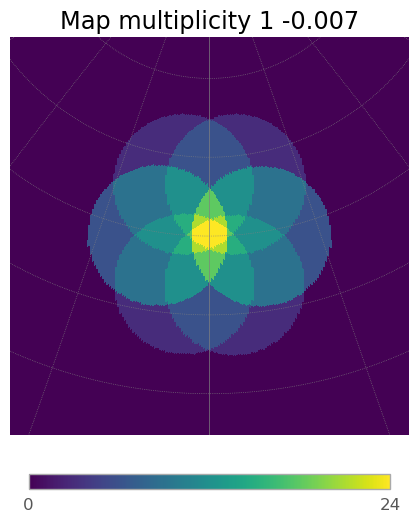

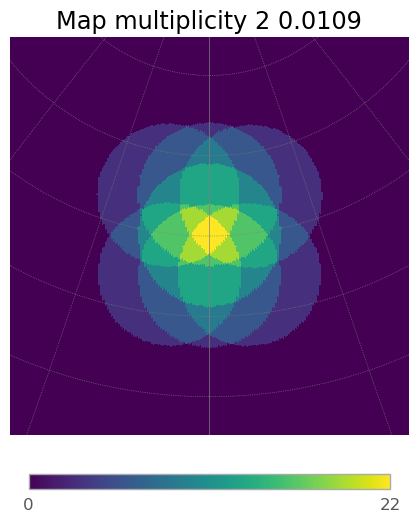

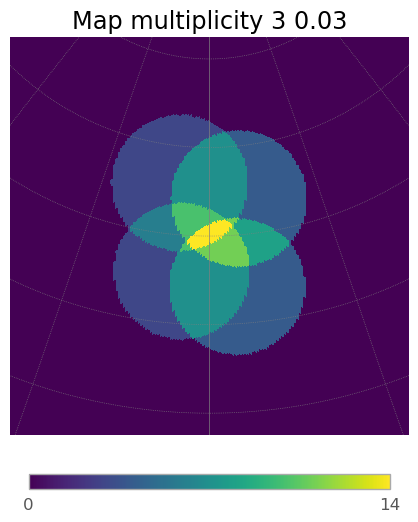

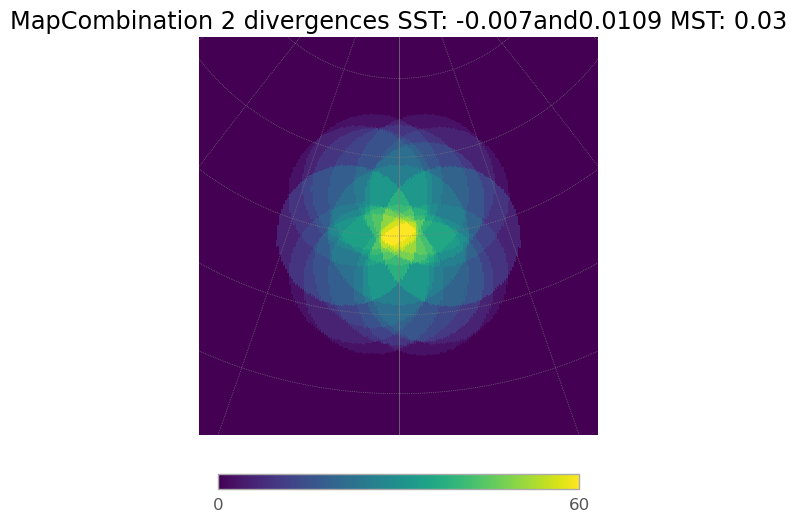

In [36]:
SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)




In [37]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

6it [00:00,  6.50it/s]
7it [00:01,  6.71it/s]
4it [00:00,  6.56it/s]


(189.95575704505862, 18.48629616845012)

In [38]:
#From the table the ones to use for the array MST
#    0.0022
#    0.0043
#    0.008
#    0.01135
#    0.01453
# FOR THE SST the idea is to use 
#0.0022, 
#0.0043, 
#0.008, 
#0.01135, 
#0.013
#AND FOR THE CONVERGENCE TO USE: THIS WERE CALCULATED IN ORDER TO HAVE THE SAME HFOV AT THE CENTER FOR DIV AND CONV
#-0.0013434343434343427,
# -0.0026343434343434335,
# -0.005001010101010101,
# -0.007224242424242425,
# -0.0083]
#
#
#

In [39]:
div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453]
divergence_list=[]
div_SST=np.linspace(0.001,0.014, 150)
for divergence in div_MST:
    for divergence_SST in div_SST:
        print(f" the div{divergence_SST}")
        config_MST.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=config_MST.hFoV(m_cut=13, subarray_mult=number_of_telescopes_subarray_1 )[0]
        SST_config_div.divergent_pointing(div=divergence_SST, complete_array=full_array_config_SST,az=0, alt=70)
        print(f" the stop{round(hFoV_to_stop)}")
        hFoV_div=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        print(f" the div h FoV {round(hFoV_div)}")
        if round(hFoV_div) == round(hFoV_to_stop):
            divergence_list.append(divergence_SST)
            print(f"stop, the {divergence_SST}")
            break 

 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.79it/s]


 the div h FoV 54
 the div0.001087248322147651
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.64it/s]


 the div h FoV 54
 the div0.0011744966442953021
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.28it/s]


 the div h FoV 53
 the div0.001261744966442953
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.65it/s]


 the div h FoV 52
 the div0.001348993288590604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.71it/s]


 the div h FoV 52
 the div0.001436241610738255
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.38it/s]


 the div h FoV 51
 the div0.0015234899328859062
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.58it/s]


 the div h FoV 50
 the div0.0016107382550335572
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.65it/s]


 the div h FoV 50
 the div0.001697986577181208
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.73it/s]


 the div h FoV 49
 the div0.0017852348993288593
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.70it/s]


 the div h FoV 48
 the div0.0018724832214765102
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.70it/s]


 the div h FoV 48
 the div0.0019597315436241615
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.07it/s]


 the div h FoV 47
 the div0.0020469798657718123
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.59it/s]


 the div h FoV 47
 the div0.002134228187919463
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.53it/s]


 the div h FoV 46
 the div0.0022214765100671144
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.42it/s]


 the div h FoV 45
 the div0.0023087248322147653
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.81it/s]


 the div h FoV 45
 the div0.002395973154362416
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.61it/s]


 the div h FoV 44
 the div0.0024832214765100674
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.06it/s]


 the div h FoV 43
 the div0.0025704697986577187
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.71it/s]


 the div h FoV 43
 the div0.002657718120805369
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.78it/s]


 the div h FoV 42
stop, the 0.002657718120805369
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.11it/s]


 the div h FoV 54
 the div0.001087248322147651
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.69it/s]


 the div h FoV 54
 the div0.0011744966442953021
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.68it/s]


 the div h FoV 53
 the div0.001261744966442953
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.40it/s]


 the div h FoV 52
 the div0.001348993288590604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.76it/s]


 the div h FoV 52
 the div0.001436241610738255
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.74it/s]


 the div h FoV 51
 the div0.0015234899328859062
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.60it/s]


 the div h FoV 50
 the div0.0016107382550335572
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.80it/s]


 the div h FoV 50
 the div0.001697986577181208
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.70it/s]


 the div h FoV 49
 the div0.0017852348993288593
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.74it/s]


 the div h FoV 48
 the div0.0018724832214765102
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.81it/s]


 the div h FoV 48
 the div0.0019597315436241615
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.78it/s]


 the div h FoV 47
 the div0.0020469798657718123
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.80it/s]


 the div h FoV 47
 the div0.002134228187919463
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.75it/s]


 the div h FoV 46
 the div0.0022214765100671144
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.76it/s]


 the div h FoV 45
 the div0.0023087248322147653
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.51it/s]


 the div h FoV 45
 the div0.002395973154362416
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.01it/s]


 the div h FoV 44
 the div0.0024832214765100674
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.73it/s]


 the div h FoV 43
 the div0.0025704697986577187
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.59it/s]


 the div h FoV 43
 the div0.002657718120805369
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.65it/s]


 the div h FoV 42
 the div0.0027449664429530203
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.80it/s]


 the div h FoV 42
 the div0.0028322147651006716
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.77it/s]


 the div h FoV 41
 the div0.0029194630872483225
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.70it/s]


 the div h FoV 40
 the div0.0030067114093959733
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.72it/s]


 the div h FoV 40
 the div0.0030939597315436246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.79it/s]


 the div h FoV 39
 the div0.0031812080536912754
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.76it/s]


 the div h FoV 39
 the div0.0032684563758389267
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.76it/s]


 the div h FoV 38
stop, the 0.0032684563758389267
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.69it/s]


 the div h FoV 54
 the div0.001087248322147651
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.75it/s]


 the div h FoV 54
 the div0.0011744966442953021
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.75it/s]


 the div h FoV 53
 the div0.001261744966442953
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.30it/s]


 the div h FoV 52
 the div0.001348993288590604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.61it/s]


 the div h FoV 52
 the div0.001436241610738255
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.65it/s]


 the div h FoV 51
 the div0.0015234899328859062
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.82it/s]


 the div h FoV 50
 the div0.0016107382550335572
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.56it/s]


 the div h FoV 50
 the div0.001697986577181208
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.63it/s]


 the div h FoV 49
 the div0.0017852348993288593
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.75it/s]


 the div h FoV 48
 the div0.0018724832214765102
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.82it/s]


 the div h FoV 48
 the div0.0019597315436241615
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.82it/s]


 the div h FoV 47
 the div0.0020469798657718123
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.79it/s]


 the div h FoV 47
 the div0.002134228187919463
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.78it/s]


 the div h FoV 46
 the div0.0022214765100671144
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.76it/s]


 the div h FoV 45
 the div0.0023087248322147653
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.77it/s]


 the div h FoV 45
 the div0.002395973154362416
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.71it/s]


 the div h FoV 44
 the div0.0024832214765100674
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.75it/s]


 the div h FoV 43
 the div0.0025704697986577187
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.83it/s]


 the div h FoV 43
 the div0.002657718120805369
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.62it/s]


 the div h FoV 42
 the div0.0027449664429530203
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.53it/s]


 the div h FoV 42
 the div0.0028322147651006716
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.85it/s]


 the div h FoV 41
 the div0.0029194630872483225
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.71it/s]


 the div h FoV 40
 the div0.0030067114093959733
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.60it/s]


 the div h FoV 40
 the div0.0030939597315436246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.67it/s]


 the div h FoV 39
 the div0.0031812080536912754
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.72it/s]


 the div h FoV 39
 the div0.0032684563758389267
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.82it/s]


 the div h FoV 38
 the div0.0033557046979865775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.69it/s]


 the div h FoV 37
 the div0.0034429530201342284
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.85it/s]


 the div h FoV 37
 the div0.0035302013422818797
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.67it/s]


 the div h FoV 36
 the div0.0036174496644295305
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.72it/s]


 the div h FoV 36
 the div0.0037046979865771818
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.52it/s]


 the div h FoV 35
 the div0.0037919463087248326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.72it/s]


 the div h FoV 35
 the div0.0038791946308724835
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.71it/s]


 the div h FoV 34
 the div0.003966442953020135
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.65it/s]


 the div h FoV 34
 the div0.004053691275167786
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.64it/s]


 the div h FoV 33
 the div0.004140939597315436
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.67it/s]


 the div h FoV 32
 the div0.004228187919463088
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.79it/s]


 the div h FoV 32
 the div0.004315436241610739
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.77it/s]


 the div h FoV 31
stop, the 0.004315436241610739
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.65it/s]


 the div h FoV 54
 the div0.001087248322147651
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.75it/s]


 the div h FoV 54
 the div0.0011744966442953021
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.75it/s]


 the div h FoV 53
 the div0.001261744966442953
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.75it/s]


 the div h FoV 52
 the div0.001348993288590604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.74it/s]


 the div h FoV 52
 the div0.001436241610738255
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.68it/s]


 the div h FoV 51
 the div0.0015234899328859062
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.73it/s]


 the div h FoV 50
 the div0.0016107382550335572
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.73it/s]


 the div h FoV 50
 the div0.001697986577181208
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.78it/s]


 the div h FoV 49
 the div0.0017852348993288593
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.80it/s]


 the div h FoV 48
 the div0.0018724832214765102
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  5.84it/s]


 the div h FoV 48
 the div0.0019597315436241615
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.62it/s]


 the div h FoV 47
 the div0.0020469798657718123
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.75it/s]


 the div h FoV 47
 the div0.002134228187919463
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.65it/s]


 the div h FoV 46
 the div0.0022214765100671144
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.76it/s]


 the div h FoV 45
 the div0.0023087248322147653
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.76it/s]


 the div h FoV 45
 the div0.002395973154362416
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.71it/s]


 the div h FoV 44
 the div0.0024832214765100674
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.61it/s]


 the div h FoV 43
 the div0.0025704697986577187
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.62it/s]


 the div h FoV 43
 the div0.002657718120805369
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.41it/s]


 the div h FoV 42
 the div0.0027449664429530203
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.72it/s]


 the div h FoV 42
 the div0.0028322147651006716
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.81it/s]


 the div h FoV 41
 the div0.0029194630872483225
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.54it/s]


 the div h FoV 40
 the div0.0030067114093959733
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.61it/s]


 the div h FoV 40
 the div0.0030939597315436246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.74it/s]


 the div h FoV 39
 the div0.0031812080536912754
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.91it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.51it/s]


 the div h FoV 39
 the div0.0032684563758389267
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.80it/s]


 the div h FoV 38
 the div0.0033557046979865775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.22it/s]


 the div h FoV 37
 the div0.0034429530201342284
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.61it/s]


 the div h FoV 37
 the div0.0035302013422818797
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.52it/s]


 the div h FoV 36
 the div0.0036174496644295305
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.62it/s]


 the div h FoV 36
 the div0.0037046979865771818
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.72it/s]


 the div h FoV 35
 the div0.0037919463087248326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.55it/s]


 the div h FoV 35
 the div0.0038791946308724835
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.64it/s]


 the div h FoV 34
 the div0.003966442953020135
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.69it/s]


 the div h FoV 34
 the div0.004053691275167786
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.73it/s]


 the div h FoV 33
 the div0.004140939597315436
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.60it/s]


 the div h FoV 32
 the div0.004228187919463088
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  4.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.35it/s]


 the div h FoV 32
 the div0.004315436241610739
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.70it/s]


 the div h FoV 31
 the div0.004402684563758389
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  5.99it/s]


 the div h FoV 31
 the div0.004489932885906041
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.66it/s]


 the div h FoV 30
 the div0.004577181208053692
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.40it/s]


 the div h FoV 30
 the div0.004664429530201342
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.58it/s]


 the div h FoV 29
 the div0.004751677852348994
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.48it/s]


 the div h FoV 29
 the div0.004838926174496645
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.70it/s]


 the div h FoV 28
 the div0.004926174496644296
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.55it/s]


 the div h FoV 28
 the div0.005013422818791947
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.62it/s]


 the div h FoV 27
 the div0.005100671140939598
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.69it/s]


 the div h FoV 27
 the div0.005187919463087249
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.60it/s]


 the div h FoV 26
 the div0.0052751677852348995
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.53it/s]


 the div h FoV 26
 the div0.005362416107382551
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.61it/s]


 the div h FoV 25
stop, the 0.005362416107382551
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.61it/s]


 the div h FoV 54
 the div0.001087248322147651
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.50it/s]


 the div h FoV 54
 the div0.0011744966442953021
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.64it/s]


 the div h FoV 53
 the div0.001261744966442953
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  5.23it/s]


 the div h FoV 52
 the div0.001348993288590604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.65it/s]


 the div h FoV 52
 the div0.001436241610738255
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.73it/s]


 the div h FoV 51
 the div0.0015234899328859062
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.64it/s]


 the div h FoV 50
 the div0.0016107382550335572
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.71it/s]


 the div h FoV 50
 the div0.001697986577181208
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.60it/s]


 the div h FoV 49
 the div0.0017852348993288593
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.71it/s]


 the div h FoV 48
 the div0.0018724832214765102
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.64it/s]


 the div h FoV 48
 the div0.0019597315436241615
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 47
 the div0.0020469798657718123
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.73it/s]


 the div h FoV 47
 the div0.002134228187919463
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.72it/s]


 the div h FoV 46
 the div0.0022214765100671144
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 45
 the div0.0023087248322147653
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.61it/s]


 the div h FoV 45
 the div0.002395973154362416
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 44
 the div0.0024832214765100674
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.57it/s]


 the div h FoV 43
 the div0.0025704697986577187
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.50it/s]


 the div h FoV 43
 the div0.002657718120805369
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.66it/s]


 the div h FoV 42
 the div0.0027449664429530203
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.57it/s]


 the div h FoV 42
 the div0.0028322147651006716
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.70it/s]


 the div h FoV 41
 the div0.0029194630872483225
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.67it/s]


 the div h FoV 40
 the div0.0030067114093959733
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 40
 the div0.0030939597315436246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.64it/s]


 the div h FoV 39
 the div0.0031812080536912754
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 39
 the div0.0032684563758389267
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.72it/s]


 the div h FoV 38
 the div0.0033557046979865775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  4.59it/s]


 the div h FoV 37
 the div0.0034429530201342284
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.59it/s]


 the div h FoV 37
 the div0.0035302013422818797
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.66it/s]


 the div h FoV 36
 the div0.0036174496644295305
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.68it/s]


 the div h FoV 36
 the div0.0037046979865771818
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.76it/s]


 the div h FoV 35
 the div0.0037919463087248326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.11it/s]


 the div h FoV 35
 the div0.0038791946308724835
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.68it/s]


 the div h FoV 34
 the div0.003966442953020135
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.48it/s]


 the div h FoV 34
 the div0.004053691275167786
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.60it/s]


 the div h FoV 33
 the div0.004140939597315436
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.43it/s]


 the div h FoV 32
 the div0.004228187919463088
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.62it/s]


 the div h FoV 32
 the div0.004315436241610739
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.73it/s]


 the div h FoV 31
 the div0.004402684563758389
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.76it/s]


 the div h FoV 31
 the div0.004489932885906041
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.77it/s]


 the div h FoV 30
 the div0.004577181208053692
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.86it/s]


 the div h FoV 30
 the div0.004664429530201342
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.77it/s]


 the div h FoV 29
 the div0.004751677852348994
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.72it/s]


 the div h FoV 29
 the div0.004838926174496645
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.66it/s]


 the div h FoV 28
 the div0.004926174496644296
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.71it/s]


 the div h FoV 28
 the div0.005013422818791947
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.78it/s]


 the div h FoV 27
 the div0.005100671140939598
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  5.15it/s]


 the div h FoV 27
 the div0.005187919463087249
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.67it/s]


 the div h FoV 26
 the div0.0052751677852348995
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.82it/s]


 the div h FoV 26
 the div0.005362416107382551
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.41it/s]


 the div h FoV 25
 the div0.005449664429530202
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.79it/s]


 the div h FoV 25
 the div0.005536912751677853
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.42it/s]


 the div h FoV 24
 the div0.005624161073825504
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.25it/s]


 the div h FoV 24
 the div0.005711409395973155
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.04it/s]


 the div h FoV 23
 the div0.005798657718120806
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.26it/s]


 the div h FoV 23
 the div0.005885906040268457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.36it/s]


 the div h FoV 22
 the div0.005973154362416108
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.71it/s]


 the div h FoV 22
 the div0.006060402684563759
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.48it/s]


 the div h FoV 22
 the div0.00614765100671141
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.39it/s]


 the div h FoV 21
 the div0.006234899328859061
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.33it/s]


 the div h FoV 21
 the div0.006322147651006712
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.60it/s]

 the div h FoV 20
stop, the 0.006322147651006712


In [40]:
conv=np.linspace(-0.0083,-0.0012, 100)
convergence_list=[]
for divergence in divergence_list:
    for convergence in conv:
        SST_config_div.divergent_pointing(complete_array=full_array_config_SST, div=divergence, az=0, alt=70)
        hFoV_to_stop=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        SST_config_conv.divergent_pointing(complete_array=full_array_config_SST, div=convergence, az=0, alt=70)
        hFoV_conv=SST_config_conv.hFoV(subarray_mult=number_of_telescopes_config_SST_first_half,m_cut=23)[0]
        if hFoV_conv > hFoV_to_stop:
            convergence_list.append(convergence)
            print(f"stop, the {convergence}")
            break 

The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.00it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.01it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.90it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.94it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  4.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.95it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.12it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.99it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.91it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.84it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.12it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.98it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.98it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.88it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  4.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  4.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.94it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


stop, the -0.0016303030303030297
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  3.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.94it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  4.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.05it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.89it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.05it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.90it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  4.87it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.01it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.89it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.91it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.12it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  3.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


stop, the -0.001988888888888888
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.88it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.87it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


stop, the -0.0026343434343434335
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.84it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.84it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.84it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.87it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  3.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  4.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.99it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


stop, the -0.00327979797979798
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]

stop, the -0.003925252525252525


In [41]:
divergence_list

[0.002657718120805369,
 0.0032684563758389267,
 0.004315436241610739,
 0.005362416107382551,
 0.006322147651006712]

In [42]:
convergence_list

[-0.0016303030303030297,
 -0.001988888888888888,
 -0.0026343434343434335,
 -0.00327979797979798,
 -0.003925252525252525]

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2218601019723565 rad
-0.0 rad
1.2110791404570624 rad
-0.030249920554261726 rad
1.211223586504191 rad
0.030249920554261726 rad
1.2109254022840972 rad
-0.0 rad
1.232152707117632 rad
0.03226784804055929 rad
1.2318631095201118 rad
-0.03226784804055929 rad
1.2325013277897028 rad
-0.0 rad


6it [00:00,  6.40it/s]
7it [00:01,  6.78it/s]
4it [00:00,  6.49it/s]
6it [00:00,  6.43it/s]


10.215339466221788


7it [00:01,  6.80it/s]
4it [00:00,  6.72it/s]


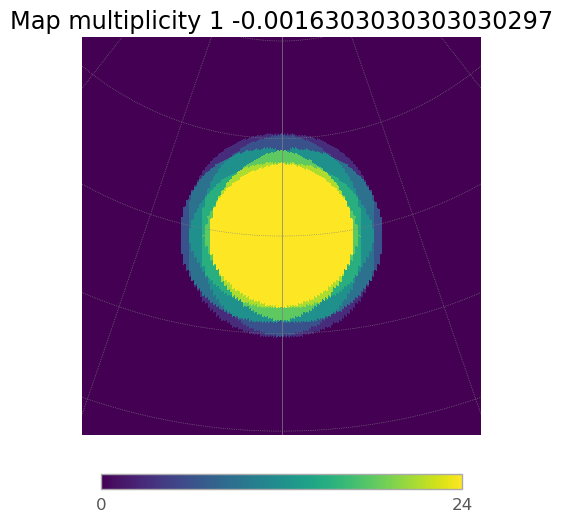

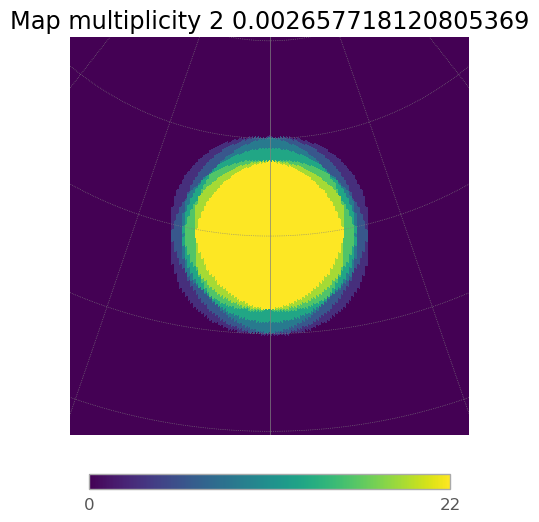

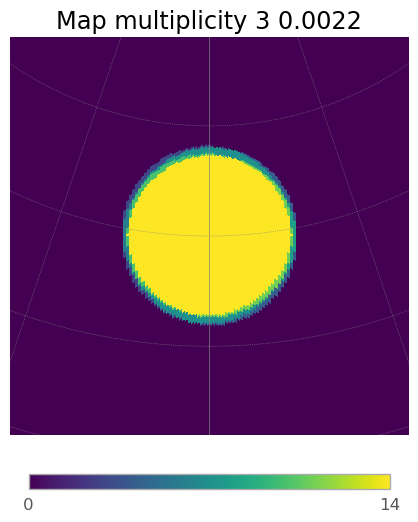

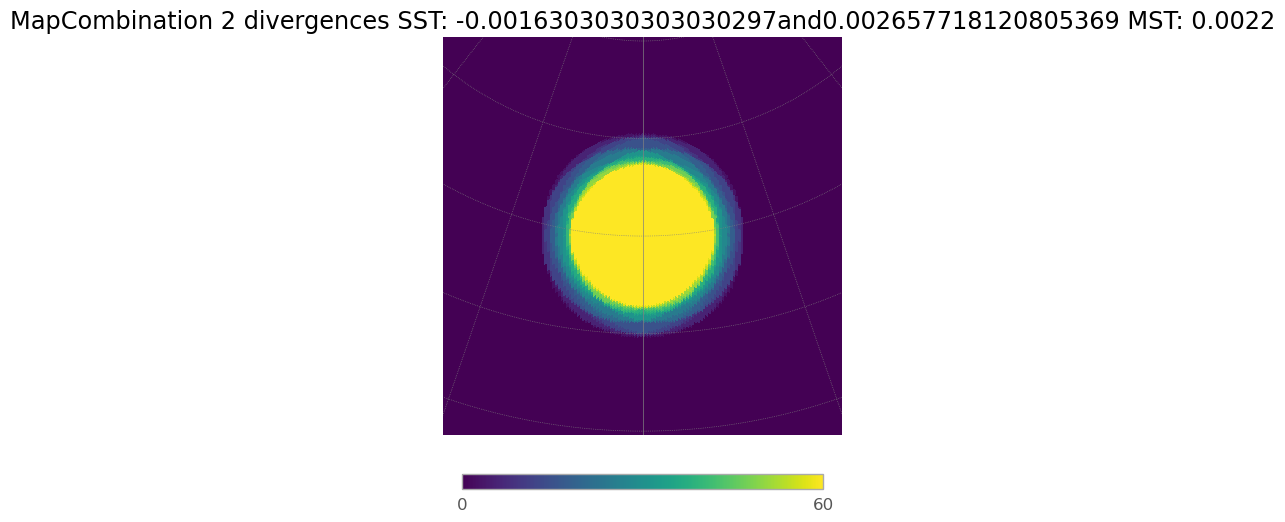

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.221889897059025 rad
-0.0 rad
1.2086012087241913 rad
-0.03692983518856858 rad
1.2087798533304988 rad
0.03692983518856858 rad
1.208453659073068 rad
-0.0 rad
1.2345089208523028 rad
0.03998179280982961 rad
1.2341548444405168 rad
-0.03998179280982961 rad
1.23498800172355 rad
-0.0 rad


6it [00:00,  6.49it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.67it/s]
6it [00:00,  6.41it/s]


10.38234806580255


7it [00:01,  6.76it/s]
4it [00:00,  6.47it/s]


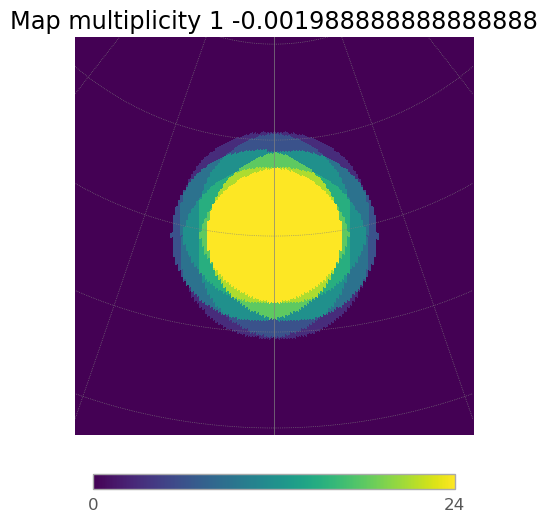

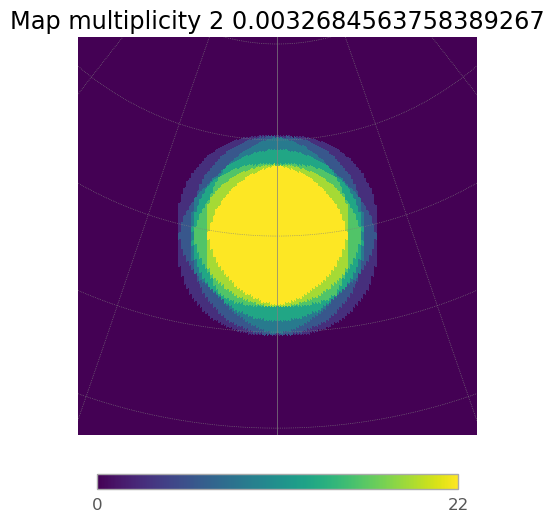

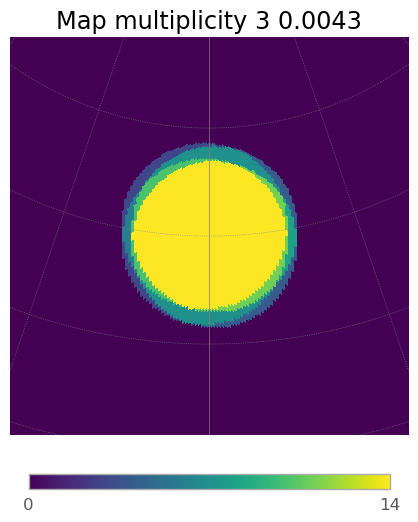

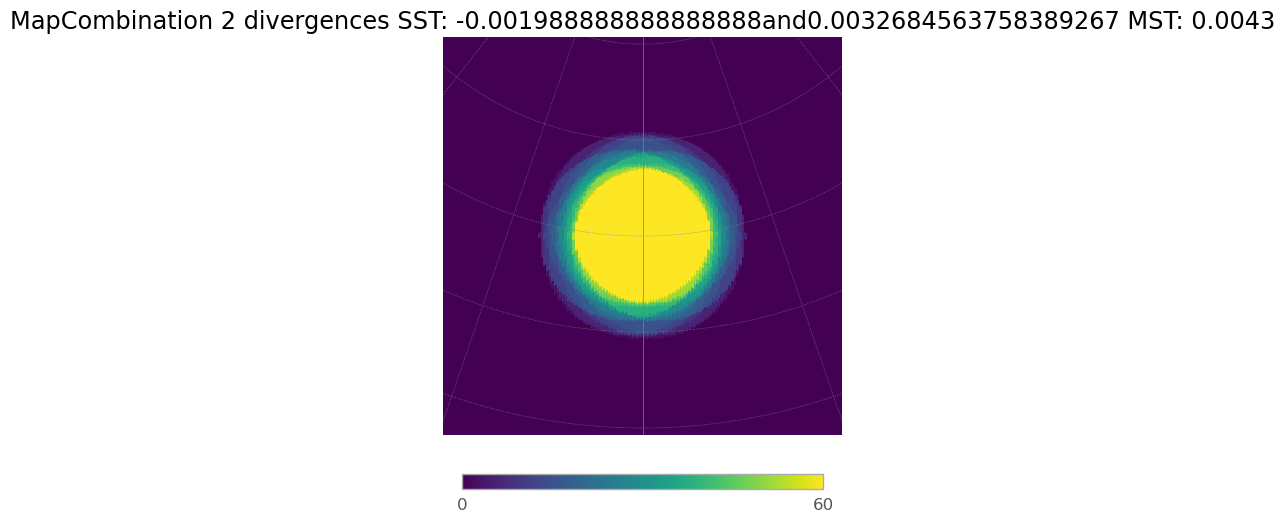

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219409809612976 rad
-0.0 rad
1.204329352029316 rad
-0.04815392837923249 rad
1.2045674963454223 rad
0.04815392837923249 rad
1.204226250435789 rad
-0.0 rad
1.2385116291526816 rad
0.053474499757720555 rad
1.2380487982126607 rad
-0.053474499757720555 rad
1.2392608256774007 rad
-0.0 rad


6it [00:00,  6.48it/s]
7it [00:01,  6.70it/s]
4it [00:00,  6.71it/s]
6it [00:00,  6.41it/s]


10.681907090507448


7it [00:01,  6.71it/s]
4it [00:00,  6.75it/s]


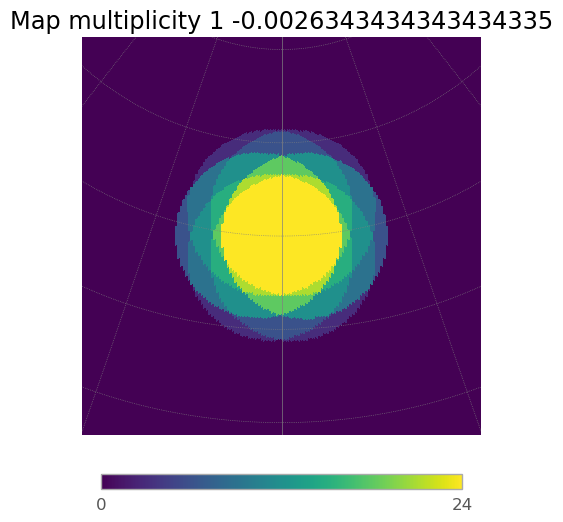

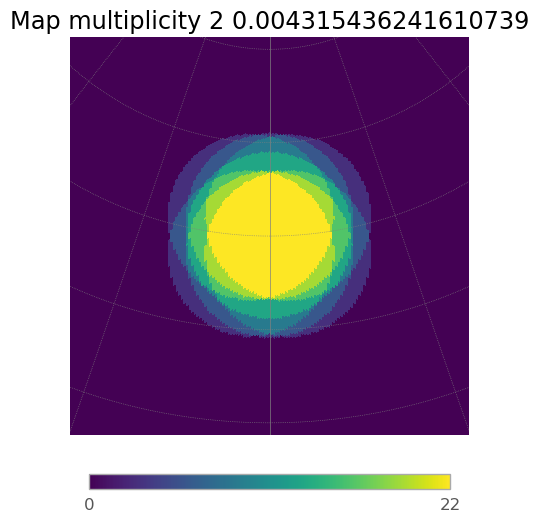

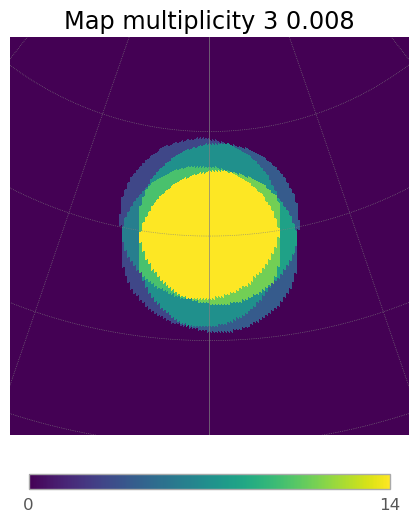

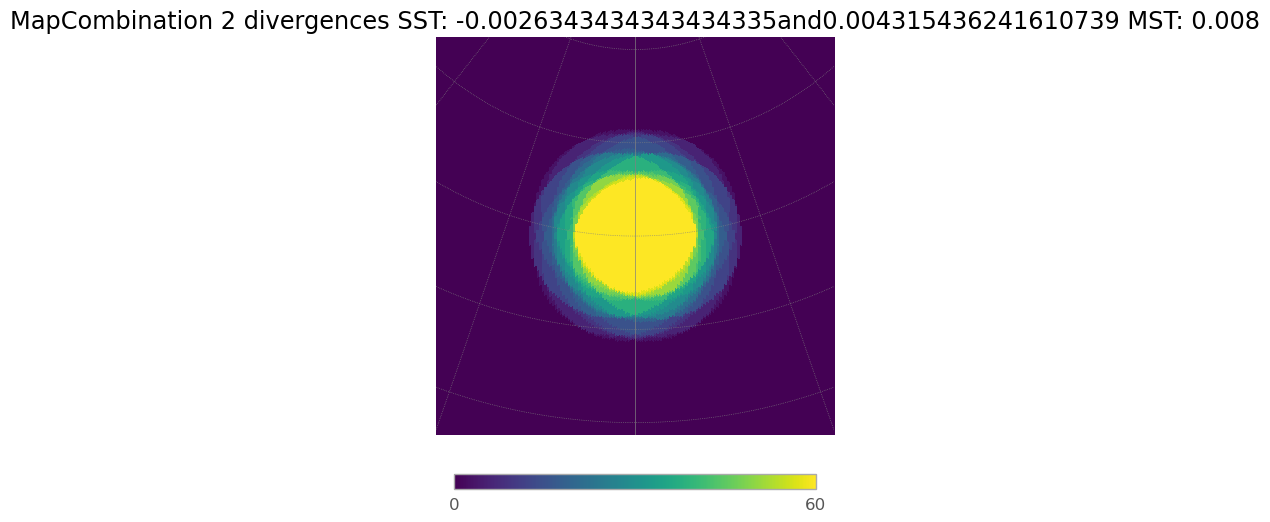

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219920733603369 rad
-0.0 rad
1.2000289866201987 rad
-0.05909791764769312 rad
1.2003277321808061 rad
0.05909791764769312 rad
1.2000113736733033 rad
-0.0 rad
1.2424659113064085 rad
0.06731377264259748 rad
1.2418965549408654 rad
-0.06731377264259748 rad
1.2435461486567965 rad
-0.0 rad


6it [00:00,  6.76it/s]
7it [00:01,  6.84it/s]
4it [00:00,  6.69it/s]
6it [00:00,  6.42it/s]


10.976231771331125


7it [00:01,  6.69it/s]
4it [00:00,  6.83it/s]


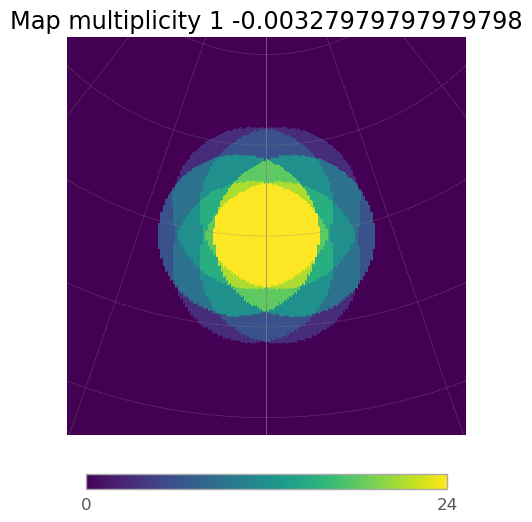

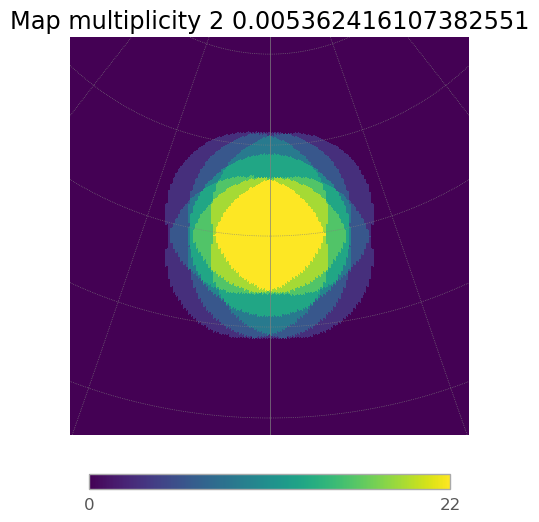

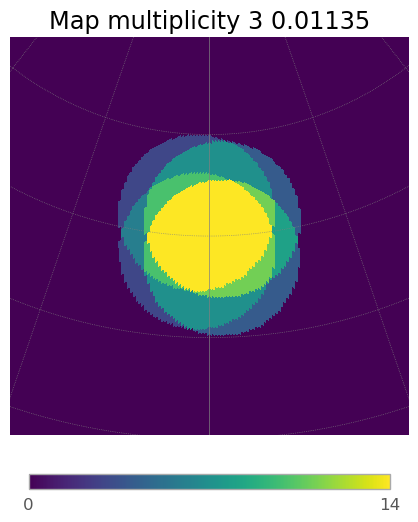

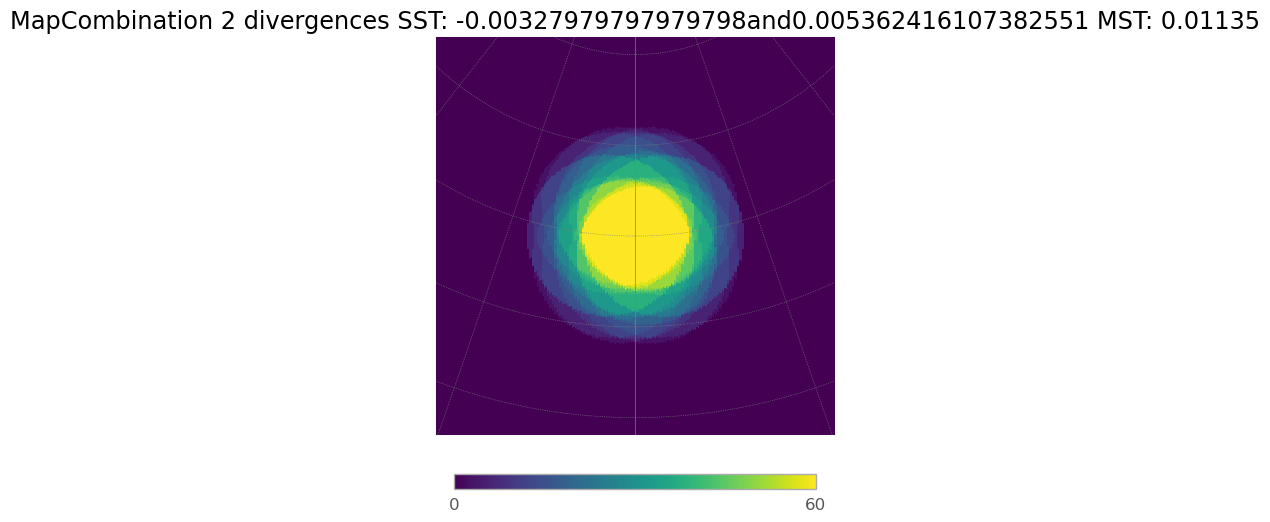

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.222038915668751 rad
-0.0 rad
1.196063643347555 rad
-0.06889056405055972 rad
1.1964189046764924 rad
0.06889056405055972 rad
1.1961588136069885 rad
-0.0 rad
1.2460457799798481 rad
0.08031111109554225 rad
1.2453807102284744 rad
-0.08031111109554225 rad
1.2474852654624713 rad
-0.0 rad


6it [00:00,  6.69it/s]
7it [00:01,  6.79it/s]
4it [00:00,  6.77it/s]
6it [00:00,  6.54it/s]


11.267724963705167


7it [00:01,  6.75it/s]
4it [00:00,  6.78it/s]


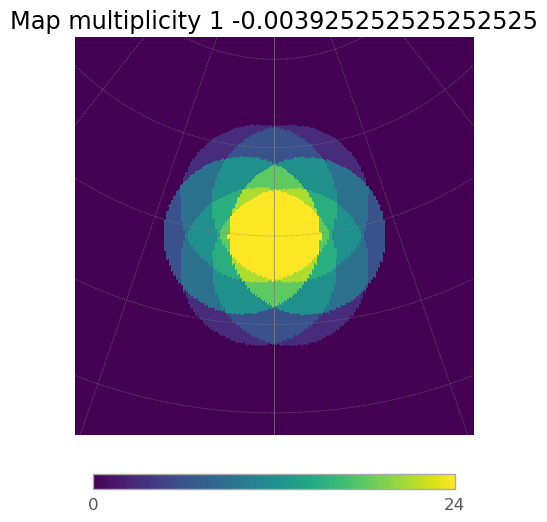

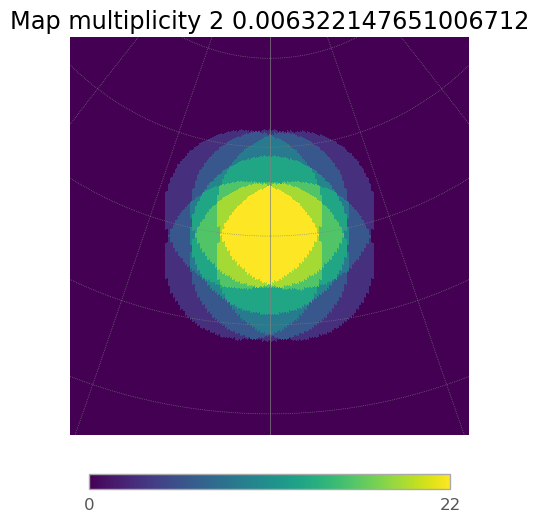

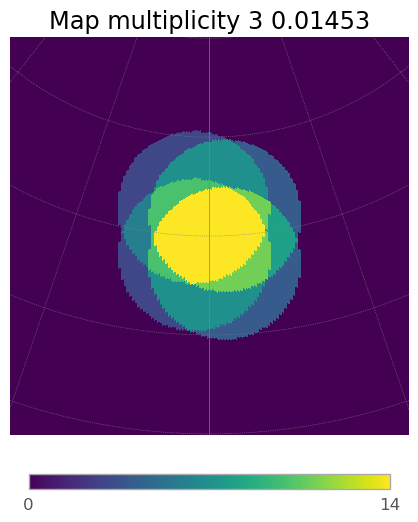

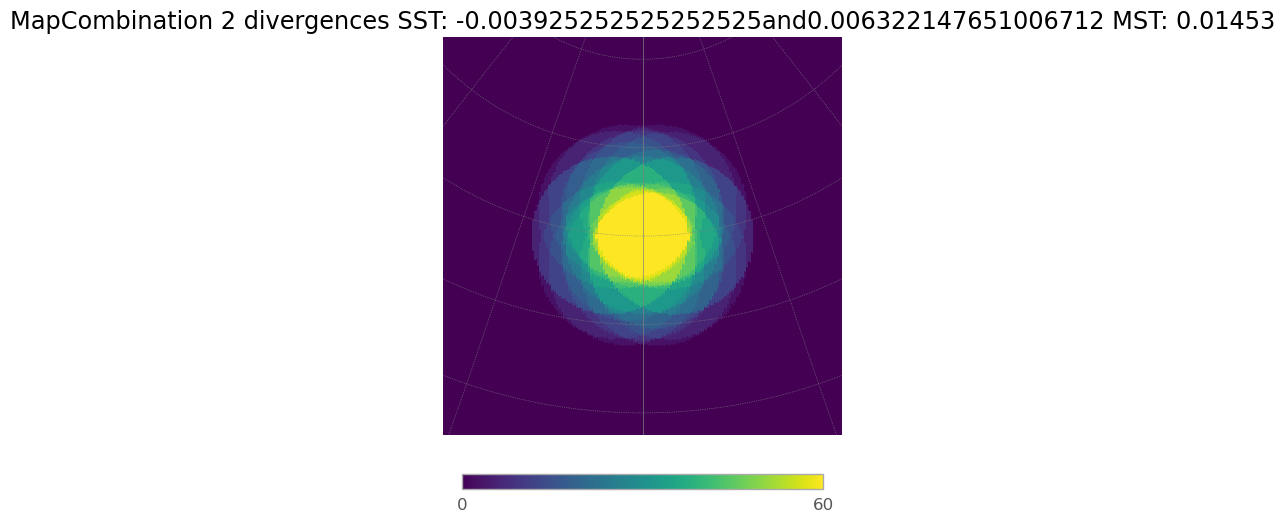

In [43]:

div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453 ]
div_SST=divergence_list
conv_SST=convergence_list
for i in range(5):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)





## UP TO 0.03

In [44]:
div_MST=[0.0022,0.0043, 0.008, 0.01135, 0.01453, 0.01753, 0.02053, 0.02353, 0.02653, 0.02953]

In [46]:
divergence_list=[]
div_SST=np.linspace(0.001,0.02222, 200)
for divergence in div_MST:
    for divergence_SST in div_SST:
        print(f" the div{divergence_SST}")
        config_MST.divergent_pointing(div=divergence, az=0, alt=70)
        hFoV_to_stop=config_MST.hFoV(m_cut=13, subarray_mult=number_of_telescopes_subarray_1 )[0]
        SST_config_div.divergent_pointing(complete_array=full_array_config_SST,div=divergence_SST, az=0, alt=70)
        print(f" the stop{round(hFoV_to_stop)}")
        hFoV_div=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        print(f" the div h FoV {round(hFoV_div)}")
        if round(hFoV_div) == round(hFoV_to_stop):
            divergence_SST=round(divergence_SST, 6)
            divergence_list.append(divergence_SST)
            print(f"stop, the {divergence_SST}")
            break 

 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.77it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.63it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.38it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.49it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.70it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.17it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.52it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.48it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.76it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.72it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.73it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.09it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.81it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.70it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.71it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.31it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop42


7it [00:01,  6.39it/s]


 the div h FoV 42
stop, the 0.002706
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.04it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.49it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.45it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.69it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.52it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.83it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.47it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.67it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.66it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.50it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.64it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.81it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.76it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.72it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.87it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.77it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.74it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.68it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.59it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.72it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.82it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.83it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop38


7it [00:01,  6.73it/s]


 the div h FoV 38
stop, the 0.003239
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.65it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.76it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.09it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.82it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.79it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.65it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.77it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.79it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.58it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.72it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.69it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.77it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.76it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.67it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.76it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.77it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.74it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  5.72it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.64it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.79it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.76it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.63it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.78it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.61it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.79it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.80it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.73it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.78it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.75it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.83it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.70it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop31


7it [00:01,  6.69it/s]


 the div h FoV 31
stop, the 0.004306
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.07it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.28it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.38it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.43it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.35it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.49it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.56it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.56it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.61it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.22it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.28it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.38it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.55it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.71it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.73it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.89it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.64it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.69it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.76it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.76it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.74it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.71it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.64it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.79it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.72it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.67it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.66it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.77it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.39it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.60it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:01,  3.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  5.89it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.39it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.39it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.48it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.72it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.71it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.75it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.67it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.79it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.65it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.70it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.72it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop25


7it [00:01,  6.80it/s]


 the div h FoV 25
stop, the 0.005372
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.67it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.68it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.21it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.71it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.72it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.67it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.69it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.77it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.38it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.65it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.73it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.81it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.74it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.27it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.49it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.30it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.32it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  5.84it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.17it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.61it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.78it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.74it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.43it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.49it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.32it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.41it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.23it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.25it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.57it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.65it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.70it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.50it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.91it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.78it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.66it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.78it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.69it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.76it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.73it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.63it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.74it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.69it/s]


 the div h FoV 25
 the div0.005478592964824121
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.70it/s]


 the div h FoV 25
 the div0.005585226130653266
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.29it/s]


 the div h FoV 24
 the div0.005691859296482412
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.01it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.54it/s]


 the div h FoV 23
 the div0.005798492462311558
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.58it/s]


 the div h FoV 23
 the div0.005905125628140703
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.18it/s]


 the div h FoV 22
 the div0.006011758793969849
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  4.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.55it/s]


 the div h FoV 22
 the div0.0061183919597989946
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.60it/s]


 the div h FoV 21
 the div0.00622502512562814
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.78it/s]


 the div h FoV 21
 the div0.006331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop20


7it [00:01,  6.80it/s]


 the div h FoV 20
stop, the 0.006332
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.71it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.73it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.79it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.61it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.23it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.32it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.35it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.13it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.22it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.28it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  5.84it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.55it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.38it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.33it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.49it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.29it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.26it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.42it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.37it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.67it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.25it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.41it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.67it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.67it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.33it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.41it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  5.32it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.29it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.56it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.63it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.67it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.40it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.35it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.42it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.86it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.05it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.12it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.60it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  5.73it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  5.88it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.20it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.39it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.72it/s]


 the div h FoV 25
 the div0.005478592964824121
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.78it/s]


 the div h FoV 25
 the div0.005585226130653266
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.76it/s]


 the div h FoV 24
 the div0.005691859296482412
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.63it/s]


 the div h FoV 23
 the div0.005798492462311558
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.60it/s]


 the div h FoV 23
 the div0.005905125628140703
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.46it/s]


 the div h FoV 22
 the div0.006011758793969849
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.66it/s]


 the div h FoV 22
 the div0.0061183919597989946
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.34it/s]


 the div h FoV 21
 the div0.00622502512562814
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.71it/s]


 the div h FoV 21
 the div0.006331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.74it/s]


 the div h FoV 20
 the div0.006438291457286432
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.74it/s]


 the div h FoV 20
 the div0.006544924623115578
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.63it/s]


 the div h FoV 19
 the div0.006651557788944724
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.32it/s]


 the div h FoV 19
 the div0.006758190954773869
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.68it/s]


 the div h FoV 18
 the div0.006864824120603015
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.68it/s]


 the div h FoV 18
 the div0.0069714572864321605
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.75it/s]


 the div h FoV 17
 the div0.007078090452261306
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.77it/s]


 the div h FoV 17
 the div0.007184723618090452
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.78it/s]


 the div h FoV 16
 the div0.007291356783919597
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.71it/s]


 the div h FoV 16
 the div0.007397989949748744
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop15


7it [00:01,  6.80it/s]


 the div h FoV 15
stop, the 0.007398
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  4.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.57it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.59it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.71it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.72it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.77it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.61it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.74it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.34it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.72it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.61it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.62it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.76it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.67it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.59it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.74it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.75it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.64it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.78it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.78it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.79it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.81it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.72it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.49it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.59it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.73it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  5.89it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.75it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.64it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.70it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.75it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.68it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.73it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.78it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.52it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.79it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.78it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.66it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.41it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.55it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.76it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.68it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.79it/s]


 the div h FoV 25
 the div0.005478592964824121
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.63it/s]


 the div h FoV 25
 the div0.005585226130653266
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.78it/s]


 the div h FoV 24
 the div0.005691859296482412
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.78it/s]


 the div h FoV 23
 the div0.005798492462311558
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.64it/s]


 the div h FoV 23
 the div0.005905125628140703
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.75it/s]


 the div h FoV 22
 the div0.006011758793969849
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.55it/s]


 the div h FoV 22
 the div0.0061183919597989946
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.80it/s]


 the div h FoV 21
 the div0.00622502512562814
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.82it/s]


 the div h FoV 21
 the div0.006331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.83it/s]


 the div h FoV 20
 the div0.006438291457286432
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.64it/s]


 the div h FoV 20
 the div0.006544924623115578
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.40it/s]


 the div h FoV 19
 the div0.006651557788944724
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.70it/s]


 the div h FoV 19
 the div0.006758190954773869
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.76it/s]


 the div h FoV 18
 the div0.006864824120603015
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.69it/s]


 the div h FoV 18
 the div0.0069714572864321605
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.76it/s]


 the div h FoV 17
 the div0.007078090452261306
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.25it/s]


 the div h FoV 17
 the div0.007184723618090452
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.29it/s]


 the div h FoV 16
 the div0.007291356783919597
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.54it/s]


 the div h FoV 16
 the div0.007397989949748744
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.34it/s]


 the div h FoV 15
 the div0.0075046231155778895
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.32it/s]


 the div h FoV 15
 the div0.007611256281407035
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.43it/s]


 the div h FoV 14
 the div0.007717889447236181
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.34it/s]


 the div h FoV 14
 the div0.007824522613065326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.43it/s]


 the div h FoV 13
 the div0.007931155778894472
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.70it/s]


 the div h FoV 13
 the div0.008037788944723618
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.72it/s]


 the div h FoV 12
 the div0.008144422110552763
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.21it/s]


 the div h FoV 12
 the div0.008251055276381909
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.69it/s]


 the div h FoV 12
 the div0.008357688442211055
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop11


7it [00:01,  6.72it/s]


 the div h FoV 11
stop, the 0.008358
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.55it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.41it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.62it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.27it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.26it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.29it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.19it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.44it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.17it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.72it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.73it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.65it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.98it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.43it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.42it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.67it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.76it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.68it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.71it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.71it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.69it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.71it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.68it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.79it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.75it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.51it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.65it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.65it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.24it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.64it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.74it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.86it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.71it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.66it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.63it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.67it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.61it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.64it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.79it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.78it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.63it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.35it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.23it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.35it/s]


 the div h FoV 25
 the div0.005478592964824121
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  4.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  5.76it/s]


 the div h FoV 25
 the div0.005585226130653266
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.22it/s]


 the div h FoV 24
 the div0.005691859296482412
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.40it/s]


 the div h FoV 23
 the div0.005798492462311558
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.48it/s]


 the div h FoV 23
 the div0.005905125628140703
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.39it/s]


 the div h FoV 22
 the div0.006011758793969849
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.52it/s]


 the div h FoV 22
 the div0.0061183919597989946
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.43it/s]


 the div h FoV 21
 the div0.00622502512562814
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.40it/s]


 the div h FoV 21
 the div0.006331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.42it/s]


 the div h FoV 20
 the div0.006438291457286432
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  5.92it/s]


 the div h FoV 20
 the div0.006544924623115578
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.45it/s]


 the div h FoV 19
 the div0.006651557788944724
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.20it/s]


 the div h FoV 19
 the div0.006758190954773869
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.62it/s]


 the div h FoV 18
 the div0.006864824120603015
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.72it/s]


 the div h FoV 18
 the div0.0069714572864321605
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.15it/s]


 the div h FoV 17
 the div0.007078090452261306
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.75it/s]


 the div h FoV 17
 the div0.007184723618090452
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.75it/s]


 the div h FoV 16
 the div0.007291356783919597
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.66it/s]


 the div h FoV 16
 the div0.007397989949748744
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.68it/s]


 the div h FoV 15
 the div0.0075046231155778895
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.71it/s]


 the div h FoV 15
 the div0.007611256281407035
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.30it/s]


 the div h FoV 14
 the div0.007717889447236181
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.30it/s]


 the div h FoV 14
 the div0.007824522613065326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.47it/s]


 the div h FoV 13
 the div0.007931155778894472
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.42it/s]


 the div h FoV 13
 the div0.008037788944723618
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.63it/s]


 the div h FoV 12
 the div0.008144422110552763
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.74it/s]


 the div h FoV 12
 the div0.008251055276381909
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.75it/s]


 the div h FoV 12
 the div0.008357688442211055
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.50it/s]


 the div h FoV 11
 the div0.008464321608040202
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.41it/s]


 the div h FoV 11
 the div0.008570954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  5.33it/s]


 the div h FoV 10
 the div0.008677587939698493
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  5.84it/s]


 the div h FoV 10
 the div0.008784221105527637
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.06it/s]


 the div h FoV 9
 the div0.008890854271356784
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.25it/s]


 the div h FoV 9
 the div0.008997487437185928
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.66it/s]


 the div h FoV 9
 the div0.009104120603015076
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop8


7it [00:01,  6.35it/s]


 the div h FoV 8
stop, the 0.009104
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.34it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.60it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.32it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.31it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.10it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.39it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.26it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.44it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.90it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.14it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.75it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.69it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.61it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.74it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.76it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.58it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.72it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.71it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.73it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.74it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.76it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.67it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  5.16it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.74it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.15it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.63it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.74it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.72it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.63it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.72it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.72it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.68it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.76it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.71it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.59it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.57it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.00it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.63it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.73it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.69it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.69it/s]


 the div h FoV 25
 the div0.005478592964824121
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.76it/s]


 the div h FoV 25
 the div0.005585226130653266
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.44it/s]


 the div h FoV 24
 the div0.005691859296482412
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.71it/s]


 the div h FoV 23
 the div0.005798492462311558
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.72it/s]


 the div h FoV 23
 the div0.005905125628140703
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.77it/s]


 the div h FoV 22
 the div0.006011758793969849
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.79it/s]


 the div h FoV 22
 the div0.0061183919597989946
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.69it/s]


 the div h FoV 21
 the div0.00622502512562814
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.71it/s]


 the div h FoV 21
 the div0.006331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.60it/s]


 the div h FoV 20
 the div0.006438291457286432
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.79it/s]


 the div h FoV 20
 the div0.006544924623115578
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.65it/s]


 the div h FoV 19
 the div0.006651557788944724
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.24it/s]


 the div h FoV 19
 the div0.006758190954773869
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.71it/s]


 the div h FoV 18
 the div0.006864824120603015
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 18
 the div0.0069714572864321605
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.66it/s]


 the div h FoV 17
 the div0.007078090452261306
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.65it/s]


 the div h FoV 17
 the div0.007184723618090452
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.68it/s]


 the div h FoV 16
 the div0.007291356783919597
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.62it/s]


 the div h FoV 16
 the div0.007397989949748744
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.74it/s]


 the div h FoV 15
 the div0.0075046231155778895
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 15
 the div0.007611256281407035
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.81it/s]


 the div h FoV 14
 the div0.007717889447236181
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 14
 the div0.007824522613065326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.68it/s]


 the div h FoV 13
 the div0.007931155778894472
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.68it/s]


 the div h FoV 13
 the div0.008037788944723618
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.76it/s]


 the div h FoV 12
 the div0.008144422110552763
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.63it/s]


 the div h FoV 12
 the div0.008251055276381909
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.01it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.55it/s]


 the div h FoV 12
 the div0.008357688442211055
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.69it/s]


 the div h FoV 11
 the div0.008464321608040202
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.70it/s]


 the div h FoV 11
 the div0.008570954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.76it/s]


 the div h FoV 10
 the div0.008677587939698493
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.82it/s]


 the div h FoV 10
 the div0.008784221105527637
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.77it/s]


 the div h FoV 9
 the div0.008890854271356784
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.72it/s]


 the div h FoV 9
 the div0.008997487437185928
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.81it/s]


 the div h FoV 9
 the div0.009104120603015076
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.56it/s]


 the div h FoV 8
 the div0.00921075376884422
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.69it/s]


 the div h FoV 8
 the div0.009317386934673367
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.79it/s]


 the div h FoV 8
 the div0.00942402010050251
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.84it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.77it/s]


 the div h FoV 7
 the div0.009530653266331658
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.80it/s]


 the div h FoV 7
 the div0.009637286432160802
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.63it/s]


 the div h FoV 7
 the div0.00974391959798995
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.73it/s]


 the div h FoV 6
 the div0.009850552763819097
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  5.01it/s]


 the div h FoV 6
 the div0.00995718592964824
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.60it/s]


 the div h FoV 6
 the div0.010063819095477388
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop5


7it [00:01,  6.61it/s]


 the div h FoV 5
stop, the 0.010064
 the div0.001
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.67it/s]


 the div h FoV 54
 the div0.0011066331658291456
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.62it/s]


 the div h FoV 54
 the div0.0012132663316582915
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.74it/s]


 the div h FoV 53
 the div0.0013198994974874371
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.69it/s]


 the div h FoV 52
 the div0.001426532663316583
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.57it/s]


 the div h FoV 51
 the div0.0015331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.80it/s]


 the div h FoV 50
 the div0.0016397989949748742
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.79it/s]


 the div h FoV 50
 the div0.00174643216080402
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.77it/s]


 the div h FoV 49
 the div0.001853065326633166
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.77it/s]


 the div h FoV 48
 the div0.0019596984924623116
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.76it/s]


 the div h FoV 47
 the div0.002066331658291457
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 46
 the div0.002172964824120603
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.34it/s]


 the div h FoV 46
 the div0.0022795979899497484
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.62it/s]


 the div h FoV 45
 the div0.0023862311557788945
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 44
 the div0.00249286432160804
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.76it/s]


 the div h FoV 43
 the div0.002599497487437186
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.65it/s]


 the div h FoV 43
 the div0.002706130653266332
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.72it/s]


 the div h FoV 42
 the div0.0028127638190954775
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.35it/s]


 the div h FoV 41
 the div0.002919396984924623
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.37it/s]


 the div h FoV 40
 the div0.0030260301507537687
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.59it/s]


 the div h FoV 40
 the div0.0031326633165829143
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.53it/s]


 the div h FoV 39
 the div0.0032392964824120604
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.21it/s]


 the div h FoV 38
 the div0.003345929648241206
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.31it/s]


 the div h FoV 38
 the div0.0034525628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.01it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.19it/s]


 the div h FoV 37
 the div0.0035591959798994973
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.25it/s]


 the div h FoV 36
 the div0.003665829145728643
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.65it/s]


 the div h FoV 35
 the div0.003772462311557789
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  5.53it/s]


 the div h FoV 35
 the div0.0038790954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.60it/s]


 the div h FoV 34
 the div0.00398572864321608
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.70it/s]


 the div h FoV 33
 the div0.004092361809045226
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.63it/s]


 the div h FoV 33
 the div0.0041989949748743715
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.70it/s]


 the div h FoV 32
 the div0.004305628140703517
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.72it/s]


 the div h FoV 31
 the div0.004412261306532663
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.72it/s]


 the div h FoV 31
 the div0.004518894472361808
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 30
 the div0.004625527638190954
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.57it/s]


 the div h FoV 29
 the div0.0047321608040201005
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.29it/s]


 the div h FoV 29
 the div0.004838793969849246
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.23it/s]


 the div h FoV 28
 the div0.004945427135678392
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.04it/s]


 the div h FoV 28
 the div0.005052060301507537
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.25it/s]


 the div h FoV 27
 the div0.005158693467336683
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.40it/s]


 the div h FoV 26
 the div0.005265326633165829
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.55it/s]


 the div h FoV 26
 the div0.005371959798994974
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.67it/s]


 the div h FoV 25
 the div0.005478592964824121
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.70it/s]


 the div h FoV 25
 the div0.005585226130653266
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.66it/s]


 the div h FoV 24
 the div0.005691859296482412
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.54it/s]


 the div h FoV 23
 the div0.005798492462311558
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.76it/s]


 the div h FoV 23
 the div0.005905125628140703
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.73it/s]


 the div h FoV 22
 the div0.006011758793969849
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.64it/s]


 the div h FoV 22
 the div0.0061183919597989946
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.74it/s]


 the div h FoV 21
 the div0.00622502512562814
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.68it/s]


 the div h FoV 21
 the div0.006331658291457286
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.78it/s]


 the div h FoV 20
 the div0.006438291457286432
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.78it/s]


 the div h FoV 20
 the div0.006544924623115578
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.77it/s]


 the div h FoV 19
 the div0.006651557788944724
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.77it/s]


 the div h FoV 19
 the div0.006758190954773869
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.70it/s]


 the div h FoV 18
 the div0.006864824120603015
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.54it/s]


 the div h FoV 18
 the div0.0069714572864321605
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.39it/s]


 the div h FoV 17
 the div0.007078090452261306
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.67it/s]


 the div h FoV 17
 the div0.007184723618090452
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.62it/s]


 the div h FoV 16
 the div0.007291356783919597
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.62it/s]


 the div h FoV 16
 the div0.007397989949748744
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 15
 the div0.0075046231155778895
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.74it/s]


 the div h FoV 15
 the div0.007611256281407035
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.51it/s]


 the div h FoV 14
 the div0.007717889447236181
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.74it/s]


 the div h FoV 14
 the div0.007824522613065326
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.69it/s]


 the div h FoV 13
 the div0.007931155778894472
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.64it/s]


 the div h FoV 13
 the div0.008037788944723618
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.35it/s]


 the div h FoV 12
 the div0.008144422110552763
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.69it/s]


 the div h FoV 12
 the div0.008251055276381909
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.66it/s]


 the div h FoV 12
 the div0.008357688442211055
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.48it/s]


 the div h FoV 11
 the div0.008464321608040202
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.27it/s]


 the div h FoV 11
 the div0.008570954773869346
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.68it/s]


 the div h FoV 10
 the div0.008677587939698493
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.65it/s]


 the div h FoV 10
 the div0.008784221105527637
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.75it/s]


 the div h FoV 9
 the div0.008890854271356784
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.63it/s]


 the div h FoV 9
 the div0.008997487437185928
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 9
 the div0.009104120603015076
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 8
 the div0.00921075376884422
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.65it/s]


 the div h FoV 8
 the div0.009317386934673367
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.78it/s]


 the div h FoV 8
 the div0.00942402010050251
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.56it/s]


 the div h FoV 7
 the div0.009530653266331658
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.76it/s]


 the div h FoV 7
 the div0.009637286432160802
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.82it/s]


 the div h FoV 7
 the div0.00974391959798995
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.81it/s]


 the div h FoV 6
 the div0.009850552763819097
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.65it/s]


 the div h FoV 6
 the div0.00995718592964824
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.70it/s]


 the div h FoV 6
 the div0.010063819095477388
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.61it/s]


 the div h FoV 5
 the div0.010170452261306532
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  5.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.29it/s]


 the div h FoV 5
 the div0.01027708542713568
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]


 the div h FoV 5
 the div0.010383718592964823
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.64it/s]


 the div h FoV 5
 the div0.01049035175879397
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.63it/s]


 the div h FoV 4
 the div0.010596984924623114
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.77it/s]


 the div h FoV 4
 the div0.010703618090452262
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.74it/s]


 the div h FoV 4
 the div0.010810251256281406
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.75it/s]


 the div h FoV 4
 the div0.010916884422110553
The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998


4it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
 the stop3


7it [00:01,  6.71it/s]

 the div h FoV 3
stop, the 0.010917


In [47]:
conv=np.linspace(-0.0083,-0.0012, 100)
convergence_list=[]
for divergence in divergence_list:
    for convergence in conv:
        SST_config_div.divergent_pointing(complete_array=full_array_config_SST,div=divergence, az=0, alt=70)
        hFoV_to_stop=SST_config_div.hFoV(subarray_mult=number_of_telescopes_config_SST_second_half,m_cut=21)[0]
        SST_config_conv.divergent_pointing(complete_array=full_array_config_SST,div=convergence, az=0, alt=70)
        hFoV_conv=SST_config_conv.hFoV(subarray_mult=number_of_telescopes_config_SST_first_half,m_cut=23)[0]
        if hFoV_conv > hFoV_to_stop:
            convergence=round(convergence,5)
            convergence_list.append(convergence)
            print(f"stop, the {convergence}")
            break 

The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.05it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  4.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


stop, the -0.00163
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.03it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.76it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.01it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.99it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.00it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.13it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.89it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.91it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.32it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.04it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.90it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.19it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


stop, the -0.00199
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.22it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.24it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.03it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.95it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.03it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.91it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.12it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.28it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.87it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.06it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.15it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.82it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.99it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.12it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.87it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.95it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


stop, the -0.00263
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.05it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.26it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.18it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.30it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.09it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.05it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.17it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.34it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  4.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.33it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.10it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.08it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


stop, the -0.00328
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.27it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.21it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.11it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.96it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.16it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.78it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


stop, the -0.00393
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.93it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  6.00it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  4.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.29it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.92it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


stop, the -0.00464
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.07it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.75it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.88it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.80it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.20it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.97it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.71it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.25it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.90it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.14it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


stop, the -0.00522
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.77it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.74it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.83it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.85it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.60it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.73it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.31it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.68it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.42it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.70it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


stop, the -0.00572
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.72it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  5.66it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.35it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.49it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.69it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.63it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.41it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  4.81it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.23it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.47it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.51it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.64it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.65it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.62it/s]


stop, the -0.00636
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.40it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  5.79it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.48it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.43it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.54it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.38it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.46it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.44it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.50it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.36it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.55it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.62it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.61it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.67it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.57it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.56it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.58it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.45it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.02it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:01,  4.52it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.53it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.37it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


7it [00:01,  6.39it/s]


The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847


6it [00:00,  6.59it/s]

stop, the -0.00687


In [48]:
convergence_list

[-0.00163,
 -0.00199,
 -0.00263,
 -0.00328,
 -0.00393,
 -0.00464,
 -0.00522,
 -0.00572,
 -0.00636,
 -0.00687]

In [49]:
divergence_list

[0.002706,
 0.003239,
 0.004306,
 0.005372,
 0.006332,
 0.007398,
 0.008358,
 0.009104,
 0.010064,
 0.010917]

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2218624573189354 rad
-0.0 rad
1.2108836361986874 rad
-0.03078160673382785 rad
1.2110307721334481 rad
0.03078160673382785 rad
1.2107298449251078 rad
-0.0 rad
1.2323395321988817 rad
0.032873519754947594 rad
1.2320448092418865 rad
-0.032873519754947594 rad
1.2326977553647456 rad
-0.0 rad


6it [00:00,  6.40it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.49it/s]
6it [00:00,  6.43it/s]


10.215339466221788


7it [00:01,  6.48it/s]
4it [00:00,  6.59it/s]


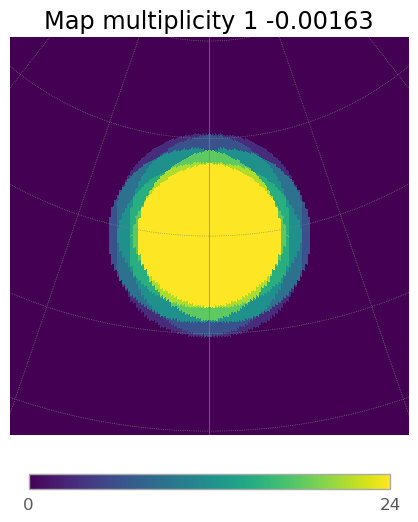

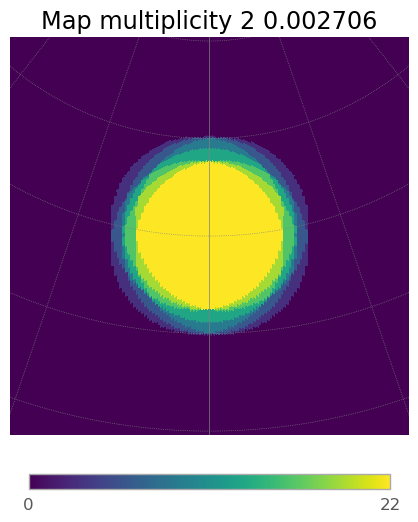

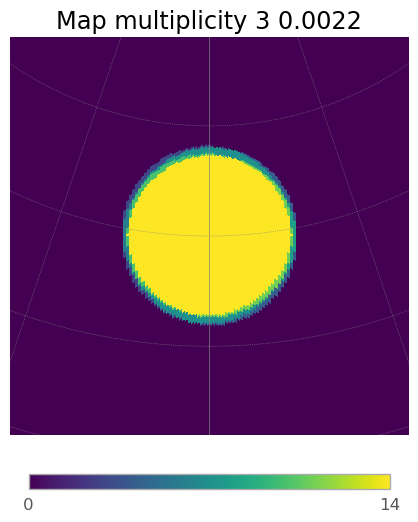

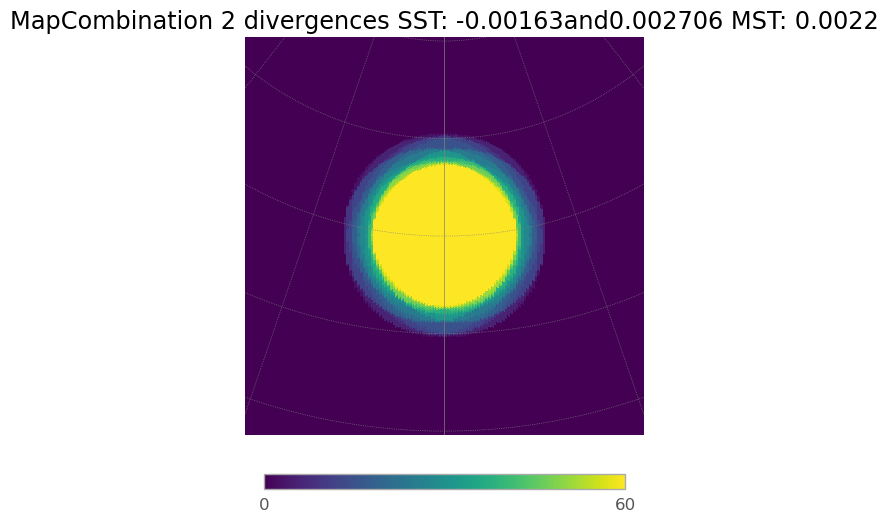

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.221888459954311 rad
-0.0 rad
1.2087209634084055 rad
-0.036609920612514585 rad
1.2088979499692634 rad
0.036609920612514585 rad
1.208572776043828 rad
-0.0 rad
1.2343956320561882 rad
0.03960711342202243 rad
1.2340446478846454 rad
-0.03960711342202243 rad
1.2348679690929507 rad
-0.0 rad


6it [00:00,  6.45it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.53it/s]
6it [00:00,  6.39it/s]


10.38234806580255


7it [00:01,  6.62it/s]
4it [00:00,  6.66it/s]


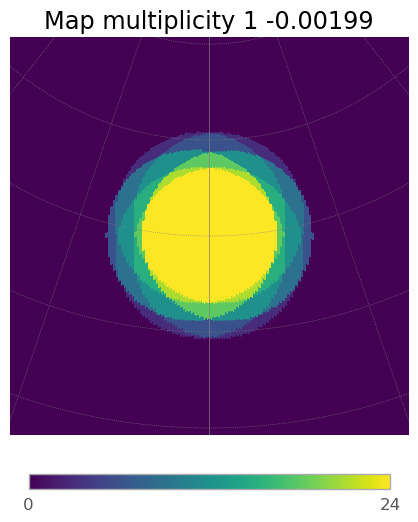

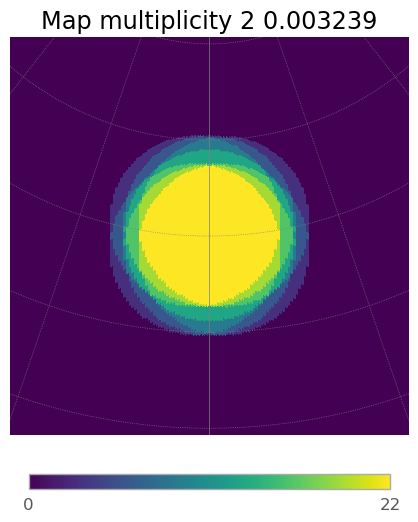

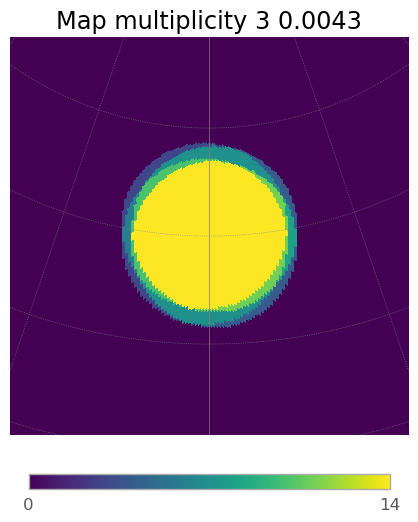

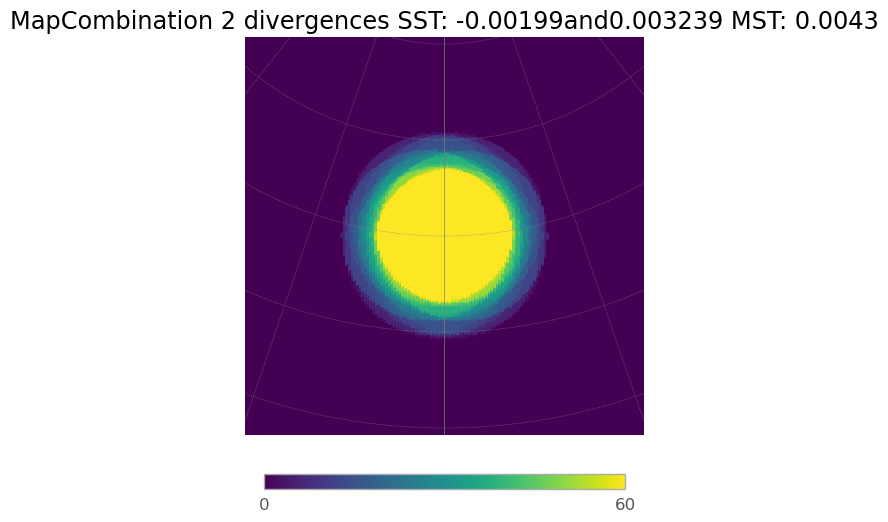

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219405205135656 rad
-0.0 rad
1.2043679838696495 rad
-0.04805403044207357 rad
1.2046055870020083 rad
0.04805403044207357 rad
1.2042642954675646 rad
-0.0 rad
1.2384757656555938 rad
0.053351356923524225 rad
1.2380139049082797 rad
-0.053351356923524225 rad
1.239222259531967 rad
-0.0 rad


6it [00:00,  6.53it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.51it/s]
6it [00:00,  6.32it/s]


10.6793351773081


7it [00:01,  6.45it/s]
4it [00:00,  6.54it/s]


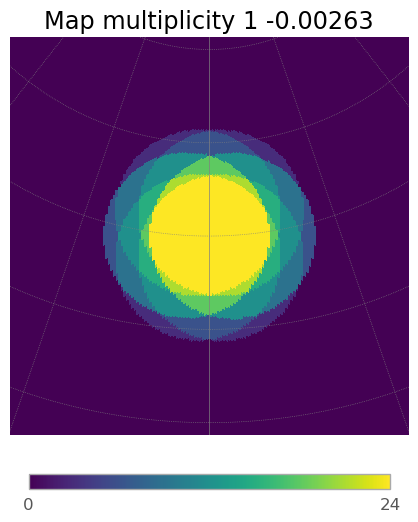

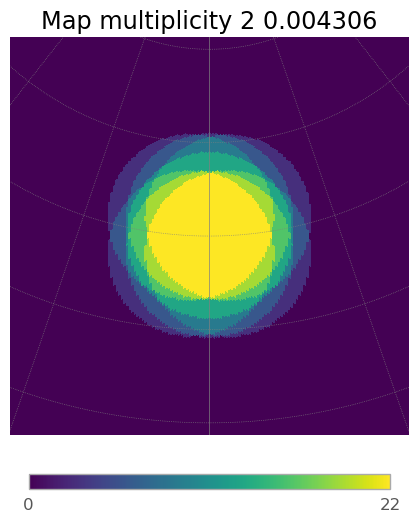

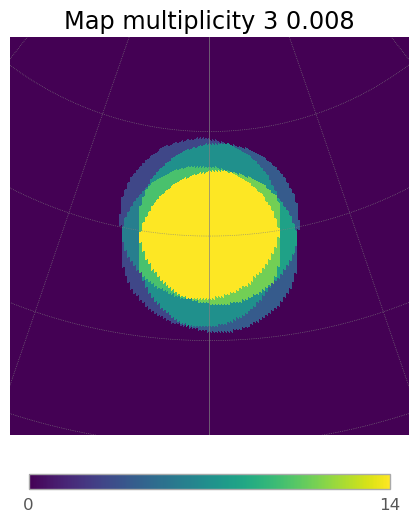

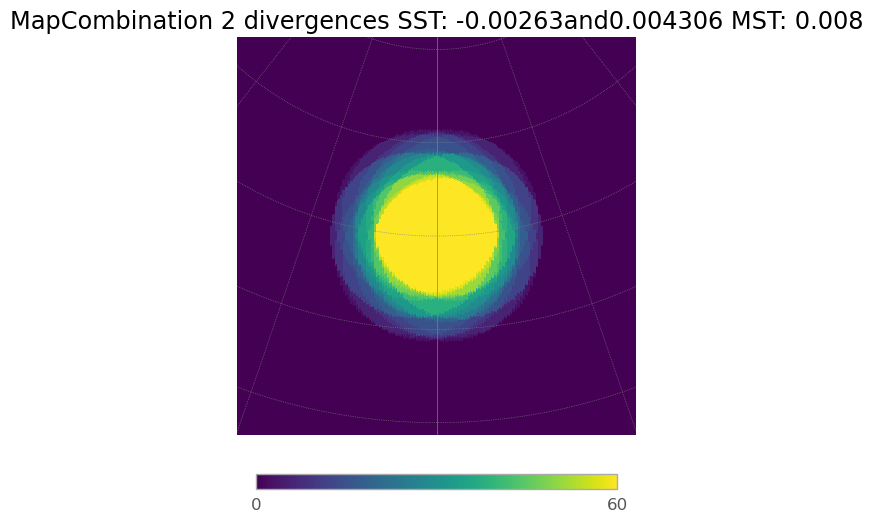

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219925410920676 rad
-0.0 rad
1.1999894962789355 rad
-0.059196827925015114 rad
1.2002888016517828 rad
0.059196827925015114 rad
1.1999728494703692 rad
-0.0 rad
1.2425018760800774 rad
0.06744208098811548 rad
1.2419315548119254 rad
-0.06744208098811548 rad
1.2435854333012433 rad
-0.0 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.45it/s]
4it [00:00,  5.92it/s]
6it [00:01,  5.94it/s]


10.976231771331125


7it [00:01,  6.72it/s]
4it [00:00,  6.55it/s]


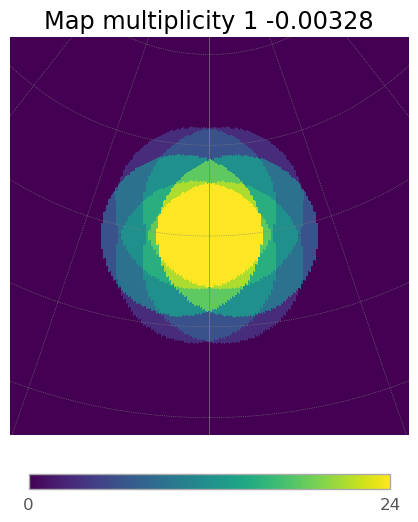

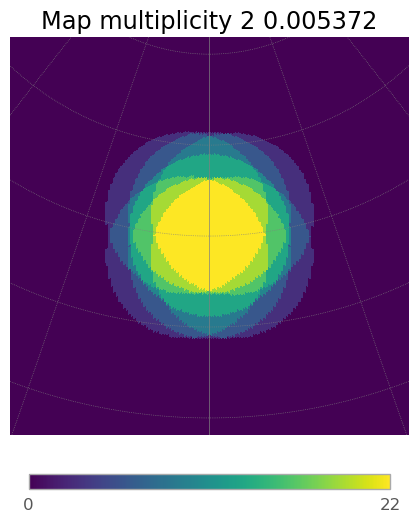

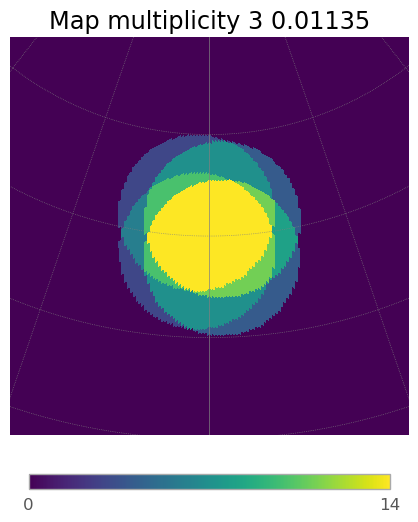

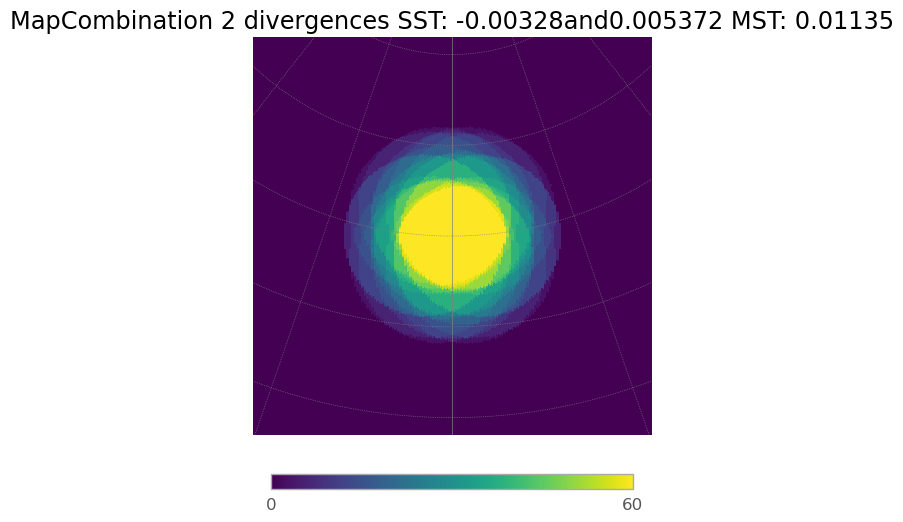

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2220393965776601 rad
-0.0 rad
1.1960228258340828 rad
-0.06898992731663664 rad
1.1963786721107101 rad
0.06898992731663664 rad
1.1961193194104527 rad
-0.0 rad
1.2460822994258114 rad
0.08044610486995292 rad
1.2454162566178253 rad
-0.08044610486995292 rad
1.2475257572206622 rad
-0.0 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.65it/s]
6it [00:00,  6.42it/s]


11.269389742337863


7it [00:01,  6.68it/s]
4it [00:00,  6.71it/s]


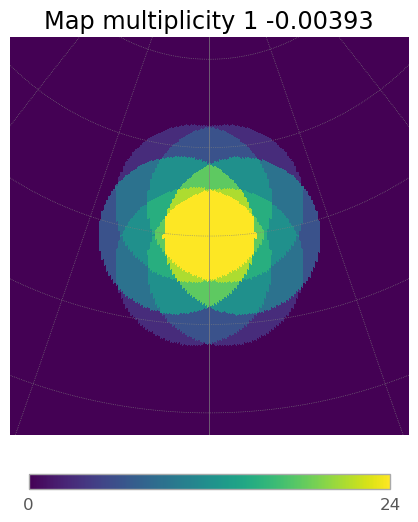

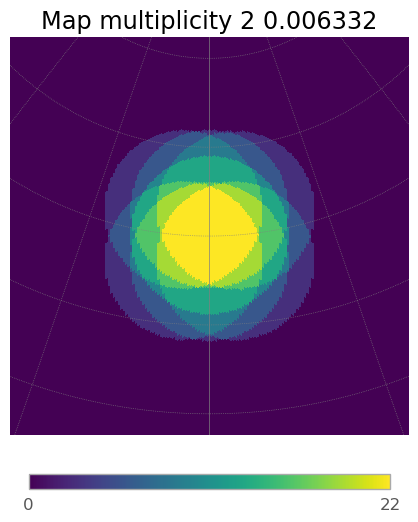

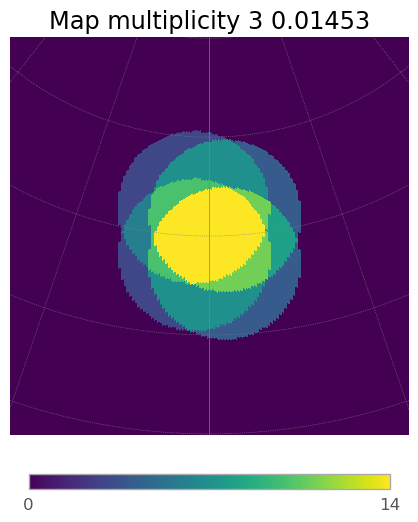

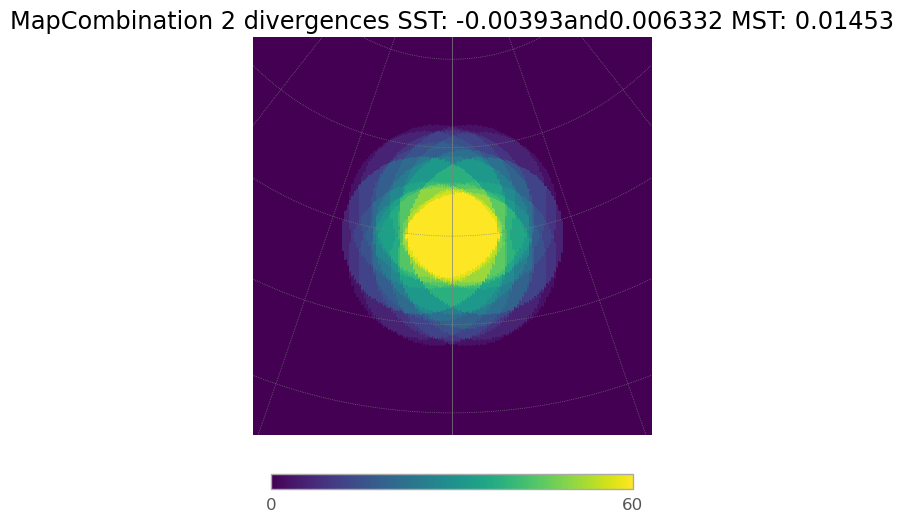

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2220914343883027 rad
-0.0 rad
1.1915938615129846 rad
-0.07960346760434411 rad
1.192013568695472 rad
0.07960346760434411 rad
1.1918527925969993 rad
-0.0 rad
1.2500049601462966 rad
0.09524283023757313 rad
1.2492347653179394 rad
-0.09524283023757313 rad
1.2519132977177918 rad
-0.0 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.70it/s]
4it [00:00,  6.57it/s]
6it [00:00,  6.14it/s]


11.592636396802419


7it [00:01,  6.43it/s]
4it [00:00,  5.93it/s]


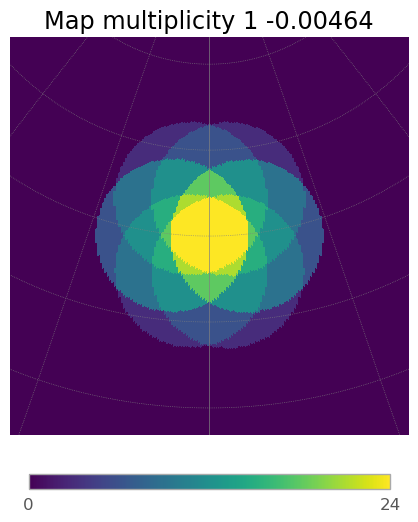

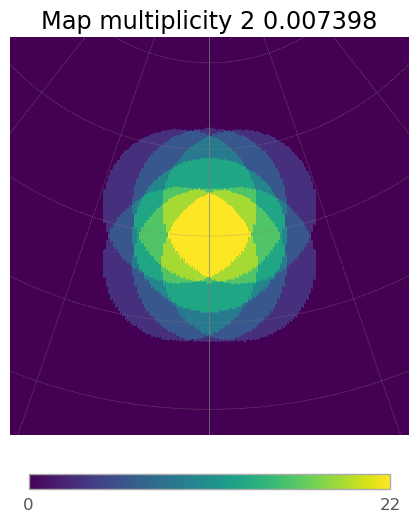

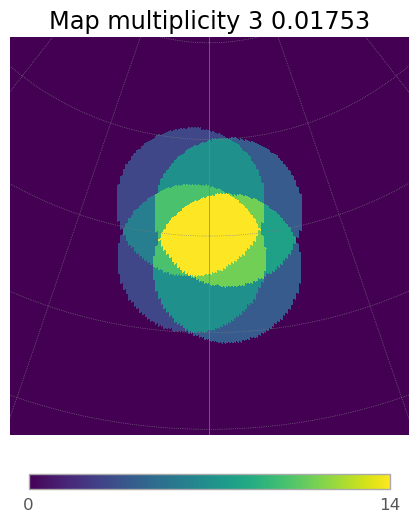

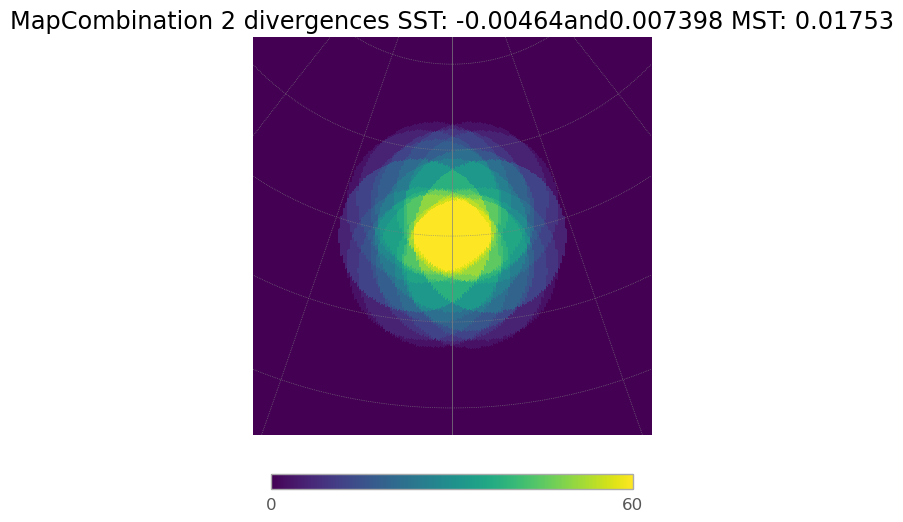

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.22213830568452 rad
-0.0 rad
1.1875849711580508 rad
-0.08893308535958383 rad
1.1880631537319706 rad
0.08893308535958383 rad
1.1880218351787895 rad
-0.0 rad
1.253487275561003 rad
0.10889608449624472 rad
1.2526251804783273 rad
-0.10889608449624472 rad
1.2558754069949192 rad
-0.0 rad


6it [00:00,  6.60it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.69it/s]
6it [00:00,  6.28it/s]


11.850976258994718


7it [00:01,  6.69it/s]
4it [00:00,  6.60it/s]


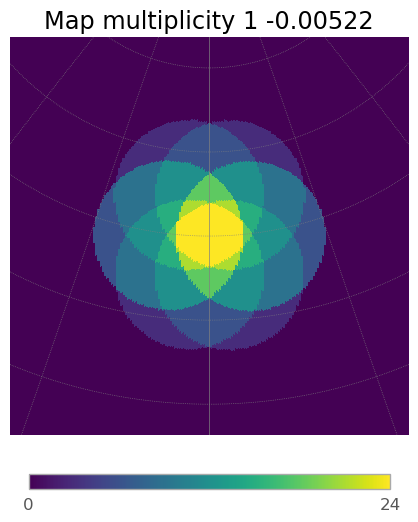

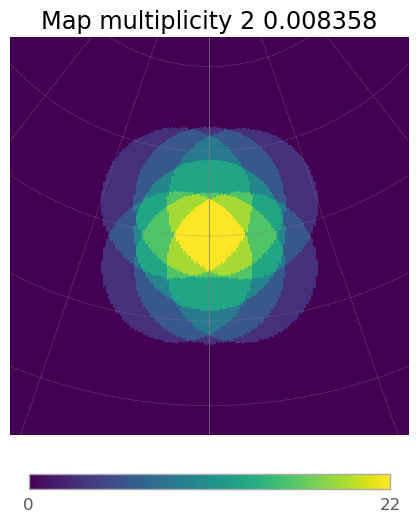

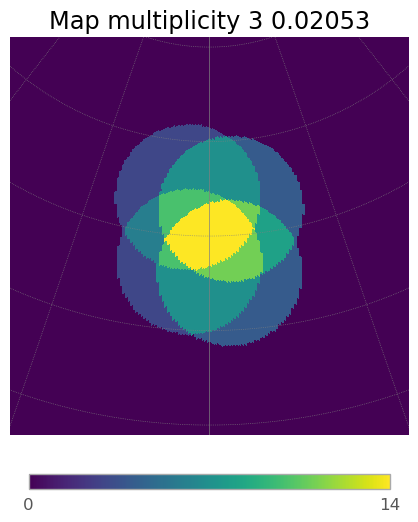

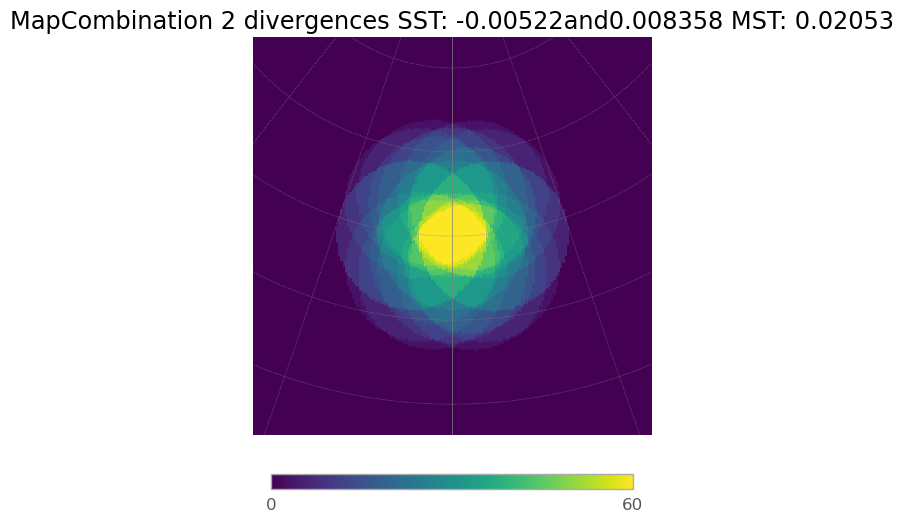

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2221747338946065 rad
-0.0 rad
1.1844573428167284 rad
-0.09603724377677618 rad
1.1849815931047125 rad
0.09603724377677618 rad
1.1850523056581892 rad
-0.0 rad
1.2561588810883966 rad
0.11972418598736674 rad
1.255226590868277 rad
-0.11972418598736674 rad
1.2589613489972387 rad
-0.0 rad


6it [00:00,  6.61it/s]
7it [00:01,  6.81it/s]
4it [00:00,  6.52it/s]
6it [00:00,  6.45it/s]


12.072235301050366


7it [00:01,  6.30it/s]
4it [00:00,  4.76it/s]


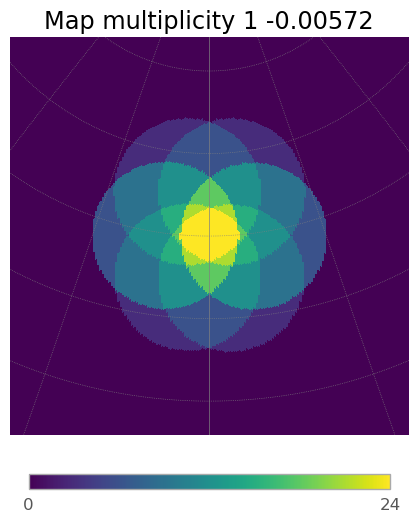

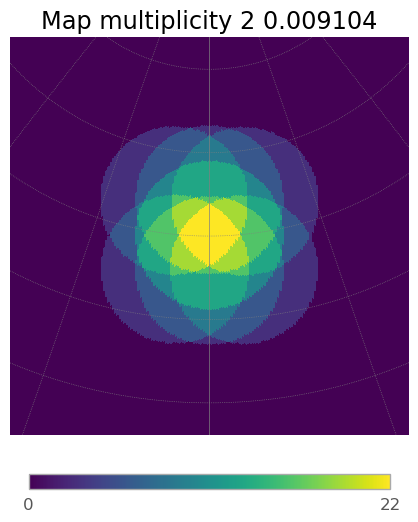

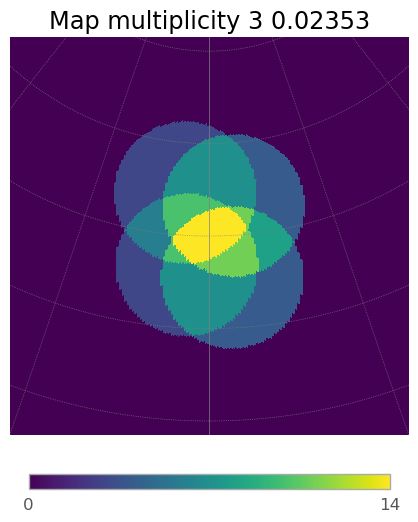

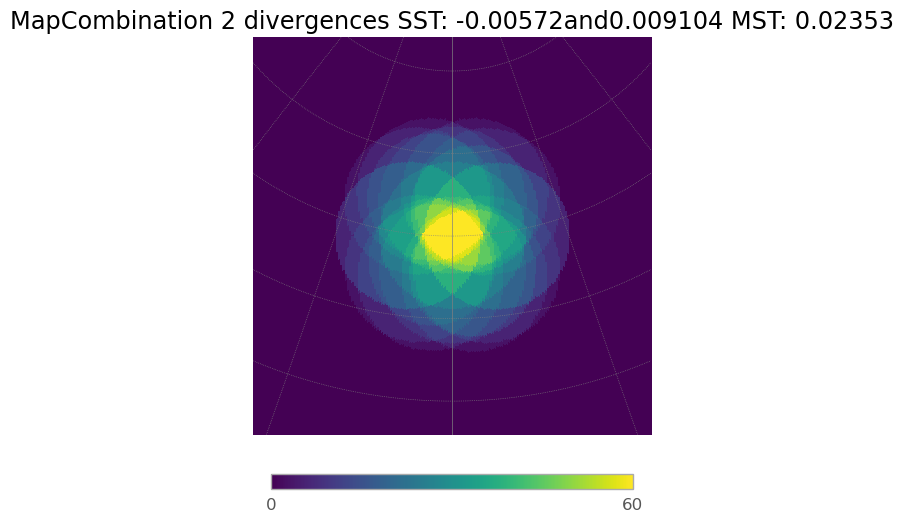

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2222216189575779 rad
-0.0 rad
1.1804176686152483 rad
-0.10499641412164623 rad
1.1810020039140456 rad
0.10499641412164623 rad
1.1812405515385156 rad
-0.0 rad
1.2595505938697407 rad
0.13394408617494552 rad
1.2585295117661943 rad
-0.13394408617494552 rad
1.262941548763078 rad
-0.0 rad


6it [00:00,  6.49it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.74it/s]
6it [00:00,  6.37it/s]


12.35860538741695


7it [00:01,  6.71it/s]
4it [00:00,  6.78it/s]


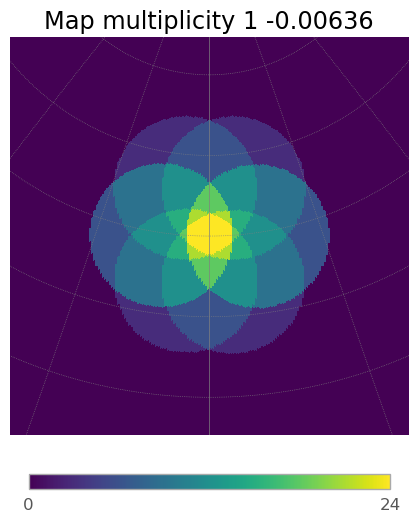

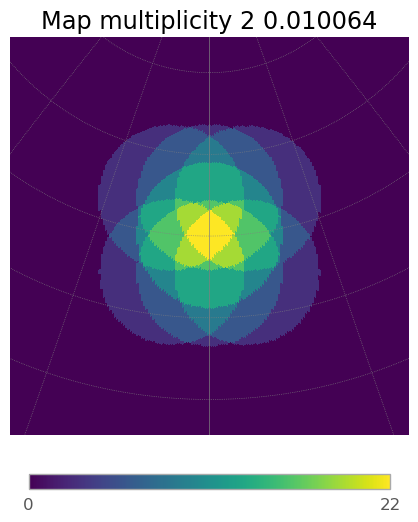

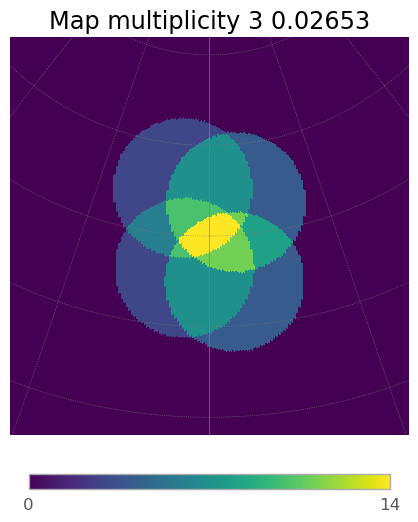

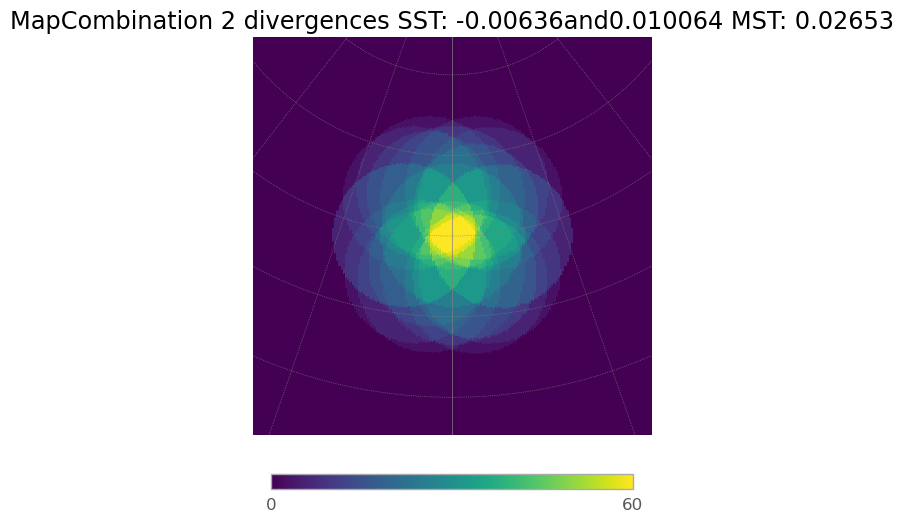

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2222632849383221 rad
-0.0 rad
1.1768151939895397 rad
-0.11278840550252259 rad
1.1774536694410078 rad
0.11278840550252259 rad
1.1778627772960317 rad
-0.0 rad
1.2625187600754133 rad
0.14685273326820486 rad
1.2614202076167047 rad
-0.14685273326820486 rad
1.2664865769709817 rad
-0.0 rad


6it [00:00,  6.65it/s]
7it [00:01,  6.81it/s]
4it [00:00,  6.87it/s]
6it [00:00,  6.49it/s]


12.57936498097892


7it [00:01,  6.76it/s]
4it [00:00,  6.72it/s]


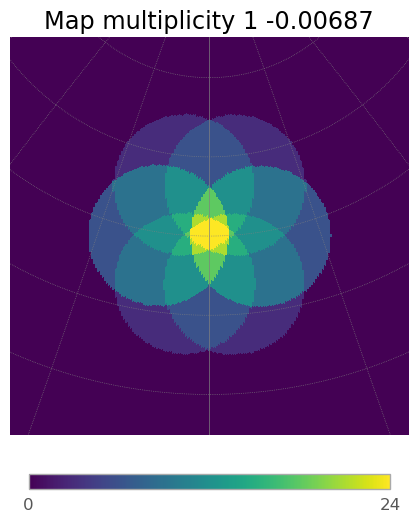

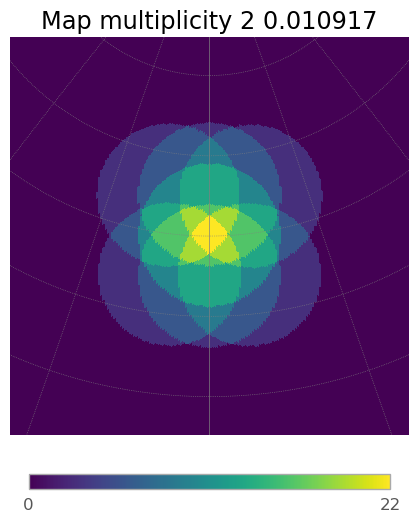

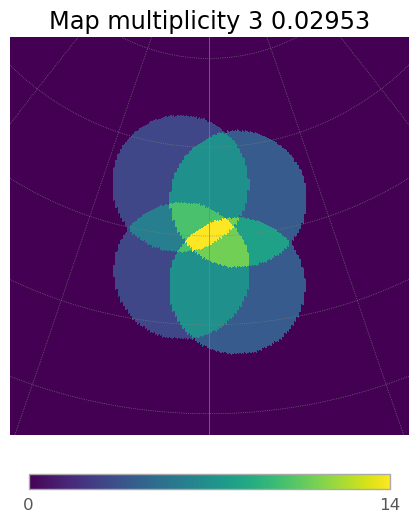

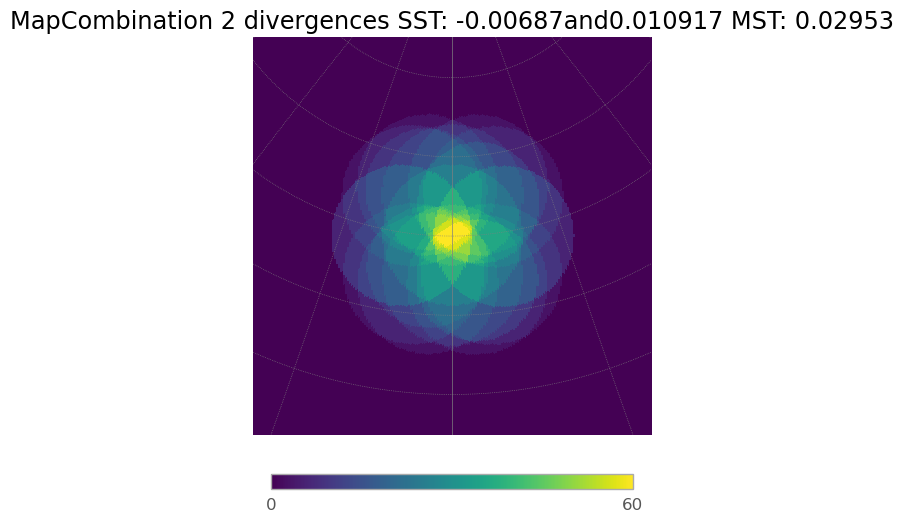

In [50]:
div_SST=divergence_list
conv_SST=convergence_list
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)



In [51]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)

6it [00:00,  6.42it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.53it/s]


(188.09357426974634, 18.670222408143346)

In [ ]:
div_SST=divergence_list
conv_SST=convergence_list
m_ave_combine=[]
hFoV_combine=[]
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    hFoV_combine.append(SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)[0])
    m_ave_combine.append(SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)[1])





The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2218624573189354 rad
-0.0 rad
1.2108836361986874 rad
-0.03078160673382785 rad
1.2110307721334481 rad
0.03078160673382785 rad
1.2107298449251078 rad
-0.0 rad
1.2323395321988817 rad
0.032873519754947594 rad
1.2320448092418865 rad
-0.032873519754947594 rad
1.2326977553647456 rad
-0.0 rad


6it [00:01,  5.97it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.54it/s]
6it [00:00,  6.32it/s]
7it [00:01,  6.44it/s]
4it [00:00,  6.37it/s]


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.221888459954311 rad
-0.0 rad
1.2087209634084055 rad
-0.036609920612514585 rad
1.2088979499692634 rad
0.036609920612514585 rad
1.208572776043828 rad
-0.0 rad
1.2343956320561882 rad
0.03960711342202243 rad
1.2340446478846454 rad
-0.03960711342202243 rad
1.2348679690929507 rad
-0.0 rad


1it [00:00,  6.02it/s]

In [54]:
hFoV_combine

[86.80132246332364,
 92.51901042132471,
 103.71833499961122,
 115.38976225332901,
 127.0087336542211,
 140.7259391681411,
 152.65964568598739,
 162.79673924455352,
 176.54017268488636,
 188.09357426974634]

In [55]:
m_ave_combine

[40.46336304577731,
 37.963855421686745,
 33.87090656214439,
 30.44175474485737,
 27.644398554465667,
 24.959463237349734,
 23.01202645820806,
 21.569034960528434,
 19.894592185410787,
 18.670222408143346]

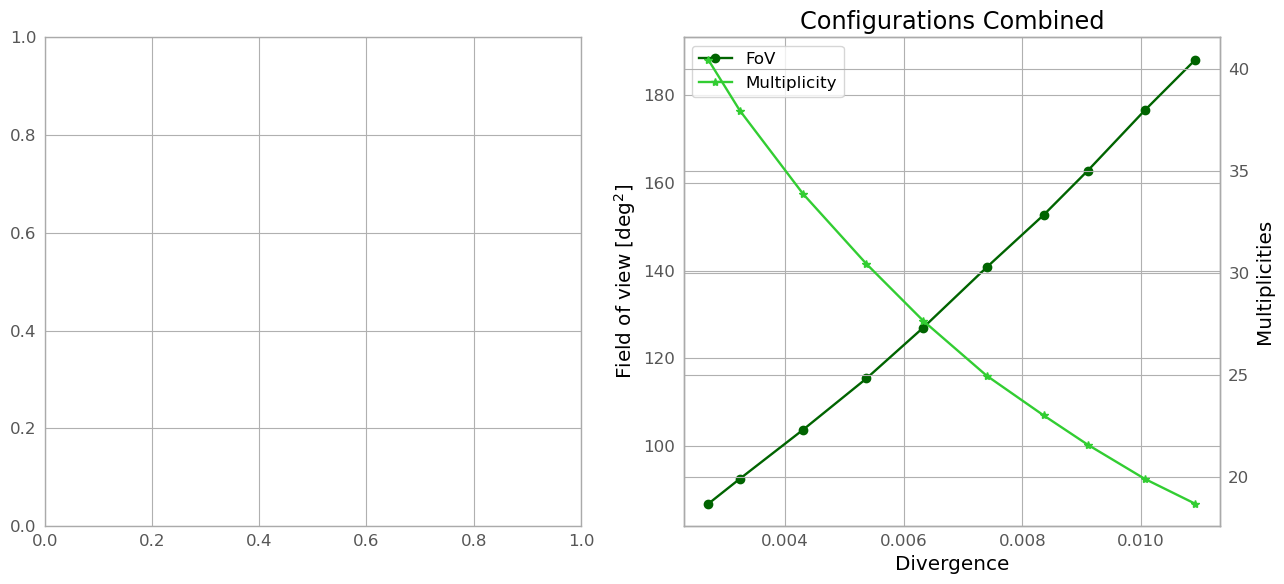

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6)) 
# Plot Full Array
# Full Array with m_cut = 3
#l1=axes[0].plot(chosen_divergences, FoV_full_array, label='FoV', marker='o', color='darkgreen')
#ax2 = axes[0].twinx()
#l2=ax2.plot(chosen_divergences, multiplicity_full_array, label='Multiplicities',marker='*', color='limegreen')
#axes[0].set_title('Full Array m_cut 3')
#axes[0].set_xlabel('Divergence')
#axes[0].set_ylabel('Field of view (m > 3) [deg$^2$]')
#ax2.set_ylabel('Multiplicities (m>3)')
#axeslegend = l1+l2
#axes[0].legend(axeslegend, [l.get_label() for l in axeslegend])



#Plot the ones for subarray 1
l1=axes[1].plot(divergence_list,hFoV_combine, label='FoV',marker='o', color='darkgreen')
ax5=axes[1].twinx()
l2=ax5.plot(divergence_list, m_ave_combine, label='Multiplicity', marker='*', color='limegreen')
axes[1].set_title('Configurations Combined')
axes[1].set_xlabel('Divergence')
axes[1].set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities')
axeslegend = l1+l2
axes[1].legend(axeslegend, [l.get_label() for l in axeslegend])
#Plot the ones for subarray 2

# Adjust layout
plt.tight_layout()
# Subarray 4
# Adjust layout
plt.show()

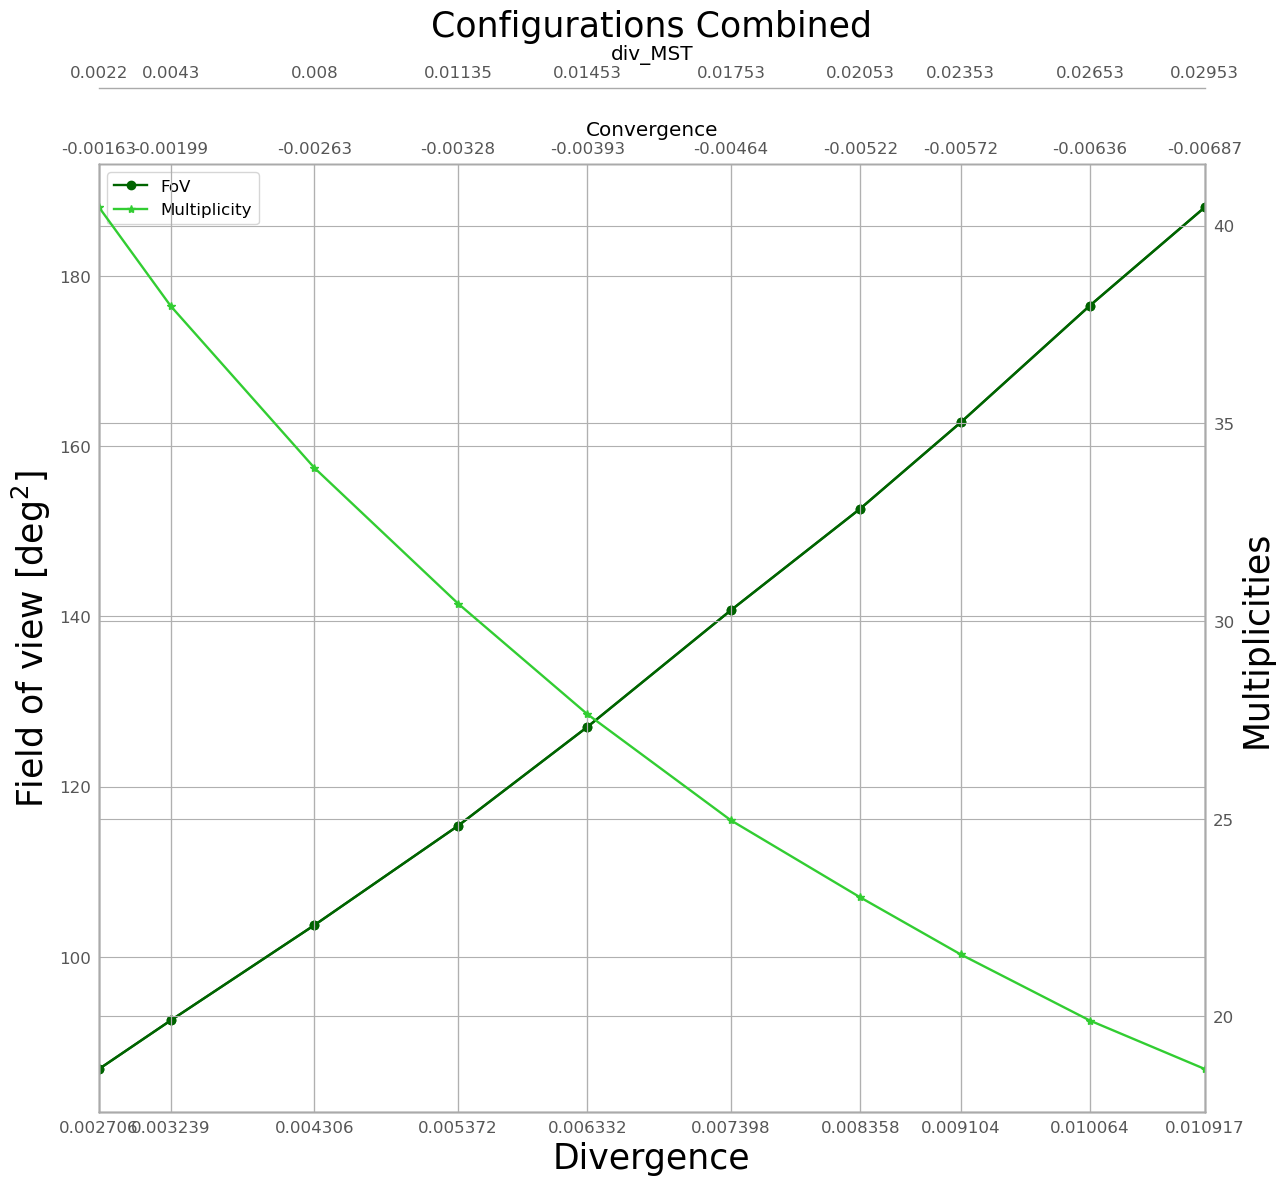

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(13, 12))
ax = axes

# -----------------------------
# Primary plot on ax (left y-axis)
# -----------------------------
l1 = ax.plot(divergence_list, hFoV_combine, label='FoV', marker='o', color='darkgreen')
ax.set_xlabel('Divergence', fontsize = 25)
ax.set_ylabel('Field of view [deg$^2$]', fontsize = 25)
ax.set_title('Configurations Combined', fontsize = 25)
ax.set_xticks(divergence_list)
ax.set_xlim(min(divergence_list), max(divergence_list))

# Create a twin x-axis for Convergence (top)
ax_top1 = ax.twiny()
ax_top1.set_xlabel('Convergence')
ax_top1.set_xticks(divergence_list)  # Use the same positions
ax_top1.set_xticklabels(convergence_list)  # Direct mapping
ax_top1.set_xlim(ax.get_xlim())

# Create a second twin x-axis for div_MST (offset further up)
ax_top2 = ax.twiny()
ax_top2.spines["top"].set_position(("axes", 1.08))  # Adjust this factor as needed
ax_top2.set_xlabel('div_MST')
ax_top2.set_xticks(divergence_list)
ax_top2.set_xticklabels(div_MST)
ax_top2.set_xlim(ax.get_xlim())
l1=ax.plot(divergence_list,hFoV_combine, label='FoV',marker='o',color='darkgreen')
ax5=ax.twinx()
l2=ax5.plot(divergence_list, m_ave_combine, label='Multiplicity', marker='*', color='limegreen')
ax.set_title('Configurations Combined', fontsize = 25)
ax.set_xlabel('Divergence')
ax.set_ylabel('Field of view [deg$^2$]')
ax5.set_ylabel('Multiplicities', fontsize = 25)
axeslegend = l1+l2
ax.legend(axeslegend, [l.get_label() for l in axeslegend])
plt.tight_layout()
plt.show()

In [58]:
print(SST_config_conv.barycenter)

[-1.10000000e-01 -1.89478063e-14  3.12916667e+01]


In [59]:
print(SST_config_div.barycenter)

[-1.15571429  0.         24.59571429]


In [60]:
print(full_array_config_SST.barycenter)

[-0.67307692  0.         27.68615385]


6it [00:00,  6.31it/s]
7it [00:01,  6.66it/s]
4it [00:00,  6.57it/s]
6it [00:00,  6.14it/s]


9.450044810959682


7it [00:01,  6.66it/s]
4it [00:00,  6.54it/s]


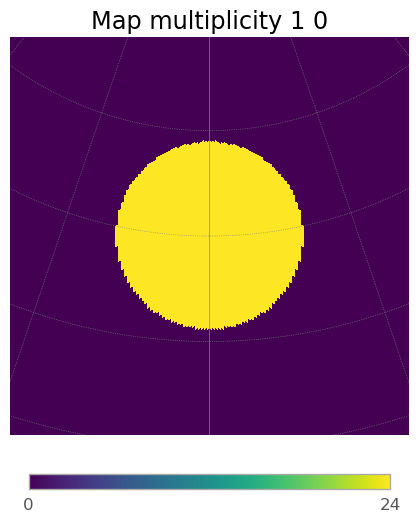

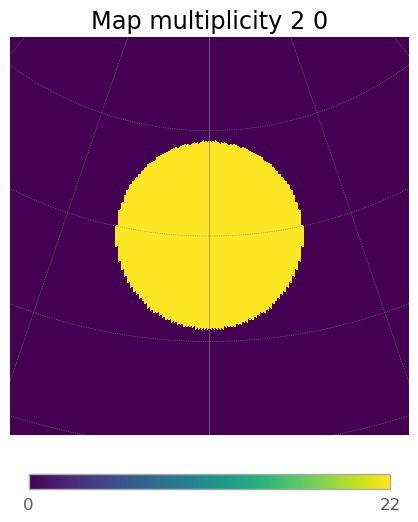

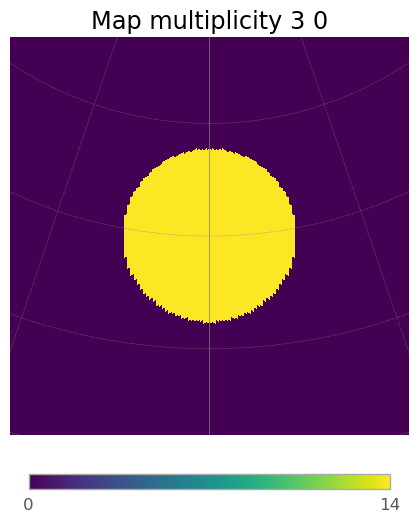

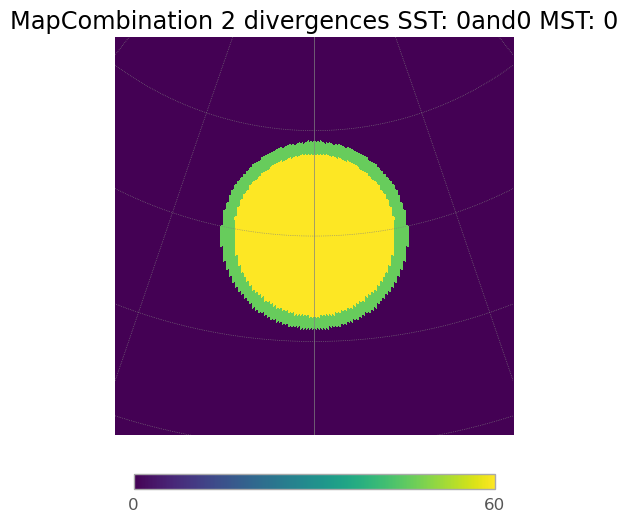

In [74]:
SST_config_conv.multiplicity_plot_3_config(array_2=SST_config_div,array_3=config_MST, subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3= number_of_telescopes_subarray_1)

In [ ]:
# it works becauase here I am seeing what part is each!

In [73]:
SST_config_conv.combiantion_of_FoV(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=45)


6it [00:00,  6.40it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.57it/s]


(15.789211700535075, 46.0)

In [85]:
hFoV_graph

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 15.789211700535075,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [89]:
j

60

In [90]:
(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=59)
[0])

6it [00:00,  6.39it/s]
7it [00:01,  6.04it/s]
4it [00:00,  6.61it/s]


46.42342975074266

In [91]:
hFoV_graph

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 15.789211700535075,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 46.42342975074266,
 0.0]

In [94]:
np.array(hFoV_graph).flatten()

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       15.7892117 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 46.42342975,
        0.        ])

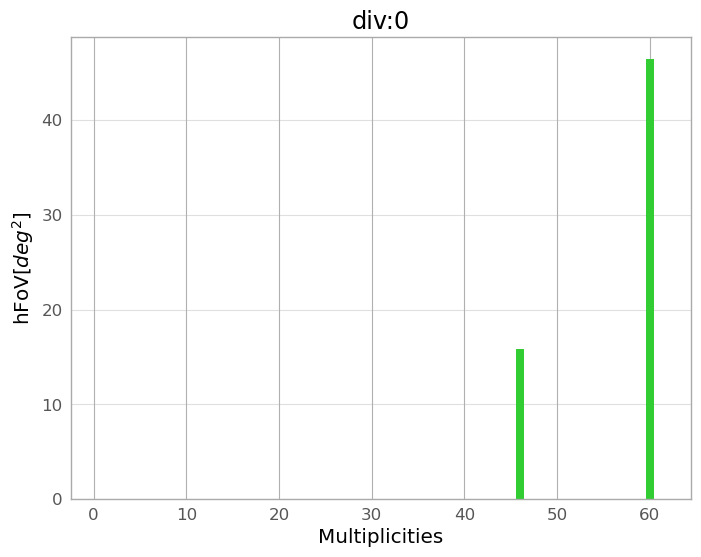

In [95]:
plt.figure(figsize=(8, 6)) 
plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
plt.xlabel("Multiplicities")
plt.ylabel("hFoV[$deg^2$]")
plt.title(f"div:{0}")
plt.grid(axis='y', alpha=0.4)
plt.show()   

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2218624573189354 rad
-0.0 rad
1.2108836361986874 rad
-0.03078160673382785 rad
1.2110307721334481 rad
0.03078160673382785 rad
1.2107298449251078 rad
-0.0 rad
1.2323395321988817 rad
0.032873519754947594 rad
1.2320448092418865 rad
-0.032873519754947594 rad
1.2326977553647456 rad
-0.0 rad


6it [00:00,  6.35it/s]
7it [00:01,  6.21it/s]
4it [00:00,  6.37it/s]
6it [00:00,  6.08it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.31it/s]
6it [00:00,  6.12it/s]
7it [00:01,  6.26it/s]
4it [00:00,  6.08it/s]
6it [00:01,  5.96it/s]
7it [00:01,  6.17it/s]
4it [00:00,  5.46it/s]
6it [00:00,  6.16it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.36it/s]
6it [00:01,  5.75it/s]
7it [00:01,  6.19it/s]
4it [00:00,  6.43it/s]
6it [00:00,  6.21it/s]
7it [00:01,  6.34it/s]
4it [00:00,  6.34it/s]
6it [00:00,  6.20it/s]
7it [00:01,  6.33it/s]
4it [00:00,  6.46it/s]
6it [00:00,  6.29it/s]
7it [00:01,  6.48it/s]
4it [00:00,  6.55it/s]
6it [00:00,  6.31it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.38it/s]
6it [00:00,  6.27it/s]
7it [00:01,  6.26it/s]
4it [00:00,  6.16it/s]
6it [00:00,  6.22it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.60it/s]
6it [00:00,  6.38it/s]
7it [00:01,  6.08it/s]
4it [00:00,  6.37it/s]
6it [00:01,  5.38it/s]
7it [00:01,  5.79it/s]
4it [00:00,  6.20it/s]
6it [00:00,  6.02it/s]
7it [00:01,

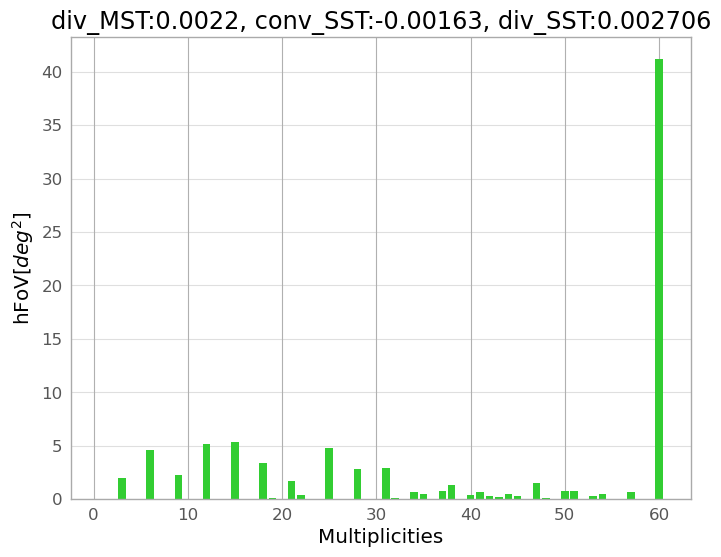

In [101]:
i=0
hFoV_graph=[]
multiplicities=[]
config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
SST_config_conv.divergent_pointing_2_div(complete_array=full_array_config_SST,tel_group_2=SST_config_div, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
#full_array.divergent_pointing(div=0.001, az=0, alt=70)

for j in range(60):
    hFoV_graph.append(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=j)
[0])
    multiplicities.append(j+1)
plt.figure(figsize=(8, 6)) 
plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
plt.xlabel("Multiplicities")
plt.ylabel("hFoV[$deg^2$]")
plt.title(f"div_MST:{div_MST[i]}, conv_SST:{conv_SST[i]}, div_SST:{div_SST[i]}")
plt.grid(axis='y', alpha=0.4)
plt.show()   



The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.221888459954311 rad
-0.0 rad
1.2087209634084055 rad
-0.036609920612514585 rad
1.2088979499692634 rad
0.036609920612514585 rad
1.208572776043828 rad
-0.0 rad
1.2343956320561882 rad
0.03960711342202243 rad
1.2340446478846454 rad
-0.03960711342202243 rad
1.2348679690929507 rad
-0.0 rad


6it [00:01,  4.99it/s]
7it [00:01,  4.84it/s]
4it [00:00,  5.28it/s]
6it [00:01,  5.17it/s]
7it [00:01,  5.07it/s]
4it [00:00,  5.16it/s]
6it [00:01,  5.01it/s]
7it [00:01,  5.43it/s]
4it [00:00,  5.19it/s]
6it [00:01,  4.22it/s]
7it [00:01,  4.55it/s]
4it [00:00,  4.14it/s]
6it [00:01,  4.83it/s]
7it [00:01,  4.81it/s]
4it [00:00,  4.69it/s]
6it [00:01,  3.02it/s]
7it [00:01,  4.54it/s]
4it [00:00,  4.60it/s]
6it [00:01,  4.79it/s]
7it [00:01,  4.74it/s]
4it [00:00,  4.07it/s]
6it [00:01,  4.37it/s]
7it [00:01,  4.72it/s]
4it [00:00,  4.61it/s]
6it [00:01,  4.83it/s]
7it [00:01,  4.93it/s]
4it [00:00,  4.94it/s]
6it [00:01,  4.70it/s]
7it [00:01,  4.30it/s]
4it [00:00,  4.20it/s]
6it [00:01,  4.40it/s]
7it [00:01,  4.53it/s]
4it [00:00,  4.84it/s]
6it [00:01,  4.31it/s]
7it [00:01,  4.63it/s]
4it [00:00,  4.59it/s]
6it [00:01,  4.72it/s]
7it [00:01,  4.84it/s]
4it [00:00,  4.77it/s]
6it [00:01,  4.51it/s]
7it [00:01,  4.65it/s]
4it [00:00,  4.50it/s]
6it [00:01,  4.56it/s]
7it [00:01,

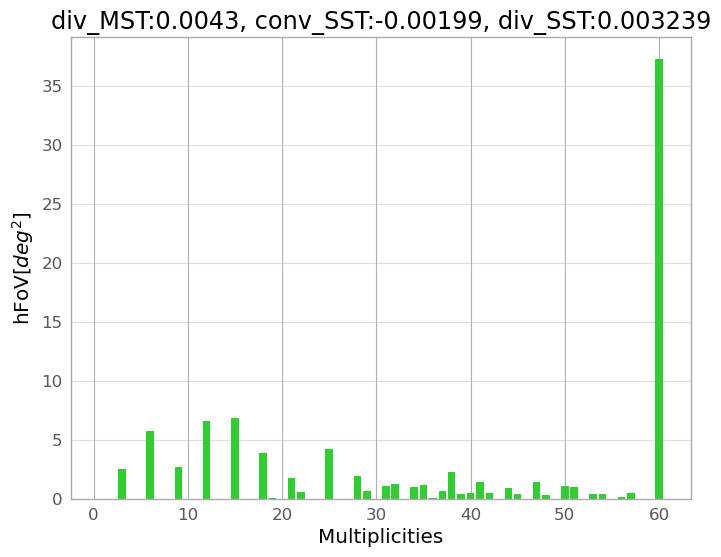

In [102]:
i=1
hFoV_graph=[]
multiplicities=[]
config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
SST_config_conv.divergent_pointing_2_div(complete_array=full_array_config_SST,tel_group_2=SST_config_div, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
#full_array.divergent_pointing(div=0.001, az=0, alt=70)

for j in range(60):
    hFoV_graph.append(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=j)
[0])
    multiplicities.append(j+1)
plt.figure(figsize=(8, 6)) 
plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
plt.xlabel("Multiplicities")
plt.ylabel("hFoV[$deg^2$]")
plt.title(f"div_MST:{div_MST[i]}, conv_SST:{conv_SST[i]}, div_SST:{div_SST[i]}")
plt.grid(axis='y', alpha=0.4)
plt.show()   


In [ ]:
i=2
hFoV_graph=[]
multiplicities=[]
config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
SST_config_conv.divergent_pointing_2_div(complete_array=full_array_config_SST,tel_group_2=SST_config_div, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
#full_array.divergent_pointing(div=0.001, az=0, alt=70)

for j in range(60):
    hFoV_graph.append(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=j)
[0])
    multiplicities.append(j+1)
plt.figure(figsize=(8, 6)) 
plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
plt.xlabel("Multiplicities")
plt.ylabel("hFoV[$deg^2$]")
plt.title(f"div_MST:{div_MST[i]}, conv_SST:{conv_SST[i]}, div_SST:{div_SST[i]}")
plt.grid(axis='y', alpha=0.4)
plt.show()   


The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219405205135656 rad
-0.0 rad
1.2043679838696495 rad
-0.04805403044207357 rad
1.2046055870020083 rad
0.04805403044207357 rad
1.2042642954675646 rad
-0.0 rad
1.2384757656555938 rad
0.053351356923524225 rad
1.2380139049082797 rad
-0.053351356923524225 rad
1.239222259531967 rad
-0.0 rad


6it [00:01,  5.05it/s]
7it [00:01,  4.72it/s]
4it [00:00,  4.41it/s]
6it [00:02,  2.96it/s]
7it [00:01,  4.38it/s]
4it [00:00,  4.45it/s]
6it [00:01,  4.68it/s]
7it [00:01,  5.25it/s]
4it [00:00,  4.53it/s]
6it [00:01,  4.90it/s]
7it [00:01,  4.99it/s]
4it [00:00,  5.07it/s]
6it [00:01,  5.11it/s]
7it [00:01,  5.15it/s]
4it [00:00,  4.36it/s]
6it [00:01,  4.45it/s]
7it [00:01,  4.92it/s]
4it [00:01,  3.94it/s]
6it [00:01,  4.39it/s]
7it [00:01,  4.75it/s]
4it [00:00,  5.09it/s]
6it [00:01,  5.18it/s]
7it [00:01,  5.11it/s]
4it [00:00,  5.01it/s]
6it [00:01,  4.73it/s]
7it [00:01,  4.95it/s]
4it [00:00,  4.91it/s]
6it [00:01,  4.91it/s]
7it [00:02,  3.06it/s]
4it [00:01,  3.76it/s]
6it [00:01,  3.88it/s]
7it [00:01,  4.59it/s]
4it [00:00,  4.52it/s]
6it [00:01,  4.30it/s]
7it [00:01,  4.85it/s]
4it [00:00,  4.40it/s]
6it [00:01,  3.79it/s]
7it [00:01,  4.81it/s]
4it [00:00,  4.68it/s]
6it [00:01,  4.73it/s]
7it [00:01,  5.16it/s]
4it [00:00,  4.92it/s]
6it [00:01,  4.85it/s]
7it [00:01,

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219925410920676 rad
-0.0 rad
1.1999894962789355 rad
-0.059196827925015114 rad
1.2002888016517828 rad
0.059196827925015114 rad
1.1999728494703692 rad
-0.0 rad
1.2425018760800774 rad
0.06744208098811548 rad
1.2419315548119254 rad
-0.06744208098811548 rad
1.2435854333012433 rad
-0.0 rad


6it [00:01,  3.29it/s]
7it [00:01,  4.33it/s]
4it [00:00,  4.90it/s]
6it [00:01,  4.95it/s]
7it [00:01,  5.10it/s]
4it [00:00,  5.07it/s]
6it [00:01,  3.93it/s]
7it [00:01,  4.30it/s]
4it [00:01,  3.26it/s]
6it [00:01,  4.35it/s]
7it [00:01,  4.66it/s]
4it [00:01,  3.78it/s]
6it [00:01,  4.01it/s]
7it [00:01,  4.53it/s]
4it [00:00,  4.66it/s]
6it [00:01,  4.51it/s]
7it [00:01,  4.70it/s]
4it [00:00,  4.98it/s]
6it [00:01,  4.70it/s]
7it [00:02,  3.37it/s]
4it [00:00,  4.26it/s]
6it [00:01,  4.32it/s]
7it [00:01,  4.60it/s]
4it [00:00,  4.84it/s]
6it [00:01,  4.86it/s]
7it [00:01,  4.75it/s]
4it [00:00,  4.92it/s]
6it [00:01,  4.59it/s]
7it [00:01,  4.97it/s]
4it [00:00,  5.14it/s]
6it [00:01,  4.74it/s]
7it [00:01,  4.34it/s]
4it [00:00,  4.50it/s]
6it [00:01,  4.23it/s]
7it [00:01,  4.57it/s]
4it [00:00,  4.46it/s]
6it [00:01,  4.71it/s]
7it [00:01,  4.65it/s]
4it [00:00,  4.26it/s]
6it [00:01,  3.91it/s]
7it [00:01,  4.99it/s]
4it [00:00,  4.52it/s]
6it [00:01,  3.88it/s]
7it [00:01,

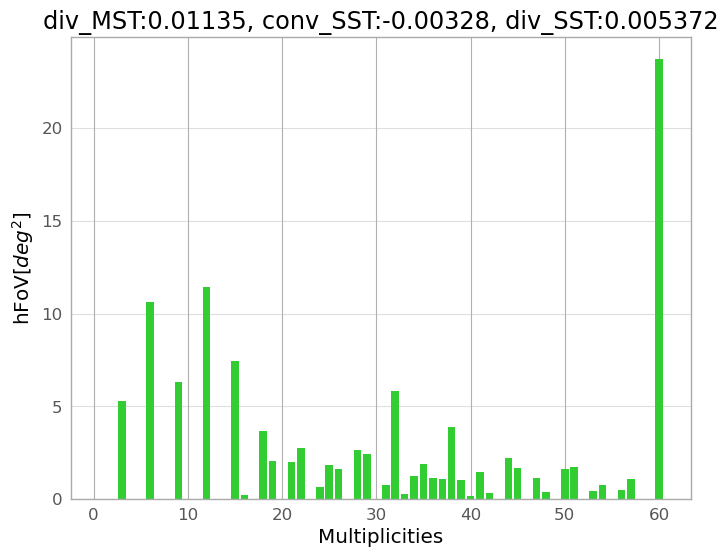

In [103]:
i=3
hFoV_graph=[]
multiplicities=[]
config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
SST_config_conv.divergent_pointing_2_div(complete_array=full_array_config_SST,tel_group_2=SST_config_div, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
#full_array.divergent_pointing(div=0.001, az=0, alt=70)

for j in range(60):
    hFoV_graph.append(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=j)
[0])
    multiplicities.append(j+1)
plt.figure(figsize=(8, 6)) 
plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
plt.xlabel("Multiplicities")
plt.ylabel("hFoV[$deg^2$]")
plt.title(f"div_MST:{div_MST[i]}, conv_SST:{conv_SST[i]}, div_SST:{div_SST[i]}")
plt.grid(axis='y', alpha=0.4)
plt.show() 

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2222632849383221 rad
-0.0 rad
1.1768151939895397 rad
-0.11278840550252259 rad
1.1774536694410078 rad
0.11278840550252259 rad
1.1778627772960317 rad
-0.0 rad
1.2625187600754133 rad
0.14685273326820486 rad
1.2614202076167047 rad
-0.14685273326820486 rad
1.2664865769709817 rad
-0.0 rad


6it [00:01,  5.85it/s]
7it [00:01,  5.52it/s]
4it [00:00,  5.28it/s]
6it [00:01,  5.64it/s]
7it [00:01,  5.63it/s]
4it [00:00,  5.45it/s]
6it [00:01,  5.02it/s]
7it [00:01,  5.26it/s]
4it [00:00,  5.18it/s]
6it [00:01,  5.35it/s]
7it [00:01,  5.32it/s]
4it [00:00,  5.35it/s]
6it [00:01,  5.00it/s]
7it [00:01,  5.14it/s]
4it [00:00,  5.21it/s]
6it [00:01,  4.69it/s]
7it [00:01,  5.54it/s]
4it [00:00,  5.13it/s]
6it [00:01,  5.31it/s]
7it [00:01,  5.57it/s]
4it [00:00,  5.62it/s]
6it [00:01,  4.52it/s]
7it [00:02,  3.14it/s]
4it [00:00,  4.39it/s]
6it [00:01,  4.95it/s]
7it [00:01,  5.04it/s]
4it [00:00,  5.08it/s]
6it [00:01,  4.90it/s]
7it [00:01,  5.34it/s]
4it [00:00,  5.24it/s]
6it [00:01,  4.76it/s]
7it [00:01,  5.18it/s]
4it [00:00,  5.36it/s]
6it [00:01,  5.30it/s]
7it [00:01,  5.36it/s]
4it [00:00,  5.28it/s]
6it [00:01,  4.60it/s]
7it [00:01,  5.01it/s]
4it [00:00,  5.21it/s]
6it [00:01,  5.15it/s]
7it [00:01,  5.36it/s]
4it [00:00,  5.25it/s]
6it [00:01,  4.44it/s]
7it [00:01,

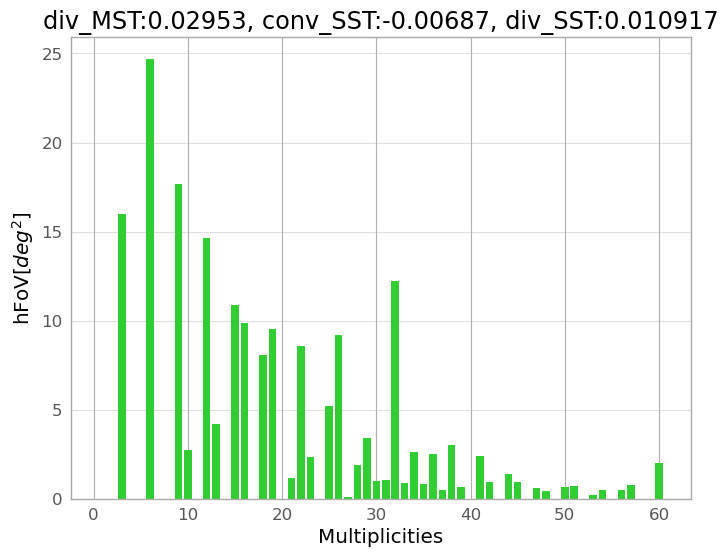

In [105]:
i=9
hFoV_graph=[]
multiplicities=[]
config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
SST_config_conv.divergent_pointing_2_div(complete_array=full_array_config_SST,tel_group_2=SST_config_div, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
#full_array.divergent_pointing(div=0.001, az=0, alt=70)

for j in range(60):
    hFoV_graph.append(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=j)
[0])
    multiplicities.append(j+1)
plt.figure(figsize=(8, 6)) 
plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
plt.xlabel("Multiplicities")
plt.ylabel("hFoV[$deg^2$]")
plt.title(f"div_MST:{div_MST[i]}, conv_SST:{conv_SST[i]}, div_SST:{div_SST[i]}")
plt.grid(axis='y', alpha=0.4)
plt.show() 

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2218624573189354 rad
-0.0 rad
1.2108836361986874 rad
-0.03078160673382785 rad
1.2110307721334481 rad
0.03078160673382785 rad
1.2107298449251078 rad
-0.0 rad
1.2323395321988817 rad
0.032873519754947594 rad
1.2320448092418865 rad
-0.032873519754947594 rad
1.2326977553647456 rad
-0.0 rad
0


6it [00:00,  6.30it/s]
7it [00:01,  6.33it/s]
4it [00:00,  6.40it/s]
6it [00:00,  6.55it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.54it/s]


(0.0, nan)


6it [00:00,  6.50it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.25it/s]


1


6it [00:00,  6.33it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.16it/s]
6it [00:00,  6.24it/s]
7it [00:01,  6.32it/s]
4it [00:00,  6.33it/s]


(0.0, nan)


6it [00:00,  6.19it/s]
7it [00:01,  6.32it/s]
4it [00:00,  6.38it/s]


2


6it [00:01,  5.45it/s]
7it [00:01,  6.03it/s]
4it [00:00,  6.41it/s]
6it [00:00,  6.24it/s]
7it [00:01,  6.48it/s]
4it [00:00,  6.45it/s]


(2.0064363705829455, 3.0)


6it [00:00,  6.40it/s]
7it [00:01,  6.49it/s]
4it [00:00,  5.32it/s]


3


6it [00:00,  6.26it/s]
7it [00:01,  6.21it/s]
4it [00:00,  6.27it/s]
6it [00:00,  6.32it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.31it/s]


(0.0, nan)


6it [00:00,  6.35it/s]
7it [00:01,  6.30it/s]
4it [00:00,  6.19it/s]


4


6it [00:01,  5.77it/s]
7it [00:01,  6.23it/s]
4it [00:00,  6.44it/s]
6it [00:00,  6.43it/s]
7it [00:01,  6.32it/s]
4it [00:00,  6.33it/s]


(0.0, nan)


6it [00:00,  6.42it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.09it/s]


5


6it [00:00,  6.00it/s]
7it [00:01,  6.22it/s]
4it [00:00,  5.93it/s]
6it [00:00,  6.11it/s]
7it [00:01,  6.38it/s]
4it [00:00,  6.31it/s]


(4.603001085454993, 6.0)


6it [00:01,  4.19it/s]
7it [00:01,  6.30it/s]
4it [00:00,  6.38it/s]


6


6it [00:00,  6.44it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.26it/s]
6it [00:00,  6.32it/s]
7it [00:01,  6.54it/s]
4it [00:00,  5.99it/s]


(0.0, nan)


6it [00:00,  6.06it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.42it/s]


7


6it [00:00,  6.36it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.52it/s]
6it [00:00,  6.31it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.55it/s]


(0.0, nan)


6it [00:00,  6.40it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.33it/s]


8


6it [00:01,  5.98it/s]
7it [00:01,  5.81it/s]
4it [00:00,  6.26it/s]
6it [00:00,  6.16it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.18it/s]


(2.2687156347114352, 9.0)


6it [00:00,  6.38it/s]
7it [00:01,  6.67it/s]
4it [00:00,  6.55it/s]


9


6it [00:00,  6.45it/s]
7it [00:01,  6.33it/s]
4it [00:00,  6.45it/s]
6it [00:00,  6.46it/s]
7it [00:01,  6.60it/s]
4it [00:00,  6.38it/s]


(0.0, nan)


6it [00:00,  6.53it/s]
7it [00:01,  6.60it/s]
4it [00:00,  6.61it/s]


10


6it [00:00,  6.45it/s]
7it [00:01,  6.76it/s]
4it [00:00,  6.47it/s]
6it [00:00,  6.50it/s]
7it [00:01,  6.60it/s]
4it [00:00,  6.41it/s]


(0.0, nan)


6it [00:00,  6.39it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.59it/s]


11


6it [00:00,  6.40it/s]
7it [00:01,  6.47it/s]
4it [00:00,  5.86it/s]
6it [00:01,  5.75it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.43it/s]


(5.18001546653767, 12.0)


6it [00:00,  6.42it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.54it/s]


12


6it [00:00,  6.54it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.50it/s]
6it [00:00,  6.46it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.51it/s]


(0.0, nan)


6it [00:00,  6.29it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.53it/s]


13


6it [00:00,  6.43it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.38it/s]
6it [00:00,  6.54it/s]
7it [00:01,  6.38it/s]
4it [00:00,  6.63it/s]


(0.0, nan)


6it [00:00,  6.48it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.36it/s]


14


6it [00:00,  6.52it/s]
7it [00:01,  6.69it/s]
4it [00:00,  6.55it/s]
6it [00:00,  6.15it/s]
7it [00:01,  5.88it/s]
4it [00:00,  6.51it/s]


(5.337383025014764, 15.0)


6it [00:00,  6.35it/s]
7it [00:01,  6.64it/s]
4it [00:00,  6.59it/s]


15


6it [00:00,  6.53it/s]
7it [00:01,  6.66it/s]
4it [00:00,  6.59it/s]
6it [00:00,  6.35it/s]
7it [00:01,  6.39it/s]
4it [00:00,  6.45it/s]


(0.0, nan)


6it [00:00,  6.46it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.57it/s]


16


6it [00:00,  6.47it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.60it/s]
6it [00:00,  6.35it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.61it/s]


(0.0, nan)


6it [00:00,  6.46it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.45it/s]


17


6it [00:01,  5.35it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.53it/s]
6it [00:00,  6.57it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.23it/s]


(3.3440606176382426, 18.0)


6it [00:00,  6.50it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.54it/s]


18


6it [00:00,  6.58it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.50it/s]
6it [00:00,  6.58it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.59it/s]


(0.07868377923854689, 19.0)


6it [00:00,  6.46it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.35it/s]


19


6it [00:00,  6.44it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.38it/s]
6it [00:00,  6.59it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.70it/s]


(0.0, nan)


6it [00:00,  6.53it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.38it/s]


20


6it [00:00,  6.42it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.66it/s]
6it [00:00,  6.62it/s]
7it [00:01,  6.60it/s]
4it [00:00,  6.53it/s]


(1.717929180041607, 21.0)


6it [00:00,  6.26it/s]
7it [00:01,  5.84it/s]
4it [00:00,  5.62it/s]


21


6it [00:00,  6.19it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.60it/s]
6it [00:00,  6.27it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.43it/s]


(0.36719096977988547, 22.0)


6it [00:00,  6.25it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.36it/s]


22


6it [00:00,  6.11it/s]
7it [00:01,  6.16it/s]
4it [00:00,  6.45it/s]
6it [00:00,  6.36it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.44it/s]


(0.0, nan)


6it [00:00,  6.30it/s]
7it [00:01,  6.55it/s]
4it [00:00,  6.43it/s]


23


6it [00:00,  6.34it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.20it/s]
6it [00:00,  6.41it/s]
7it [00:01,  6.34it/s]
4it [00:00,  6.31it/s]


(0.0, nan)


6it [00:01,  5.95it/s]
7it [00:01,  6.20it/s]
4it [00:00,  6.04it/s]


24


6it [00:00,  6.09it/s]
7it [00:01,  6.17it/s]
4it [00:00,  6.31it/s]
6it [00:00,  6.24it/s]
7it [00:01,  6.42it/s]
4it [00:00,  6.64it/s]


(4.79971053355136, 25.0)


6it [00:00,  6.55it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.41it/s]


25


6it [00:00,  6.45it/s]
7it [00:01,  6.25it/s]
4it [00:00,  6.55it/s]
6it [00:00,  6.47it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.42it/s]


(0.0, nan)


6it [00:00,  6.47it/s]
7it [00:01,  6.48it/s]
4it [00:00,  6.27it/s]


26


6it [00:00,  6.29it/s]
7it [00:01,  6.43it/s]
4it [00:00,  6.56it/s]
6it [00:00,  6.14it/s]
7it [00:01,  5.02it/s]
4it [00:00,  6.23it/s]


(0.0, nan)


6it [00:00,  6.32it/s]
7it [00:01,  6.33it/s]
4it [00:00,  5.57it/s]


27


6it [00:00,  6.02it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.36it/s]
6it [00:00,  6.28it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.29it/s]


(2.78016019976199, 28.0)


6it [00:00,  6.50it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.53it/s]


28


6it [00:00,  6.45it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.56it/s]
6it [00:00,  6.63it/s]
7it [00:01,  6.60it/s]
4it [00:00,  6.66it/s]


(0.0, nan)


6it [00:00,  6.43it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.12it/s]


29


6it [00:00,  6.44it/s]
7it [00:01,  6.39it/s]
4it [00:00,  6.23it/s]
6it [00:00,  6.00it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.43it/s]


(0.0, nan)


6it [00:00,  6.35it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.53it/s]


30


6it [00:00,  6.08it/s]
7it [00:01,  5.56it/s]
4it [00:00,  6.27it/s]
6it [00:00,  6.33it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.23it/s]


(2.9112998318262346, 31.0)


6it [00:00,  6.27it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.48it/s]


31


6it [00:00,  6.21it/s]
7it [00:01,  6.39it/s]
4it [00:00,  6.56it/s]
6it [00:00,  6.44it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.53it/s]


(0.1311396320642448, 32.0)


6it [00:00,  6.28it/s]
7it [00:01,  6.42it/s]
4it [00:00,  6.62it/s]


32


6it [00:00,  6.55it/s]
7it [00:01,  6.57it/s]
4it [00:00,  6.45it/s]
6it [00:00,  6.51it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.58it/s]


(0.0, nan)


6it [00:00,  6.46it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.50it/s]


33


6it [00:00,  6.50it/s]
7it [00:01,  6.46it/s]
4it [00:00,  5.79it/s]
6it [00:00,  6.32it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.41it/s]


(0.6556981603212241, 34.0)


6it [00:00,  6.42it/s]
7it [00:01,  6.57it/s]
4it [00:00,  6.25it/s]


34


6it [00:00,  6.44it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.49it/s]
6it [00:00,  6.36it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.47it/s]


(0.4458747490184324, 35.0)


6it [00:00,  6.36it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.68it/s]


35


6it [00:00,  6.26it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.43it/s]
6it [00:00,  6.44it/s]
7it [00:01,  6.55it/s]
4it [00:00,  6.56it/s]


(0.0, nan)


6it [00:00,  6.35it/s]
7it [00:01,  6.29it/s]
4it [00:00,  6.47it/s]


36


6it [00:00,  6.38it/s]
7it [00:01,  5.31it/s]
4it [00:00,  6.25it/s]
6it [00:00,  6.07it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.57it/s]


(0.7999517555918934, 37.0)


6it [00:00,  6.30it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.46it/s]


37


6it [00:00,  6.22it/s]
7it [00:01,  6.42it/s]
4it [00:00,  6.65it/s]
6it [00:00,  6.50it/s]
7it [00:01,  6.63it/s]
4it [00:00,  6.56it/s]


(1.337624247055297, 38.0)


6it [00:00,  6.40it/s]
7it [00:01,  6.36it/s]
4it [00:00,  6.41it/s]


38


6it [00:00,  6.51it/s]
7it [00:01,  6.32it/s]
4it [00:00,  6.49it/s]
6it [00:00,  6.51it/s]
7it [00:01,  6.65it/s]
4it [00:00,  6.54it/s]


(0.03934188961927344, 39.0)


6it [00:00,  6.44it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.51it/s]


39


6it [00:00,  6.39it/s]
7it [00:01,  5.96it/s]
4it [00:00,  6.43it/s]
6it [00:00,  6.33it/s]
7it [00:01,  6.08it/s]
4it [00:00,  5.11it/s]


(0.354077006573461, 40.0)


6it [00:00,  6.23it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.37it/s]


40


6it [00:00,  6.07it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.49it/s]
6it [00:00,  6.65it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.55it/s]


(0.6556981603212241, 41.0)


6it [00:00,  6.39it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.58it/s]


41


6it [00:00,  6.38it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.55it/s]
6it [00:00,  6.54it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.36it/s]


(0.31473511695418754, 42.0)


6it [00:00,  6.49it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.42it/s]


42


6it [00:00,  6.29it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.54it/s]
6it [00:00,  6.54it/s]
7it [00:01,  6.53it/s]
4it [00:00,  6.29it/s]


(0.18359548488994273, 43.0)


6it [00:00,  6.21it/s]
7it [00:01,  6.58it/s]
4it [00:00,  6.54it/s]


43


6it [00:00,  6.53it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.46it/s]
6it [00:00,  6.29it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.46it/s]


(0.4852166386377058, 44.0)


6it [00:00,  6.26it/s]
7it [00:01,  6.48it/s]
4it [00:00,  6.60it/s]


44


6it [00:00,  6.39it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.39it/s]
6it [00:00,  6.26it/s]
7it [00:01,  5.85it/s]
4it [00:00,  5.73it/s]


(0.24916530092206512, 45.0)


6it [00:00,  6.41it/s]
7it [00:01,  6.57it/s]
4it [00:00,  6.44it/s]


45


6it [00:00,  6.40it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.36it/s]
6it [00:00,  6.38it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.56it/s]


(0.0, nan)


6it [00:01,  5.71it/s]
7it [00:01,  6.15it/s]
4it [00:00,  6.39it/s]


46


6it [00:00,  6.26it/s]
7it [00:01,  6.25it/s]
4it [00:00,  6.01it/s]
6it [00:00,  6.30it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.46it/s]


(1.4687638791195419, 47.0)


6it [00:00,  6.43it/s]
7it [00:01,  6.36it/s]
4it [00:00,  6.49it/s]


47


6it [00:00,  6.38it/s]
7it [00:01,  6.48it/s]
4it [00:00,  6.24it/s]
6it [00:00,  6.29it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.46it/s]


(0.14425359527066928, 48.0)


6it [00:00,  6.51it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.37it/s]


48


6it [00:00,  6.34it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.50it/s]
6it [00:00,  6.34it/s]
7it [00:01,  6.61it/s]
4it [00:00,  6.38it/s]


(0.0, nan)


6it [00:00,  6.41it/s]
7it [00:01,  5.26it/s]
4it [00:00,  5.72it/s]


49


6it [00:00,  6.18it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.42it/s]
6it [00:00,  6.43it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.49it/s]


(0.7606098659726199, 50.0)


6it [00:00,  6.47it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.48it/s]


50


6it [00:00,  6.23it/s]
7it [00:01,  6.55it/s]
4it [00:00,  6.44it/s]
6it [00:00,  6.52it/s]
7it [00:01,  6.56it/s]
4it [00:00,  6.52it/s]


(0.7212679763533465, 51.0)


6it [00:00,  6.20it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.35it/s]


51


6it [00:00,  6.10it/s]
7it [00:01,  6.43it/s]
4it [00:00,  6.33it/s]
6it [00:01,  5.66it/s]
7it [00:01,  6.20it/s]
4it [00:00,  5.97it/s]


(0.0, nan)


6it [00:01,  5.66it/s]
7it [00:01,  5.87it/s]
4it [00:00,  5.45it/s]


52


6it [00:01,  5.82it/s]
7it [00:01,  6.26it/s]
4it [00:00,  5.99it/s]
6it [00:01,  5.90it/s]
7it [00:01,  5.94it/s]
4it [00:00,  5.48it/s]


(0.32784908016061204, 53.0)


6it [00:01,  5.75it/s]
7it [00:01,  6.21it/s]
4it [00:00,  6.19it/s]


53


6it [00:00,  6.23it/s]
7it [00:01,  5.94it/s]
4it [00:00,  5.86it/s]
6it [00:00,  6.16it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.33it/s]


(0.4327607858120079, 54.0)


6it [00:00,  6.41it/s]
7it [00:01,  6.11it/s]
4it [00:00,  5.86it/s]


54


6it [00:00,  6.29it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.28it/s]
6it [00:00,  6.14it/s]
7it [00:01,  6.20it/s]
4it [00:00,  6.50it/s]


(0.0, nan)


6it [00:01,  5.05it/s]
7it [00:01,  5.92it/s]
4it [00:00,  6.37it/s]


55


6it [00:00,  6.24it/s]
7it [00:01,  6.22it/s]
4it [00:00,  6.13it/s]
6it [00:00,  6.20it/s]
7it [00:01,  6.22it/s]
4it [00:00,  5.82it/s]


(0.052455852825697924, 56.0)


6it [00:00,  6.49it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.48it/s]


56


6it [00:00,  6.38it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.49it/s]
6it [00:00,  6.46it/s]
7it [00:01,  6.57it/s]
4it [00:00,  6.46it/s]


(0.6556981603212241, 57.0)


6it [00:00,  6.50it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.52it/s]


57


6it [00:00,  6.46it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.47it/s]
6it [00:00,  6.48it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.42it/s]


(0.0, nan)


6it [00:00,  6.43it/s]
7it [00:01,  6.54it/s]
4it [00:00,  5.78it/s]


58


6it [00:01,  5.19it/s]
7it [00:01,  6.34it/s]
4it [00:00,  6.37it/s]
6it [00:00,  6.28it/s]
7it [00:01,  6.49it/s]
4it [00:00,  6.34it/s]


(0.0, nan)


6it [00:00,  6.23it/s]
7it [00:01,  6.14it/s]
4it [00:00,  6.11it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

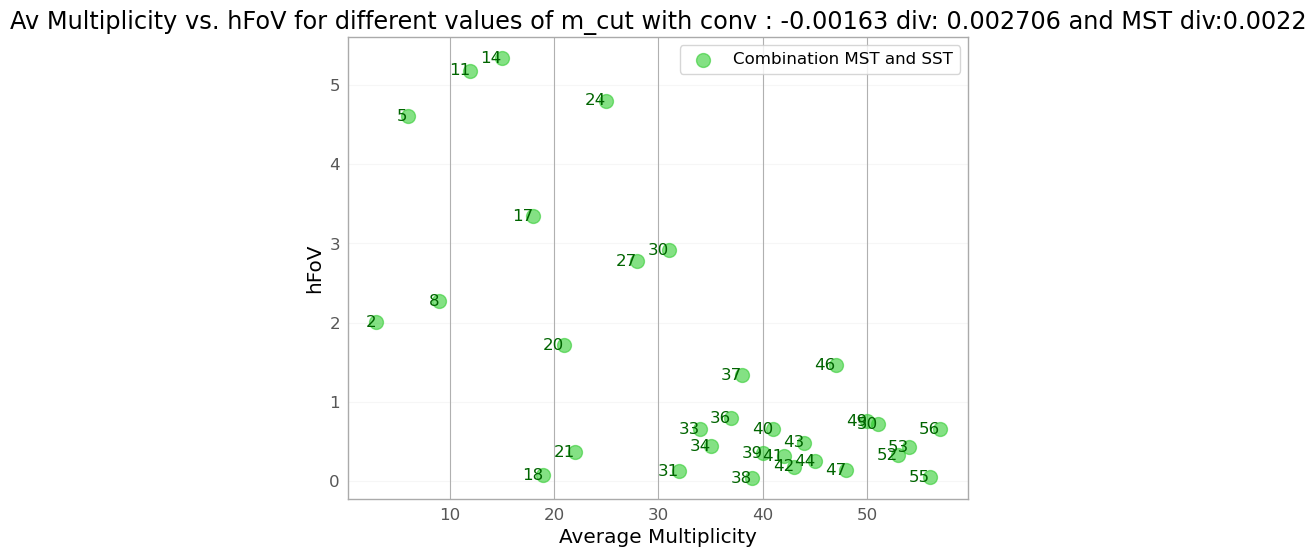

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.221888459954311 rad
-0.0 rad
1.2087209634084055 rad
-0.036609920612514585 rad
1.2088979499692634 rad
0.036609920612514585 rad
1.208572776043828 rad
-0.0 rad
1.2343956320561882 rad
0.03960711342202243 rad
1.2340446478846454 rad
-0.03960711342202243 rad
1.2348679690929507 rad
-0.0 rad
0


6it [00:00,  6.09it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.26it/s]
6it [00:00,  6.21it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.55it/s]


(0.0, nan)


6it [00:00,  6.26it/s]
7it [00:01,  6.32it/s]
4it [00:00,  6.36it/s]


1


6it [00:00,  6.34it/s]
7it [00:01,  6.20it/s]
4it [00:00,  6.30it/s]
6it [00:00,  6.19it/s]
7it [00:01,  6.46it/s]
4it [00:00,  6.00it/s]


(0.0, nan)


6it [00:00,  6.39it/s]
7it [00:01,  6.60it/s]
4it [00:00,  6.24it/s]


2


6it [00:00,  6.06it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.54it/s]
6it [00:00,  6.43it/s]
7it [00:01,  6.64it/s]
4it [00:00,  6.52it/s]


(2.557222825252774, 3.0)


6it [00:00,  6.31it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.34it/s]


3


6it [00:00,  6.27it/s]
7it [00:01,  6.33it/s]
4it [00:00,  6.33it/s]
6it [00:00,  6.32it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.40it/s]


(0.0, nan)


6it [00:00,  6.38it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.30it/s]


4


6it [00:00,  6.33it/s]
7it [00:01,  6.37it/s]
4it [00:00,  4.63it/s]
6it [00:00,  6.27it/s]
7it [00:01,  6.35it/s]
4it [00:00,  6.43it/s]


(0.0, nan)


6it [00:00,  6.32it/s]
7it [00:01,  6.40it/s]
4it [00:00,  6.16it/s]


5


6it [00:00,  6.21it/s]
7it [00:01,  5.91it/s]
4it [00:00,  6.41it/s]
6it [00:00,  6.51it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.43it/s]


(5.79637173723962, 6.0)


6it [00:00,  6.44it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.47it/s]


6


6it [00:00,  6.33it/s]
7it [00:01,  6.43it/s]
4it [00:00,  6.36it/s]
6it [00:00,  6.49it/s]
7it [00:01,  6.48it/s]
4it [00:00,  6.28it/s]


(0.0, nan)


6it [00:00,  6.50it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.37it/s]


7


6it [00:00,  6.46it/s]
7it [00:01,  6.59it/s]
4it [00:00,  6.44it/s]
6it [00:00,  6.17it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.55it/s]


(0.0, nan)


6it [00:00,  6.48it/s]
7it [00:01,  6.38it/s]
4it [00:00,  4.28it/s]


8


6it [00:00,  6.32it/s]
7it [00:01,  6.43it/s]
4it [00:00,  6.12it/s]
6it [00:00,  6.29it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.36it/s]


(2.7408183101427164, 9.0)


6it [00:00,  6.27it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.33it/s]


9


6it [00:01,  5.68it/s]
7it [00:01,  6.55it/s]
4it [00:00,  6.39it/s]
6it [00:00,  6.38it/s]
7it [00:01,  6.62it/s]
4it [00:00,  6.39it/s]


(0.0, nan)


6it [00:00,  6.30it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.47it/s]


10


6it [00:00,  6.16it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.35it/s]
6it [00:00,  6.30it/s]
7it [00:01,  6.45it/s]
4it [00:00,  6.41it/s]


(0.0, nan)


6it [00:00,  6.26it/s]
7it [00:01,  6.51it/s]
4it [00:00,  6.42it/s]


11


6it [00:00,  6.43it/s]
7it [00:01,  6.27it/s]
4it [00:00,  6.34it/s]
6it [00:01,  5.63it/s]
7it [00:01,  5.28it/s]
4it [00:00,  6.16it/s]


(6.609437456037939, 12.0)


6it [00:00,  6.40it/s]
7it [00:01,  6.54it/s]
4it [00:00,  6.26it/s]


12


6it [00:00,  6.28it/s]
7it [00:01,  6.39it/s]
4it [00:00,  6.34it/s]
6it [00:00,  6.37it/s]
7it [00:01,  6.04it/s]
4it [00:00,  6.40it/s]


(0.0, nan)


6it [00:00,  6.12it/s]
7it [00:01,  6.42it/s]
4it [00:00,  6.42it/s]


13


6it [00:00,  6.38it/s]
7it [00:01,  6.38it/s]
4it [00:00,  6.21it/s]
6it [00:00,  6.42it/s]
7it [00:01,  6.50it/s]
4it [00:00,  6.51it/s]


(0.0, nan)


6it [00:00,  6.45it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.45it/s]


14


6it [00:00,  6.14it/s]
7it [00:01,  6.11it/s]
4it [00:00,  6.29it/s]
6it [00:00,  6.17it/s]
7it [00:01,  6.19it/s]
4it [00:00,  5.96it/s]


(6.871716720166428, 15.0)


6it [00:00,  6.28it/s]
7it [00:01,  6.37it/s]
4it [00:00,  6.40it/s]


15


6it [00:00,  6.49it/s]
7it [00:01,  6.32it/s]
4it [00:00,  6.14it/s]
6it [00:00,  6.40it/s]
7it [00:01,  6.26it/s]
4it [00:00,  6.39it/s]


(0.0, nan)


6it [00:00,  6.09it/s]
7it [00:01,  6.47it/s]
4it [00:00,  6.28it/s]


16


6it [00:00,  6.09it/s]
7it [00:01,  6.12it/s]
4it [00:00,  5.70it/s]
6it [00:00,  6.28it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.43it/s]


(0.0, nan)


6it [00:01,  5.24it/s]
7it [00:01,  6.11it/s]
4it [00:00,  6.34it/s]


17


6it [00:00,  6.41it/s]
7it [00:01,  6.52it/s]
4it [00:00,  6.14it/s]
6it [00:01,  5.84it/s]
7it [00:01,  5.28it/s]
4it [00:00,  5.96it/s]


(3.894847072308071, 18.0)


6it [00:00,  6.23it/s]
7it [00:01,  6.17it/s]
4it [00:00,  6.10it/s]


18


6it [00:01,  5.93it/s]
7it [00:01,  6.01it/s]
4it [00:00,  5.85it/s]
6it [00:01,  5.91it/s]
7it [00:01,  6.00it/s]
4it [00:00,  5.75it/s]


(0.1311396320642448, 19.0)


6it [00:01,  5.92it/s]
7it [00:01,  5.97it/s]
4it [00:00,  5.99it/s]


19


6it [00:00,  6.03it/s]
7it [00:01,  6.07it/s]
4it [00:00,  5.88it/s]
6it [00:01,  5.77it/s]
7it [00:01,  6.11it/s]
4it [00:00,  5.55it/s]


(0.0, nan)


6it [00:00,  6.11it/s]
7it [00:01,  6.34it/s]
4it [00:00,  6.40it/s]


20


6it [00:01,  5.63it/s]
7it [00:01,  5.81it/s]
4it [00:00,  5.80it/s]
6it [00:01,  5.63it/s]
7it [00:01,  4.79it/s]
4it [00:00,  5.75it/s]


(1.7572710696608804, 21.0)


6it [00:00,  6.15it/s]
7it [00:01,  6.13it/s]
4it [00:00,  6.24it/s]


21


6it [00:00,  6.09it/s]
7it [00:01,  6.25it/s]
4it [00:00,  5.74it/s]
6it [00:01,  5.67it/s]
7it [00:01,  5.47it/s]
4it [00:00,  4.92it/s]


(0.5901283442891017, 22.0)


6it [00:01,  5.87it/s]
7it [00:01,  5.77it/s]
4it [00:00,  5.77it/s]


22


6it [00:01,  5.14it/s]
7it [00:01,  5.09it/s]
4it [00:00,  5.18it/s]
6it [00:00,  6.00it/s]
7it [00:01,  6.18it/s]
4it [00:00,  6.18it/s]


(0.0, nan)


6it [00:00,  6.08it/s]
7it [00:01,  6.02it/s]
4it [00:00,  6.03it/s]


23


6it [00:00,  6.04it/s]
7it [00:01,  5.57it/s]
4it [00:00,  5.73it/s]
6it [00:01,  5.80it/s]
7it [00:01,  5.85it/s]
4it [00:00,  5.87it/s]


(0.0, nan)


6it [00:01,  5.81it/s]
7it [00:01,  5.77it/s]
4it [00:00,  6.13it/s]


24


6it [00:01,  5.83it/s]
7it [00:01,  5.92it/s]
4it [00:00,  6.20it/s]
6it [00:00,  6.15it/s]
7it [00:01,  6.23it/s]
4it [00:00,  6.42it/s]


(4.275152005294381, 25.0)


6it [00:00,  6.14it/s]
7it [00:01,  6.41it/s]
4it [00:00,  5.95it/s]


25


6it [00:01,  5.87it/s]
7it [00:01,  6.20it/s]
4it [00:00,  6.12it/s]
6it [00:00,  6.17it/s]
7it [00:01,  6.18it/s]
4it [00:00,  6.37it/s]


(0.0, nan)


6it [00:00,  6.28it/s]
7it [00:01,  5.11it/s]
4it [00:00,  5.94it/s]


26


6it [00:00,  6.10it/s]
7it [00:01,  5.94it/s]
4it [00:00,  6.17it/s]
6it [00:00,  6.19it/s]
7it [00:01,  6.11it/s]
4it [00:00,  6.32it/s]


(0.0, nan)


6it [00:00,  6.23it/s]
7it [00:01,  6.14it/s]
4it [00:00,  6.34it/s]


27


6it [00:01,  5.87it/s]
7it [00:01,  6.12it/s]
4it [00:00,  6.27it/s]
6it [00:00,  6.06it/s]
7it [00:01,  6.09it/s]
4it [00:00,  5.96it/s]


(1.9277525913443987, 28.0)


6it [00:00,  6.10it/s]
7it [00:01,  6.36it/s]
4it [00:00,  6.12it/s]


28


6it [00:01,  5.42it/s]
7it [00:01,  6.13it/s]
4it [00:00,  6.29it/s]
6it [00:00,  6.30it/s]
7it [00:01,  6.38it/s]
4it [00:00,  5.99it/s]


(0.6688121235276485, 29.0)


6it [00:00,  6.18it/s]
7it [00:01,  5.96it/s]
4it [00:00,  5.90it/s]


29


6it [00:01,  5.39it/s]
7it [00:01,  4.83it/s]
4it [00:00,  5.63it/s]
6it [00:01,  5.55it/s]
7it [00:01,  6.07it/s]
4it [00:00,  6.17it/s]


(0.0, nan)


6it [00:00,  6.19it/s]
7it [00:01,  5.79it/s]
4it [00:00,  6.18it/s]


30


6it [00:01,  5.65it/s]
7it [00:01,  6.00it/s]
4it [00:00,  5.91it/s]
6it [00:01,  5.92it/s]
7it [00:01,  6.31it/s]
4it [00:00,  6.13it/s]


(1.1278008357525053, 31.0)


6it [00:00,  6.27it/s]
7it [00:01,  6.41it/s]
4it [00:00,  6.01it/s]


31


6it [00:01,  5.87it/s]
7it [00:01,  5.95it/s]
4it [00:00,  5.62it/s]
6it [00:01,  5.98it/s]
7it [00:01,  5.92it/s]
4it [00:00,  5.82it/s]


(1.285168394229599, 32.0)


6it [00:01,  5.81it/s]
7it [00:01,  5.50it/s]
4it [00:00,  5.63it/s]


32


6it [00:01,  5.20it/s]
7it [00:01,  5.68it/s]
4it [00:00,  5.49it/s]
6it [00:00,  6.19it/s]
7it [00:01,  6.11it/s]
4it [00:00,  5.88it/s]


(0.0, nan)


6it [00:01,  5.67it/s]
7it [00:01,  5.99it/s]
4it [00:00,  5.87it/s]


33


6it [00:01,  5.70it/s]
7it [00:01,  5.73it/s]
4it [00:00,  5.87it/s]
6it [00:00,  6.02it/s]
7it [00:01,  6.30it/s]
4it [00:00,  6.24it/s]


(1.0228891301011096, 34.0)


6it [00:01,  5.89it/s]
7it [00:01,  6.14it/s]
4it [00:00,  5.69it/s]


34


6it [00:01,  4.86it/s]
7it [00:01,  6.08it/s]
4it [00:00,  5.58it/s]
6it [00:01,  5.94it/s]
7it [00:01,  6.11it/s]
4it [00:00,  6.02it/s]


(1.2064846149910522, 35.0)


6it [00:01,  5.73it/s]
7it [00:01,  5.26it/s]
4it [00:00,  5.93it/s]


35


6it [00:00,  6.07it/s]
7it [00:01,  5.88it/s]
4it [00:00,  6.04it/s]
6it [00:00,  6.11it/s]
7it [00:01,  5.81it/s]
4it [00:00,  5.84it/s]


(0.11802566885782033, 36.0)


6it [00:01,  6.00it/s]
7it [00:01,  6.11it/s]
4it [00:00,  5.85it/s]


36


6it [00:01,  5.74it/s]
7it [00:01,  5.99it/s]
4it [00:00,  6.06it/s]
6it [00:00,  6.02it/s]
7it [00:01,  5.98it/s]
4it [00:00,  5.71it/s]


(0.6688121235276485, 37.0)


6it [00:01,  5.84it/s]
7it [00:01,  6.07it/s]
4it [00:00,  5.74it/s]


37


6it [00:01,  5.96it/s]
7it [00:01,  6.21it/s]
4it [00:00,  6.19it/s]
6it [00:00,  6.14it/s]
7it [00:01,  5.23it/s]
4it [00:00,  5.59it/s]


(2.3342854507435575, 38.0)


6it [00:01,  5.76it/s]
7it [00:01,  6.04it/s]
4it [00:00,  6.10it/s]


38


6it [00:00,  6.12it/s]
7it [00:01,  6.19it/s]
4it [00:00,  6.16it/s]
6it [00:00,  6.04it/s]
7it [00:01,  5.32it/s]
4it [00:00,  5.05it/s]


(0.4065328593991589, 39.0)


6it [00:01,  4.76it/s]
7it [00:01,  5.30it/s]
4it [00:00,  4.31it/s]


39


6it [00:01,  4.45it/s]
7it [00:01,  4.83it/s]
4it [00:00,  5.06it/s]
6it [00:01,  4.50it/s]
7it [00:01,  5.16it/s]
4it [00:00,  4.94it/s]


(0.4852166386377058, 40.0)


6it [00:01,  4.99it/s]
7it [00:01,  5.24it/s]
4it [00:00,  5.32it/s]


40


6it [00:01,  4.59it/s]
7it [00:01,  4.58it/s]
4it [00:00,  4.80it/s]
6it [00:01,  3.47it/s]
7it [00:01,  4.61it/s]
4it [00:00,  4.87it/s]


(1.4294219895002684, 41.0)


6it [00:01,  4.40it/s]
7it [00:01,  4.77it/s]
4it [00:00,  4.43it/s]


41


6it [00:01,  4.73it/s]
7it [00:01,  4.74it/s]
4it [00:00,  5.06it/s]
6it [00:01,  4.79it/s]
7it [00:01,  5.29it/s]
4it [00:00,  4.91it/s]


(0.4852166386377058, 42.0)


6it [00:01,  4.83it/s]
7it [00:01,  5.15it/s]
4it [00:00,  4.71it/s]


42


6it [00:01,  4.59it/s]
7it [00:01,  4.69it/s]
4it [00:00,  4.79it/s]
6it [00:01,  4.73it/s]
7it [00:01,  4.59it/s]
4it [00:00,  4.61it/s]


(0.026227926412848962, 43.0)


6it [00:01,  4.39it/s]
7it [00:01,  4.77it/s]
4it [00:00,  4.69it/s]


43


6it [00:01,  4.77it/s]
7it [00:01,  4.93it/s]
4it [00:00,  4.92it/s]
6it [00:01,  4.67it/s]
7it [00:01,  4.85it/s]
4it [00:00,  4.75it/s]


(0.9310913876561382, 44.0)


6it [00:01,  4.84it/s]
7it [00:01,  4.69it/s]
4it [00:00,  4.83it/s]


44


6it [00:01,  4.46it/s]
7it [00:01,  4.84it/s]
4it [00:00,  4.86it/s]
6it [00:01,  4.68it/s]
7it [00:01,  4.84it/s]
4it [00:00,  4.68it/s]


(0.4458747490184324, 45.0)


6it [00:01,  4.73it/s]
7it [00:02,  2.75it/s]
4it [00:00,  4.55it/s]


45


6it [00:01,  4.78it/s]
7it [00:01,  4.81it/s]
4it [00:00,  4.73it/s]
6it [00:01,  3.76it/s]
7it [00:01,  4.63it/s]
4it [00:00,  4.53it/s]


(0.0, nan)


6it [00:01,  4.71it/s]
7it [00:01,  5.07it/s]
4it [00:00,  4.79it/s]


46


6it [00:01,  4.69it/s]
7it [00:01,  4.75it/s]
4it [00:00,  4.97it/s]
6it [00:01,  5.01it/s]
7it [00:01,  5.04it/s]
4it [00:00,  5.08it/s]


(1.442535952706693, 47.0)


6it [00:01,  4.91it/s]
7it [00:01,  4.92it/s]
4it [00:00,  4.53it/s]


47


6it [00:01,  4.90it/s]
7it [00:01,  5.14it/s]
4it [00:00,  5.02it/s]
6it [00:01,  5.12it/s]
7it [00:01,  5.29it/s]
4it [00:00,  5.04it/s]


(0.31473511695418754, 48.0)


6it [00:01,  4.90it/s]
7it [00:01,  4.52it/s]
4it [00:00,  4.90it/s]


48


6it [00:01,  4.63it/s]
7it [00:01,  4.74it/s]
4it [00:00,  4.80it/s]
6it [00:01,  4.74it/s]
7it [00:01,  4.49it/s]
4it [00:00,  4.73it/s]


(0.0, nan)


6it [00:01,  4.65it/s]
7it [00:01,  4.55it/s]
4it [00:00,  4.60it/s]


49


6it [00:01,  4.85it/s]
7it [00:01,  4.29it/s]
4it [00:01,  3.72it/s]
6it [00:01,  3.73it/s]
7it [00:01,  3.78it/s]
4it [00:00,  4.94it/s]


(1.0753449829268074, 50.0)


6it [00:01,  4.93it/s]
7it [00:01,  5.16it/s]
4it [00:00,  4.95it/s]


50


6it [00:01,  4.84it/s]
7it [00:01,  4.75it/s]
4it [00:00,  4.46it/s]
6it [00:01,  4.60it/s]
7it [00:01,  4.79it/s]
4it [00:00,  4.79it/s]


(1.009775166894685, 51.0)


6it [00:01,  4.21it/s]
7it [00:01,  4.49it/s]
4it [00:00,  4.76it/s]


51


6it [00:01,  4.48it/s]
7it [00:01,  4.83it/s]
4it [00:00,  4.62it/s]
6it [00:01,  4.60it/s]
7it [00:01,  4.68it/s]
4it [00:00,  4.86it/s]


(0.0, nan)


6it [00:01,  4.68it/s]
7it [00:01,  4.70it/s]
4it [00:00,  5.03it/s]


52


6it [00:01,  4.40it/s]
7it [00:01,  4.59it/s]
4it [00:00,  4.79it/s]
6it [00:01,  4.69it/s]
7it [00:01,  4.95it/s]
4it [00:00,  4.72it/s]


(0.4458747490184324, 53.0)


6it [00:01,  4.60it/s]
7it [00:01,  4.82it/s]
4it [00:00,  4.73it/s]


53


6it [00:01,  4.66it/s]
7it [00:01,  4.88it/s]
4it [00:00,  5.01it/s]
6it [00:01,  4.81it/s]
7it [00:01,  4.66it/s]
4it [00:00,  4.78it/s]


(0.4589887122248568, 54.0)


6it [00:01,  4.54it/s]
7it [00:02,  2.91it/s]
4it [00:00,  4.60it/s]


54


6it [00:01,  4.50it/s]
7it [00:01,  4.91it/s]
4it [00:00,  4.98it/s]
6it [00:01,  5.16it/s]
7it [00:01,  4.94it/s]
4it [00:00,  4.68it/s]


(0.0, nan)


6it [00:01,  4.77it/s]
7it [00:01,  4.82it/s]
4it [00:00,  4.91it/s]


55


6it [00:01,  4.63it/s]
7it [00:01,  5.13it/s]
4it [00:00,  5.14it/s]
6it [00:01,  5.05it/s]
7it [00:01,  5.04it/s]
4it [00:00,  4.99it/s]


(0.17048152168351827, 56.0)


6it [00:01,  4.99it/s]
7it [00:01,  4.73it/s]
4it [00:00,  4.87it/s]


56


6it [00:01,  4.81it/s]
7it [00:01,  5.01it/s]
4it [00:00,  4.95it/s]
6it [00:01,  4.86it/s]
7it [00:01,  5.06it/s]
4it [00:00,  4.84it/s]


(0.5507864546698282, 57.0)


6it [00:01,  4.91it/s]
7it [00:01,  5.17it/s]
4it [00:00,  4.73it/s]


57


6it [00:01,  4.67it/s]
7it [00:01,  5.23it/s]
4it [00:00,  5.13it/s]
6it [00:01,  4.85it/s]
7it [00:01,  5.01it/s]
4it [00:00,  4.87it/s]


(0.0, nan)


6it [00:01,  4.78it/s]
7it [00:01,  4.87it/s]
4it [00:00,  4.85it/s]


58


6it [00:01,  3.21it/s]
7it [00:01,  3.65it/s]
4it [00:00,  4.40it/s]
6it [00:01,  4.60it/s]
7it [00:01,  4.54it/s]
4it [00:00,  4.54it/s]


(0.0, nan)


6it [00:01,  5.06it/s]
7it [00:01,  5.04it/s]
4it [00:00,  4.95it/s]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

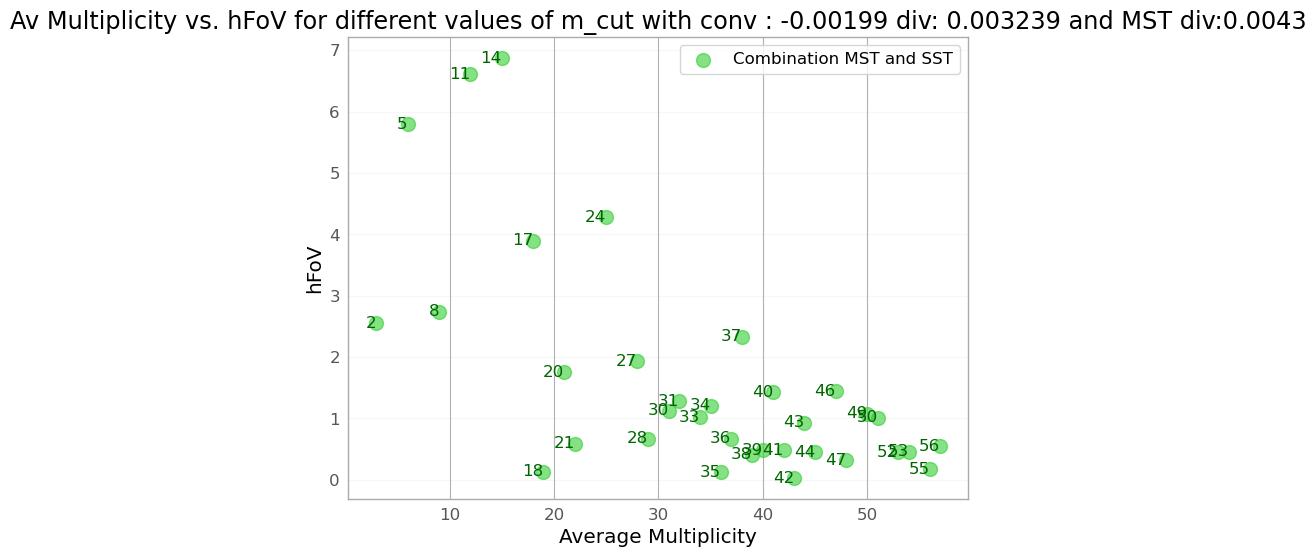

The barycenter -26.08250000000001
The barycenter -13.394999999999996
The barycenter 28.009999999999998
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations[-0.67307692  0.         27.68615385]
The barycenter -0.6730769230769493
The barycenter 0.0
The barycenter 27.686153846153847
the barycenter for the calculations of the second divergence[-0.67307692  0.         27.68615385]
1.2219405205135656 rad
-0.0 rad
1.2043679838696495 rad
-0.04805403044207357 rad
1.2046055870020083 rad
0.04805403044207357 rad
1.2042642954675646 rad
-0.0 rad
1.2384757656555938 rad
0.053351356923524225 rad
1.2380139049082797 rad
-0.053351356923524225 rad
1.239222259531967 rad
-0.0 rad
0


6it [00:01,  4.72it/s]
7it [00:01,  4.72it/s]
4it [00:00,  4.75it/s]
6it [00:01,  4.58it/s]
7it [00:01,  4.48it/s]
4it [00:00,  4.77it/s]


(0.0, nan)


4it [00:00,  4.09it/s]


KeyboardInterrupt: 

In [75]:
for i in range(10):
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(tel_group_2=SST_config_div, complete_array=full_array_config_SST, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
    SST_config_conv.combination_bar_graph_av_mult_MST_and_SST(array_2=SST_config_div, array_3=config_MST,subarray_mult=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1)
    

In [62]:
SST_config_div

In [ ]:
for i in range(10):
    hFoV_graph=[]
    multiplicities=[]
    config_MST.divergent_pointing(div_MST[i], az=0,alt=70)
    SST_config_conv.divergent_pointing_2_div(complete_array=full_array_config_SST,tel_group_2=SST_config_div, div1=conv_SST[i], div2=div_SST[i], az=0, alt=70)
#full_array.divergent_pointing(div=0.001, az=0, alt=70)

    for j in range(60):
        hFoV_graph.append(SST_config_conv.combiantion_of_FoV_with_m_cut_equal_to(number_of_arrays=3, array_2=SST_config_div, array_3=config_MST,subarray_mult_1=number_of_telescopes_config_SST_first_half, subarray_mult_2=number_of_telescopes_config_SST_second_half, subarray_mult_3=number_of_telescopes_subarray_1, m_cut=j)
[0])
        multiplicities.append(j+1)
    plt.figure(figsize=(8, 6)) 
    plt.bar(multiplicities, np.array(hFoV_graph).flatten(), color='limegreen')
    plt.xlabel("Multiplicities")
    plt.ylabel("hFoV[$deg^2$]")
    plt.title(f"div:{0}")
    plt.grid(axis='y', alpha=0.4)
    plt.show()   



